### Importing Required Libraries and Loading Geospatial Data

In [1]:
import random
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import geopandas as gpd
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from PIL import Image
import os
from tqdm import tqdm 
from shapely.geometry import Point

# Cell 1: load tract, district, and parcel layers
import geopandas as gpd

tracts    = gpd.read_file(
    "C:/Users/ka34292/Desktop/Agent Based/Shapefiles/New folder/Austin_tract_Merged1.shp"
)
districts = gpd.read_file(
    "C:/Users/ka34292/Desktop/Agent Based/Shapefiles/New folder/Council_Districts.shp"
)
parcels   = gpd.read_file(
    "C:/Users/ka34292/Desktop/Agent Based/Shapefiles/New folder/Parcel_with_Building_Area1.shp"
)

# Print the column names of both shapefiles
print("Tracts Shapefile Columns:")
print(tracts.columns)

print("\ndistricts Shapefile Columns:")
print(districts.columns)

print("\nParcels Shapefile Columns:")
print(parcels.columns)


Tracts Shapefile Columns:
Index(['STATEFP', 'COUNTYF', 'TRACTCE', 'GEOID', 'GEOIDFQ', 'NAME', 'NAMELSA',
       'FUNCSTA', 'ALAND', 'INTPTLA', 'INTPTLO', 'concl_d', 'Incm_mn',
       'Incm_sd', 'TtlPplt', 'White%', 'NonWht%', 'NnAdvDg', 'AdvDeg',
       'smpl_sz', 'p((SD))', 'at((SD))', 'aw((SD))', 's_((SD)', 'geometry'],
      dtype='object')

districts Shapefile Columns:
Index(['council_di', 'council__2', 'shape_area', 'shape_leng', 'label',
       'geometry'],
      dtype='object')

Parcels Shapefile Columns:
Index(['Parcel_Id', 'P_Area', 'B_Area', 'geometry'], dtype='object')


### Data Preprocessing: Reprojecting and Filtering Parcels

In [2]:
# Cell 2: preprocess parcels → assign to tracts → filter eligible parcels
import pandas as pd
import geopandas as gpd

# 1) Reproject parcels to match tracts' CRS
parcels = parcels.to_crs(tracts.crs)

# 2) Spatial join: each parcel ←→ its containing tract
parcels_with_tracts = (
    gpd.sjoin(parcels, tracts, how="left", predicate="within")
    .dropna(subset=["GEOID"])
)

# 3) Ensure GEOID is string on both layers
parcels_with_tracts["GEOID"] = parcels_with_tracts["GEOID"].astype(str)
tracts["GEOID"]            = tracts["GEOID"].astype(str)

# 4) (Optional) Reproject everything to UTM Zone 14N for accurate area units
target_crs = "EPSG:26914"
tracts             = tracts.to_crs(target_crs)
parcels            = parcels.to_crs(target_crs)
parcels_with_tracts = parcels_with_tracts.to_crs(target_crs)

# 5) Filter by parcel area (P_Area) and building area (B_Area)
eligible_parcels = parcels_with_tracts[
    parcels_with_tracts["P_Area"].between(500, 10000) &
    parcels_with_tracts["B_Area"].between(500, 5000)
]

# 6) Identify any where building footprint > parcel area
problematic_parcels = eligible_parcels[
    eligible_parcels["B_Area"] > eligible_parcels["P_Area"]
]
# then drop those from eligible set
eligible_parcels = eligible_parcels[
    eligible_parcels["B_Area"] <= eligible_parcels["P_Area"]
]

# 7) Quick sanity check
print(f"Eligible parcels:   {len(eligible_parcels)}")
print(f"Problematic parcels: {len(problematic_parcels)}")


Eligible parcels:   116432
Problematic parcels: 2203


### Defining Potential Score Calculation Functions

In [3]:
# Potential score functions — guaranteed in [0.5, 1.0]

# Function to calculate potential scores for Rain-Catching
def calculate_rain_catching_potential(B_Area):
    """
    Map B_Area to a potential in [0.5, 1.0]:
      - ≤ 500  -> 0.5
      - ≥ 5000 -> 1.0
      - linear in between
    """
    if B_Area <= 500:
        return 0.5
    elif B_Area >= 5000:
        return 1.0
    else:
        # slope = (1.0 - 0.5) / (5000 - 500)
        return 0.5 + (B_Area - 500) * (0.5 / (5000 - 500))

# Function to calculate potential scores for Structural Practices
def calculate_structural_practices_potential(P_Area, B_Area):
    """
    Use remaining area (P_Area - B_Area), mapped to [0.5, 1.0]:
      - ≤ 1000  -> 0.5
      - ≥ 8000  -> 1.0
      - linear in between
    """
    remaining_area = max(P_Area - B_Area, 0)  # guard negatives
    if remaining_area <= 1000:
        return 0.5
    elif remaining_area >= 8000:
        return 1.0
    else:
        # slope = (1.0 - 0.5) / (8000 - 1000)
        return 0.5 + (remaining_area - 1000) * (0.5 / (8000 - 1000))


In [4]:
# Recompute potentials in [0.5, 1.0] — vectorized + verified

import numpy as np

def _rc_vec(B):
    B = np.asarray(B, dtype=float)
    out = np.full_like(B, 0.5, dtype=float)
    mid = (B > 500) & (B < 5000)
    out[B >= 5000] = 1.0
    out[mid] = 0.5 + (B[mid] - 500) * (0.5 / (5000 - 500))  # linear to 1.0
    return out

def _st_vec(P, B):
    P = np.asarray(P, dtype=float)
    B = np.asarray(B, dtype=float)
    rem = np.maximum(P - B, 0.0)
    out = np.full_like(rem, 0.5, dtype=float)
    mid = (rem > 1000) & (rem < 8000)
    out[rem >= 8000] = 1.0
    out[mid] = 0.5 + (rem[mid] - 1000) * (0.5 / (8000 - 1000))
    return out

# Assign (no .apply; fully vectorized)
eligible_parcels['rain_catching_potential'] = _rc_vec(eligible_parcels['B_Area'].to_numpy())
eligible_parcels['structural_practices_potential'] = _st_vec(
    eligible_parcels['P_Area'].to_numpy(), eligible_parcels['B_Area'].to_numpy()
)

# Sanity check: ensure bounds are [0.5, 1.0]
mn_rc = float(eligible_parcels['rain_catching_potential'].min())
mx_rc = float(eligible_parcels['rain_catching_potential'].max())
mn_st = float(eligible_parcels['structural_practices_potential'].min())
mx_st = float(eligible_parcels['structural_practices_potential'].max())

assert mn_rc >= 0.5 - 1e-9 and mx_rc <= 1.0 + 1e-9, f"RC outside [0.5,1.0]: [{mn_rc},{mx_rc}]"
assert mn_st >= 0.5 - 1e-9 and mx_st <= 1.0 + 1e-9, f"ST outside [0.5,1.0]: [{mn_st},{mx_st}]"

print(f"rain_catching_potential in [{mn_rc:.3f}, {mx_rc:.3f}]")
print(f"structural_practices_potential in [{mn_st:.3f}, {mx_st:.3f}]")


rain_catching_potential in [0.500, 1.000]
structural_practices_potential in [0.500, 1.000]


### Handling Data and Household Assignment

In [5]:
# Cell 0 — Joint latent distributions (A,N,W,S) per district

import numpy as np
import pandas as pd
import re

# --- EDIT paths if needed ---
corr_struct_path    = r"C:\Users\ka34292\Desktop\Agent Based\Revision\OROWsem_ABM_outputs\Latent_correlations_pooled_structural.csv"
corr_rain_path      = r"C:\Users\ka34292\Desktop\Agent Based\Revision\OROWsem_ABM_outputs\Latent_correlations_pooled_rain.csv"
district_stats_path = r"C:\Users\ka34292\Desktop\Agent Based\Revision\SEM\District stats.csv"

# target variable order
VARS = ["Attitude","PersonalNorm","Awareness","SocialCapital"]

def _normalize_labels(seq):
    return [re.sub(r'[^a-z]', '', str(x).lower()) for x in seq]

def _load_corr(path):
    """
    Load a 4×4 correlation matrix with columns (and possibly rows) for:
    Attitude, PersonalNorm, Awareness, SocialCapital.
    Robust to files that wrote row labels into the first column.
    """
    df = pd.read_csv(path)

    # If first column looks like row labels (strings; not purely numeric), use as index
    if df.shape[1] >= 5 and not np.issubdtype(df.iloc[:, 0].dtype, np.number):
        df = df.set_index(df.columns[0])

    want_norm = _normalize_labels(VARS)
    col_norm  = _normalize_labels(df.columns)
    col_map   = {n: c for n, c in zip(col_norm, df.columns)}

    # Align columns; if rows exist, align them too
    have_cols = all(n in col_map for n in want_norm)
    if not have_cols:
        raise ValueError(f"Expected columns {VARS} (any case/spacing). Got: {list(df.columns)}")

    df = df[[col_map[n] for n in want_norm]]

    # If index present, try to align rows as well
    if df.index.nlevels == 1 and len(df.index) >= 4:
        idx_norm = _normalize_labels(df.index)
        idx_map  = {n: i for n, i in zip(idx_norm, df.index)}
        if all(n in idx_map for n in want_norm):
            df = df.loc[[idx_map[n] for n in want_norm], :]
        else:
            # No usable row labels; just take first 4 rows
            df = df.iloc[:4, :]
    else:
        df = df.iloc[:4, :]

    M = df.to_numpy(dtype=float)
    # Symmetrize just in case and normalize to correlation
    M = 0.5 * (M + M.T)
    d = np.sqrt(np.diag(M))
    M = M / np.outer(d, d)
    np.fill_diagonal(M, 1.0)
    return M

def _to_psd_corr(R, eps=1e-6):
    """Clip negative eigenvalues, then renormalize to a correlation matrix."""
    R = 0.5 * (R + R.T)
    w, V = np.linalg.eigh(R)
    w = np.clip(w, eps, None)
    R_psd = (V * w) @ V.T
    # Renormalize to unit diagonal
    d = np.sqrt(np.diag(R_psd))
    R_corr = R_psd / np.outer(d, d)
    np.fill_diagonal(R_corr, 1.0)
    return R_corr

# 1) Pooled latent correlation (average of structural & rain), forced PSD
R_struct = _load_corr(corr_struct_path)
R_rain   = _load_corr(corr_rain_path)
R_pool   = 0.5 * (R_struct + R_rain)
R_pool   = _to_psd_corr(R_pool)

# 2) Load district latent means/SDs
dist = pd.read_csv(district_stats_path)
# Expected columns: District, mean_A, sd_A, mean_N, sd_N, mean_W, sd_W, mean_S, sd_S
needed = ["District","mean_A","sd_A","mean_N","sd_N","mean_W","sd_W","mean_S","sd_S"]
missing = [c for c in needed if c not in dist.columns]
if missing:
    raise ValueError(f"Missing columns in district_stats: {missing}")

dist = dist.copy()
dist["District"] = dist["District"].astype(int)

# 3) Build per-district joint Normal params
#    μ_d = [mean_A, mean_N, mean_W, mean_S]
#    Σ_d = diag(sd) * R_pool * diag(sd)
JOINT_LATENT = {}  # district_id -> {"mu": mu, "Sigma": Sigma}

for _, row in dist.iterrows():
    did = int(row["District"])
    sigmas = np.array([row["sd_A"], row["sd_N"], row["sd_W"], row["sd_S"]], dtype=float)
    # guard tiny/zero SDs
    sigmas = np.where(sigmas > 1e-8, sigmas, 1e-3)
    D = np.diag(sigmas)
    Sigma = D @ R_pool @ D
    # Ensure numeric symmetry and PSD
    Sigma = 0.5 * (Sigma + Sigma.T)
    Sigma = Sigma + 1e-10 * np.eye(4)  # tiny jitter

    mu = np.array([row["mean_A"], row["mean_N"], row["mean_W"], row["mean_S"]], dtype=float)
    JOINT_LATENT[did] = {"mu": mu, "Sigma": Sigma}

# 4) Small helpers you can call from later cells
def sample_latents_for_district(district_id, size=1, rng=None):
    """
    Draw (A,N,W,S) for a district from the joint Normal.
    Returns: array of shape (size, 4).
    """
    if rng is None:
        rng = np.random
    district_id = int(district_id)
    if district_id not in JOINT_LATENT:
        # fallback to overall mean of params if unknown district
        all_mu = np.vstack([v["mu"] for v in JOINT_LATENT.values()])
        all_S  = np.stack([v["Sigma"] for v in JOINT_LATENT.values()], axis=0)
        mu = all_mu.mean(axis=0)
        Sigma = all_S.mean(axis=0)
    else:
        mu = JOINT_LATENT[district_id]["mu"]
        Sigma = JOINT_LATENT[district_id]["Sigma"]
    return rng.multivariate_normal(mean=mu, cov=Sigma, size=size)

def get_joint_params(district_id):
    """Return (mu, Sigma) for the district (A,N,W,S order)."""
    d = JOINT_LATENT.get(int(district_id))
    if d is None:
        raise KeyError(f"District {district_id} not found in JOINT_LATENT.")
    return d["mu"], d["Sigma"]

# Convenience wrapper so later cells can call draw_latents(district_id)
def draw_latents(district_id, rng=None):
    """
    Return a single sample (A, N, W, S) for the given district_id.
    """
    arr = sample_latents_for_district(int(district_id), size=1, rng=rng)
    A, N, W, S = arr[0]
    return A, N, W, S


In [6]:
# Cell 1 — Build household_data using draw_latents from Cell 0

import pandas as pd
import numpy as np

# 1) Convert your tract‐percentage columns on eligible_parcels to numeric
for col in ['White%', 'NonWht%', 'NnAdvDg', 'AdvDeg']:
    eligible_parcels[col] = pd.to_numeric(eligible_parcels[col], errors='coerce')

# 2) Prepare lists for outputs
household_data = []
structural_behavior_scores = []
raincatching_behavior_scores = []
nonstructural_behavior_scores = []
total_behavior_scores = []
rain_catching_potential_values = []
structural_practices_potential_values = []

# 3) Loop over parcels, using 'concl_d' as the district ID
for _, parcel in eligible_parcels.iterrows():
    tract_id    = parcel['GEOID']
    district_id = int(parcel['concl_d'])   # existing district column

    # — demographic draws from the tract fields —
    income = np.random.lognormal(parcel['Incm_mn'], parcel['Incm_sd'])
    if income > 500_000:
        continue
    income = max(10_000, income)

    race = np.random.choice(
        ["White","Non-White"],
        p=[parcel['White%']/100, parcel['NonWht%']/100]
    )
    adv_degree = np.random.choice(
        ["Adv Degree","No Adv Degree"],
        p=[parcel['AdvDeg']/100, parcel['NnAdvDg']/100]
    )

    # — sample latents jointly from MVN (A,N,W,S) using Cell 0 —
    A, N, W, S = draw_latents(district_id)
    attitude, personal_norms, awareness, social_capital = A, N, W, S

    # — compute potentials —
    rc_pot = parcel['rain_catching_potential']
    st_pot = parcel['structural_practices_potential']

    # — behavior score formulas —
    structural_behavior = (
        1.51
        + (-0.45 if race == "Non-White" else 0)
        + (0.08 if income < 20000 else -0.17 if income < 50000 else 0.15)
        + (-0.26 if adv_degree == "No Adv Degree" else 0)
        + 0.37 * personal_norms + 0.23 * social_capital
        - 0.02 * attitude + 0.02 * awareness
    ) * st_pot

    raincatching_behavior = (
        0.39
        + (-0.18 if race == "Non-White" else 0)
        + (-0.05 if adv_degree == "No Adv Degree" else 0)
        + (0.03 if income < 20000 else 0.02 if income < 50000 else 0.13)
        + 0.22 * personal_norms + 0.07 * social_capital
        + 0.05 * attitude - 0.02 * awareness
    ) * rc_pot

    nonstructural_behavior = (
        4.45
        + (-0.22 if race == "Non-White" else 0)
        + (0.11 if adv_degree == "No Adv Degree" else 0)
        + (0.13 if income < 20000 else -0.21 if income < 50000 else -0.24 if income < 80000 else 0)
        + 0.51 * personal_norms + 0.11 * social_capital
        + 0.03 * attitude + 0.14 * awareness
    )

    total_behavior = structural_behavior + raincatching_behavior + nonstructural_behavior

    # — append to lists —
    structural_behavior_scores.append(structural_behavior)
    raincatching_behavior_scores.append(raincatching_behavior)
    nonstructural_behavior_scores.append(nonstructural_behavior)
    total_behavior_scores.append(total_behavior)
    rain_catching_potential_values.append(rc_pot)
    structural_practices_potential_values.append(st_pot)

    # NOTE: keep your original order for Household():
    # (attitude, awareness, social_capital, personal_norms)
    household_data.append((
        tract_id, district_id,
        attitude, awareness, social_capital, personal_norms,
        income, race, adv_degree,
        structural_behavior, raincatching_behavior,
        nonstructural_behavior, total_behavior,
        st_pot, rc_pot,
        parcel['B_Area'], parcel['P_Area']
    ))


### Calculating Percentile Ranks and Thresholds for Behavior Scores

In [7]:
import numpy as np
import pandas as pd

# 1) Read the precomputed district thresholds (raw‐scale)
theta_rain_df = pd.read_csv(
    r"C:\Users\ka34292\Desktop\Agent Based\Revision\SEM\Theta_rain_plan.csv"
)
theta_struct_df = pd.read_csv(
    r"C:\Users\ka34292\Desktop\Agent Based\Revision\SEM\Theta_struct_plan.csv"
)

# 2) Build lookup dicts keyed by district int
#    (use the 'theta_raw' column)
theta_rain_map   = dict(zip(
    theta_rain_df['District'].astype(int),
    theta_rain_df['theta_raw']          # <— raw‐scale threshold
))
theta_struct_map = dict(zip(
    theta_struct_df['District'].astype(int),
    theta_struct_df['theta_raw']
))

# 3) Prepare your thresholds lists
structural_behavior_thresholds     = []
raincatching_behavior_thresholds   = []
nonstructural_behavior_thresholds  = []
total_behavior_thresholds          = []

# 4) Fill them in
for i, record in enumerate(household_data):
    tract_id, district_id, *rest = record

    try:
        tau_struct = theta_struct_map[district_id]
        tau_rain   = theta_rain_map[  district_id]
    except KeyError:
        raise KeyError(f"No theta found for district {district_id}")

    structural_behavior_thresholds.append(tau_struct)
    raincatching_behavior_thresholds.append(tau_rain)
    nonstructural_behavior_thresholds.append(1.0)
    total_behavior_thresholds.append(1.0)

    # Rebuild your household_data tuple
    household_data[i] = (
        tract_id, district_id, *rest,
        tau_struct,
        tau_rain,
        1.0,  # nonstructural threshold
        1.0   # total threshold
    )


### Visualizing Latent Variables and Socio-Economic Characteristics

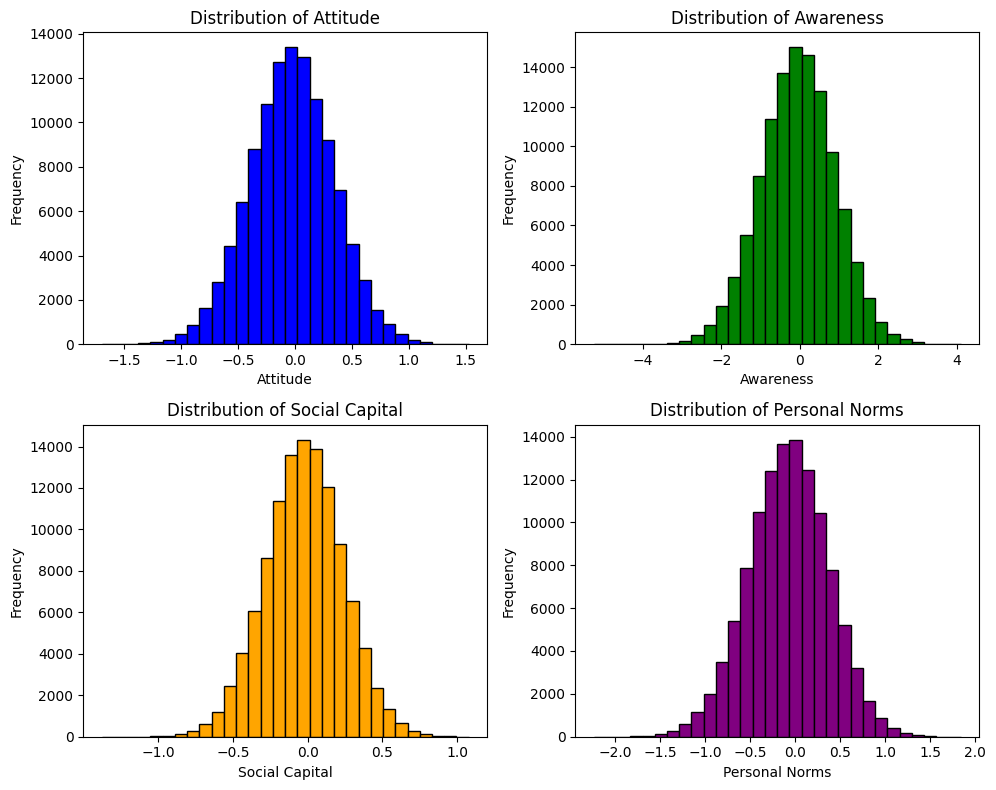

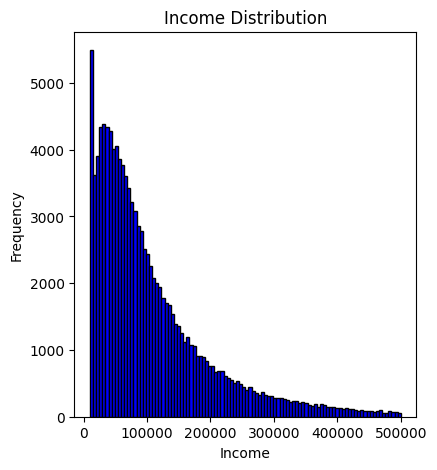

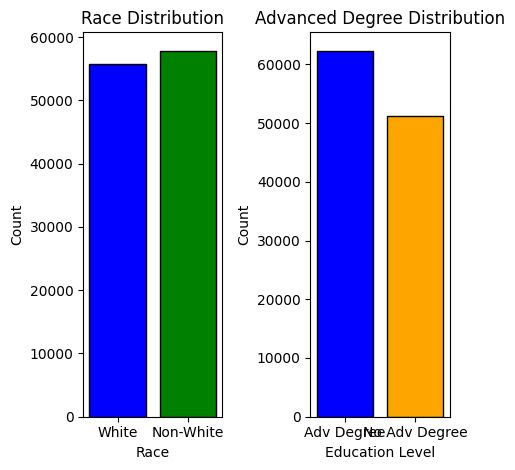

In [8]:
import matplotlib.pyplot as plt

# Extract the latent variables from the household_data
attitude_values = [household[2] for household in household_data]  # Column index for attitude
awareness_values = [household[3] for household in household_data]  # Column index for awareness
social_capital_values = [household[4] for household in household_data]  # Column index for social capital
personal_norms_values = [household[5] for household in household_data]  # Column index for personal norms

# Create a 2x2 plot grid for the distributions
plt.figure(figsize=(10, 8))

# Subplot for attitude
plt.subplot(2, 2, 1)
plt.hist(attitude_values, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Attitude')
plt.xlabel('Attitude')
plt.ylabel('Frequency')

# Subplot for awareness
plt.subplot(2, 2, 2)
plt.hist(awareness_values, bins=30, color='green', edgecolor='black')
plt.title('Distribution of Awareness')
plt.xlabel('Awareness')
plt.ylabel('Frequency')

# Subplot for social capital
plt.subplot(2, 2, 3)
plt.hist(social_capital_values, bins=30, color='orange', edgecolor='black')
plt.title('Distribution of Social Capital')
plt.xlabel('Social Capital')
plt.ylabel('Frequency')

# Subplot for personal norms
plt.subplot(2, 2, 4)
plt.hist(personal_norms_values, bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Personal Norms')
plt.xlabel('Personal Norms')
plt.ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# Now for the socio-economic characteristics plot
import numpy as np

# Flatten the lists for income, race, and advanced degree status
income_values_flat = [household[6] for household in household_data]  # Column index for income
race_values_flat = [household[7] for household in household_data]  # Column index for race
adv_degree_values_flat = [household[8] for household in household_data]  # Column index for education level (Adv Degree)

# Create a figure for the 3 side-by-side bar plots
plt.figure(figsize=(15, 5))

# Income distribution plot
plt.subplot(1, 3, 1)
plt.hist(income_values_flat, bins=100, color='blue', edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Frequency')

plt.show()

# Race distribution plot
plt.subplot(1, 3, 2)
plt.bar(['White', 'Non-White'], [race_values_flat.count('White'), race_values_flat.count('Non-White')], color=['blue', 'green'], edgecolor='black')
plt.title('Race Distribution')
plt.xlabel('Race')
plt.ylabel('Count')

# Advanced degree distribution plot
plt.subplot(1, 3, 3)
plt.bar(['Adv Degree', 'No Adv Degree'], [adv_degree_values_flat.count('Adv Degree'), adv_degree_values_flat.count('No Adv Degree')], color=['blue', 'orange'], edgecolor='black')
plt.title('Advanced Degree Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


### Plotting Behavior Score Distributions

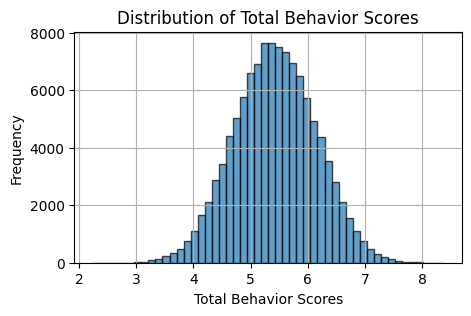

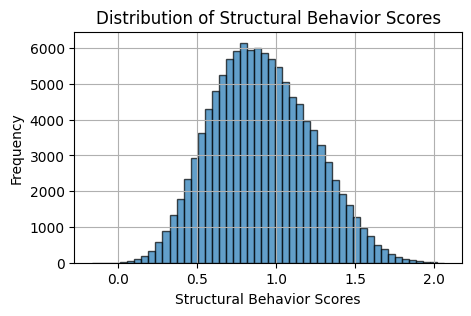

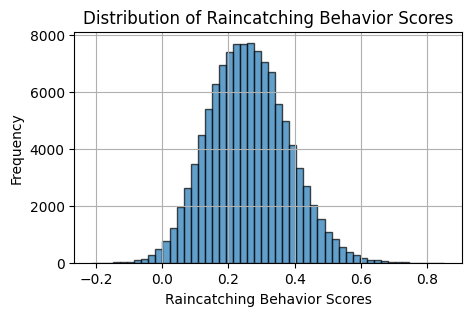

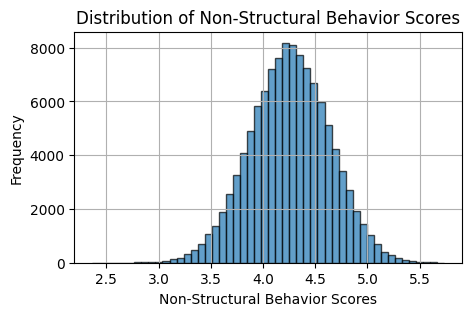

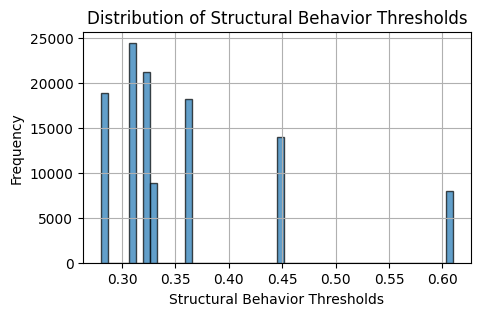

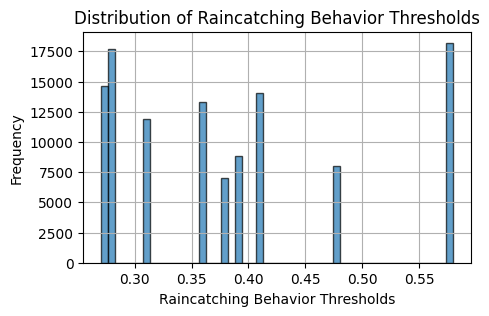

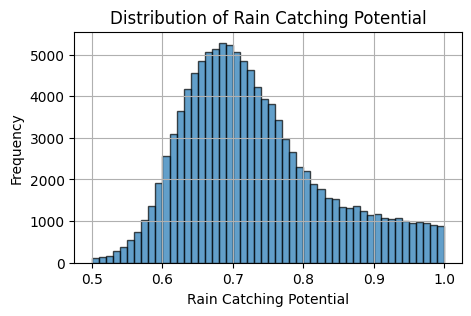

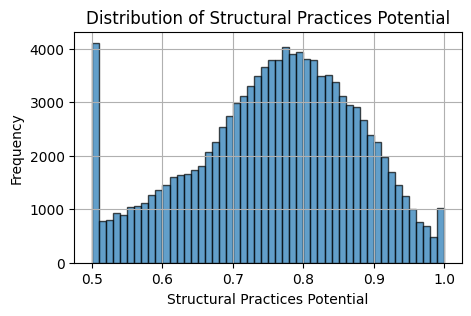

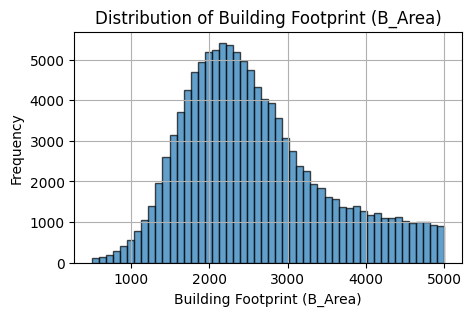

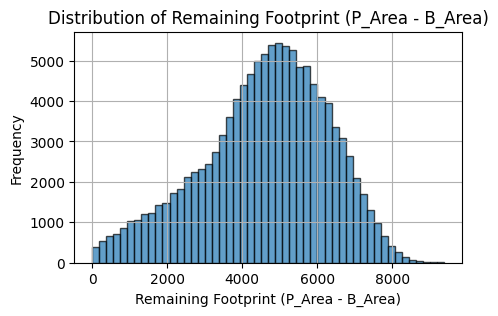

In [9]:
import matplotlib.pyplot as plt

def plot_distribution(data, variable_name, bins=50):
    """
    Plots the distribution of a given variable.
    
    Parameters:
        data (array-like): The data to be plotted (list, array, or pandas column).
        variable_name (str): The name of the variable for labeling purposes.
        bins (int): Number of bins for the histogram (default is 50).
    """
    plt.figure(figsize=(5, 3))
    plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
    plt.xlabel(variable_name)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {variable_name}")
    plt.grid(True)
    plt.show()

# — Behavior score distributions —
plot_distribution(total_behavior_scores,        "Total Behavior Scores")
plot_distribution(structural_behavior_scores,  "Structural Behavior Scores")
plot_distribution(raincatching_behavior_scores, "Raincatching Behavior Scores")
plot_distribution(nonstructural_behavior_scores, "Non-Structural Behavior Scores")

# — Threshold distributions —
plot_distribution(structural_behavior_thresholds,   "Structural Behavior Thresholds")
plot_distribution(raincatching_behavior_thresholds, "Raincatching Behavior Thresholds")

# — Potential score distributions —
plot_distribution(rain_catching_potential_values,        "Rain Catching Potential")
plot_distribution(structural_practices_potential_values, "Structural Practices Potential")

# — Parcel area distributions —
B_Area_values = eligible_parcels['B_Area'].tolist()
plot_distribution(B_Area_values, "Building Footprint (B_Area)")

remaining_values = (eligible_parcels['P_Area'] - eligible_parcels['B_Area']).tolist()
plot_distribution(remaining_values, "Remaining Footprint (P_Area - B_Area)")


### Assigning Importance Coefficients and Calculating Sub-Scores

In [10]:
# Importance coefficients for rain-catching subcategories
rain_catching_importance = {
    "rain_barrel": 0.75 ,
    "cistern": 0.3,
    "rain_garden": 0.78
}

# Importance coefficients for structural behavior subcategories
structural_practices_importance = {
    "yard_slope_change": 0.23,
    "yard_vegetation_change": 0.37,
    "reducing_irrigation_water": 0.4
}

# Calculate total importance for rain-catching and structural practices
total_rain_catching_importance = sum(rain_catching_importance.values())
total_structural_practices_importance = sum(structural_practices_importance.values())

# New calculations for rain-catching and structural behavior subcategories
updated_household_data = []

for i, household in enumerate(household_data):
    # Extract the rain-catching and structural behavior scores
    raincatching_behavior = household[10]
    structural_behavior = household[9]
    
    # Calculate the sub-scores for rain-catching behavior
    rain_barrel_score = (raincatching_behavior * rain_catching_importance['rain_barrel']) / total_rain_catching_importance
    cistern_score = (raincatching_behavior * rain_catching_importance['cistern']) / total_rain_catching_importance
    rain_garden_score = (raincatching_behavior * rain_catching_importance['rain_garden']) / total_rain_catching_importance

    # Calculate the sub-scores for structural practices behavior
    yard_slope_change_score = (structural_behavior * structural_practices_importance['yard_slope_change']) / total_structural_practices_importance
    yard_vegetation_change_score = (structural_behavior * structural_practices_importance['yard_vegetation_change']) / total_structural_practices_importance
    reducing_irrigation_water_score = (structural_behavior * structural_practices_importance['reducing_irrigation_water']) / total_structural_practices_importance

    # Append the calculated sub-scores to the existing household data
    household_data[i] = household + (
        rain_barrel_score,
        cistern_score,
        rain_garden_score,
        yard_slope_change_score,
        yard_vegetation_change_score,
        reducing_irrigation_water_score
    )


### Assigning Price Sensitivity Based on Income Percentiles

In [11]:
import numpy as np

# Sort the household data based on income (assuming income is at index 6 of household data)
household_data_sorted_by_income = sorted(household_data, key=lambda x: x[6])

# Number of households
num_households = len(household_data_sorted_by_income)

# Function to assign price sensitivity based on percentiles
def assign_price_sensitivity_by_percentile(household_index, total_households, thresholds):
    # Calculate the percentile for the household
    household_percentile = (household_index + 1) / total_households  # +1 to avoid zero-index issues

    # Iterate through the thresholds and assign sensitivity
    for threshold, sensitivity in thresholds:
        if household_percentile <= threshold:
            return sensitivity
    return 0  # If none of the thresholds match, assign 0 sensitivity

# Define thresholds and sensitivities for each practice
# Ensure that thresholds cover distinct ranges
rain_barrel_thresholds = [(0.02, 1), (0.05, 0.5), (0.10, 0.25)]  # Remaining will default to 0
cistern_thresholds = [(0.15, 1), (0.25, 0.5), (0.60, 0.25)]  # Remaining will default to 0
rain_garden_thresholds = [(0.20, 1), (0.40, 0.5), (0.60, 0.25)]  # Remaining will default to 0
yard_vegetation_change_thresholds = [(0.10, 1), (0.20, 0.5), (0.40, 0.25)]  # Remaining will default to 0
reducing_irrigation_water_thresholds = [(0.05, 1), (0.20, 0.5), (0.40, 0.25)]  # Remaining will default to 0
yard_slope_change_thresholds = [(0.15, 1), (0.25, 0.5), (0.50, 0.25)]  # Remaining will default to 0

# Iterate over each household and assign price sensitivity scores based on percentiles
for i, household in enumerate(household_data_sorted_by_income):
    # Calculate price sensitivities for each practice
    price_sensitivity_rain_barrel = assign_price_sensitivity_by_percentile(i, num_households, rain_barrel_thresholds)
    price_sensitivity_cistern = assign_price_sensitivity_by_percentile(i, num_households, cistern_thresholds)
    price_sensitivity_rain_garden = assign_price_sensitivity_by_percentile(i, num_households, rain_garden_thresholds)
    price_sensitivity_yard_vegetation_change = assign_price_sensitivity_by_percentile(i, num_households, yard_vegetation_change_thresholds)
    price_sensitivity_reducing_irrigation_water = assign_price_sensitivity_by_percentile(i, num_households, reducing_irrigation_water_thresholds)
    price_sensitivity_yard_slope_change = assign_price_sensitivity_by_percentile(i, num_households, yard_slope_change_thresholds)

    # Update household data with the new price sensitivity values
    household_data_sorted_by_income[i] = household + (
        price_sensitivity_rain_barrel,
        price_sensitivity_cistern,
        price_sensitivity_rain_garden,
        price_sensitivity_yard_vegetation_change,
        price_sensitivity_reducing_irrigation_water,
        price_sensitivity_yard_slope_change
    )

# Optionally, if you want to reflect these changes in the original household_data, you can copy back:
household_data = household_data_sorted_by_income


### Reference Indices for Household Data

### Filtering Tracts with Sufficient Households and Plotting Distribution

In [12]:
# Reference indices for household_data
household_data_indices = {
    'tract_id': 0,                                    # Tract GEOID
    'GEOID': 1,                                       # Parcel GEOID (Optional, same as tract_id)
    'attitude': 2,                                    # Latent variable: Attitude
    'awareness': 3,                                   # Latent variable: Awareness
    'social_capital': 4,                              # Latent variable: Social Capital
    'personal_norms': 5,                              # Latent variable: Personal Norms
    'income': 6,                                      # Household income
    'race': 7,                                        # Race of the household
    'adv_degree': 8,                                  # Advanced degree status
    'structural_behavior': 9,                        # Behavior score for structural practices
    'raincatching_behavior': 10,                     # Behavior score for rain-catching practices
    'nonstructural_behavior': 11,                    # Behavior score for non-structural practices
    'total_behavior': 12,                             # Total behavior score across all practices
    'structural_practices_potential': 13,             # Potential score for structural practices
    'rain_catching_potential': 14,                    # Potential score for rain-catching practices
    'B_Area': 15,                                     # Building area
    'P_Area': 16,                                     # Parcel shape area
    'structural_behavior_threshold': 17,              # Threshold for structural practices behavior
    'raincatching_behavior_threshold': 18,            # Threshold for rain-catching practices behavior
    'nonstructural_behavior_threshold': 19,           # Threshold for non-structural behavior
    'total_behavior_threshold': 20,                   # Threshold for total behavior score
    'rain_barrel_score': 21,                          # Sub-score for rain barrel
    'cistern_score': 22,                              # Sub-score for cistern
    'rain_garden_score': 23,                          # Sub-score for rain garden
    'yard_slope_change_score': 24,                    # Sub-score for yard slope change
    'yard_vegetation_change_score': 25,               # Sub-score for yard vegetation change
    'reducing_irrigation_water_score': 26,            # Sub-score for reducing irrigation water
    'price_sensitivity_rain_barrel': 27,              # Price sensitivity for rain barrel
    'price_sensitivity_cistern': 28,                  # Price sensitivity for cistern
    'price_sensitivity_rain_garden': 29,              # Price sensitivity for rain garden
    'price_sensitivity_yard_vegetation_change': 30,    # Price sensitivity for yard vegetation change
    'price_sensitivity_reducing_irrigation_water': 31, # Price sensitivity for reducing irrigation water
    'price_sensitivity_yard_slope_change': 32         # Price sensitivity for yard slope change
}


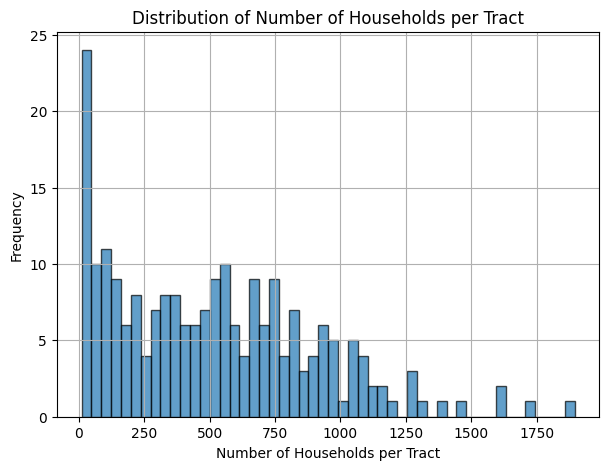

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of households per tract
household_counts = pd.Series([household[0] for household in household_data]).value_counts()

# Filter out tracts with fewer than 10 households
household_data = [household for household in household_data if household_counts[household[0]] >= 10]

# Extract the updated tract IDs from the filtered household_data
tract_ids = [household[0] for household in household_data]

# Count the number of households in each tract (after filtering)
household_counts = pd.Series(tract_ids).value_counts()

# Function to plot histogram
def plot_distribution(data, variable_name, bins=50):
    """
    Plots the distribution of a given variable.
    
    Parameters:
    data (array-like): The data to be plotted (list, array, or pandas column).
    variable_name (str): The name of the variable for labeling purposes.
    bins (int): Number of bins for the histogram (default is 50).
    """
    plt.figure(figsize=(7, 5))
    plt.hist(data, bins=bins, alpha=0.7, edgecolor='black')
    plt.xlabel(variable_name)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {variable_name}")
    plt.grid(True)
    plt.show()

# Plot the distribution of the number of households per tract
plot_distribution(household_counts, "Number of Households per Tract")


### Plotting Distributions of Various Variables

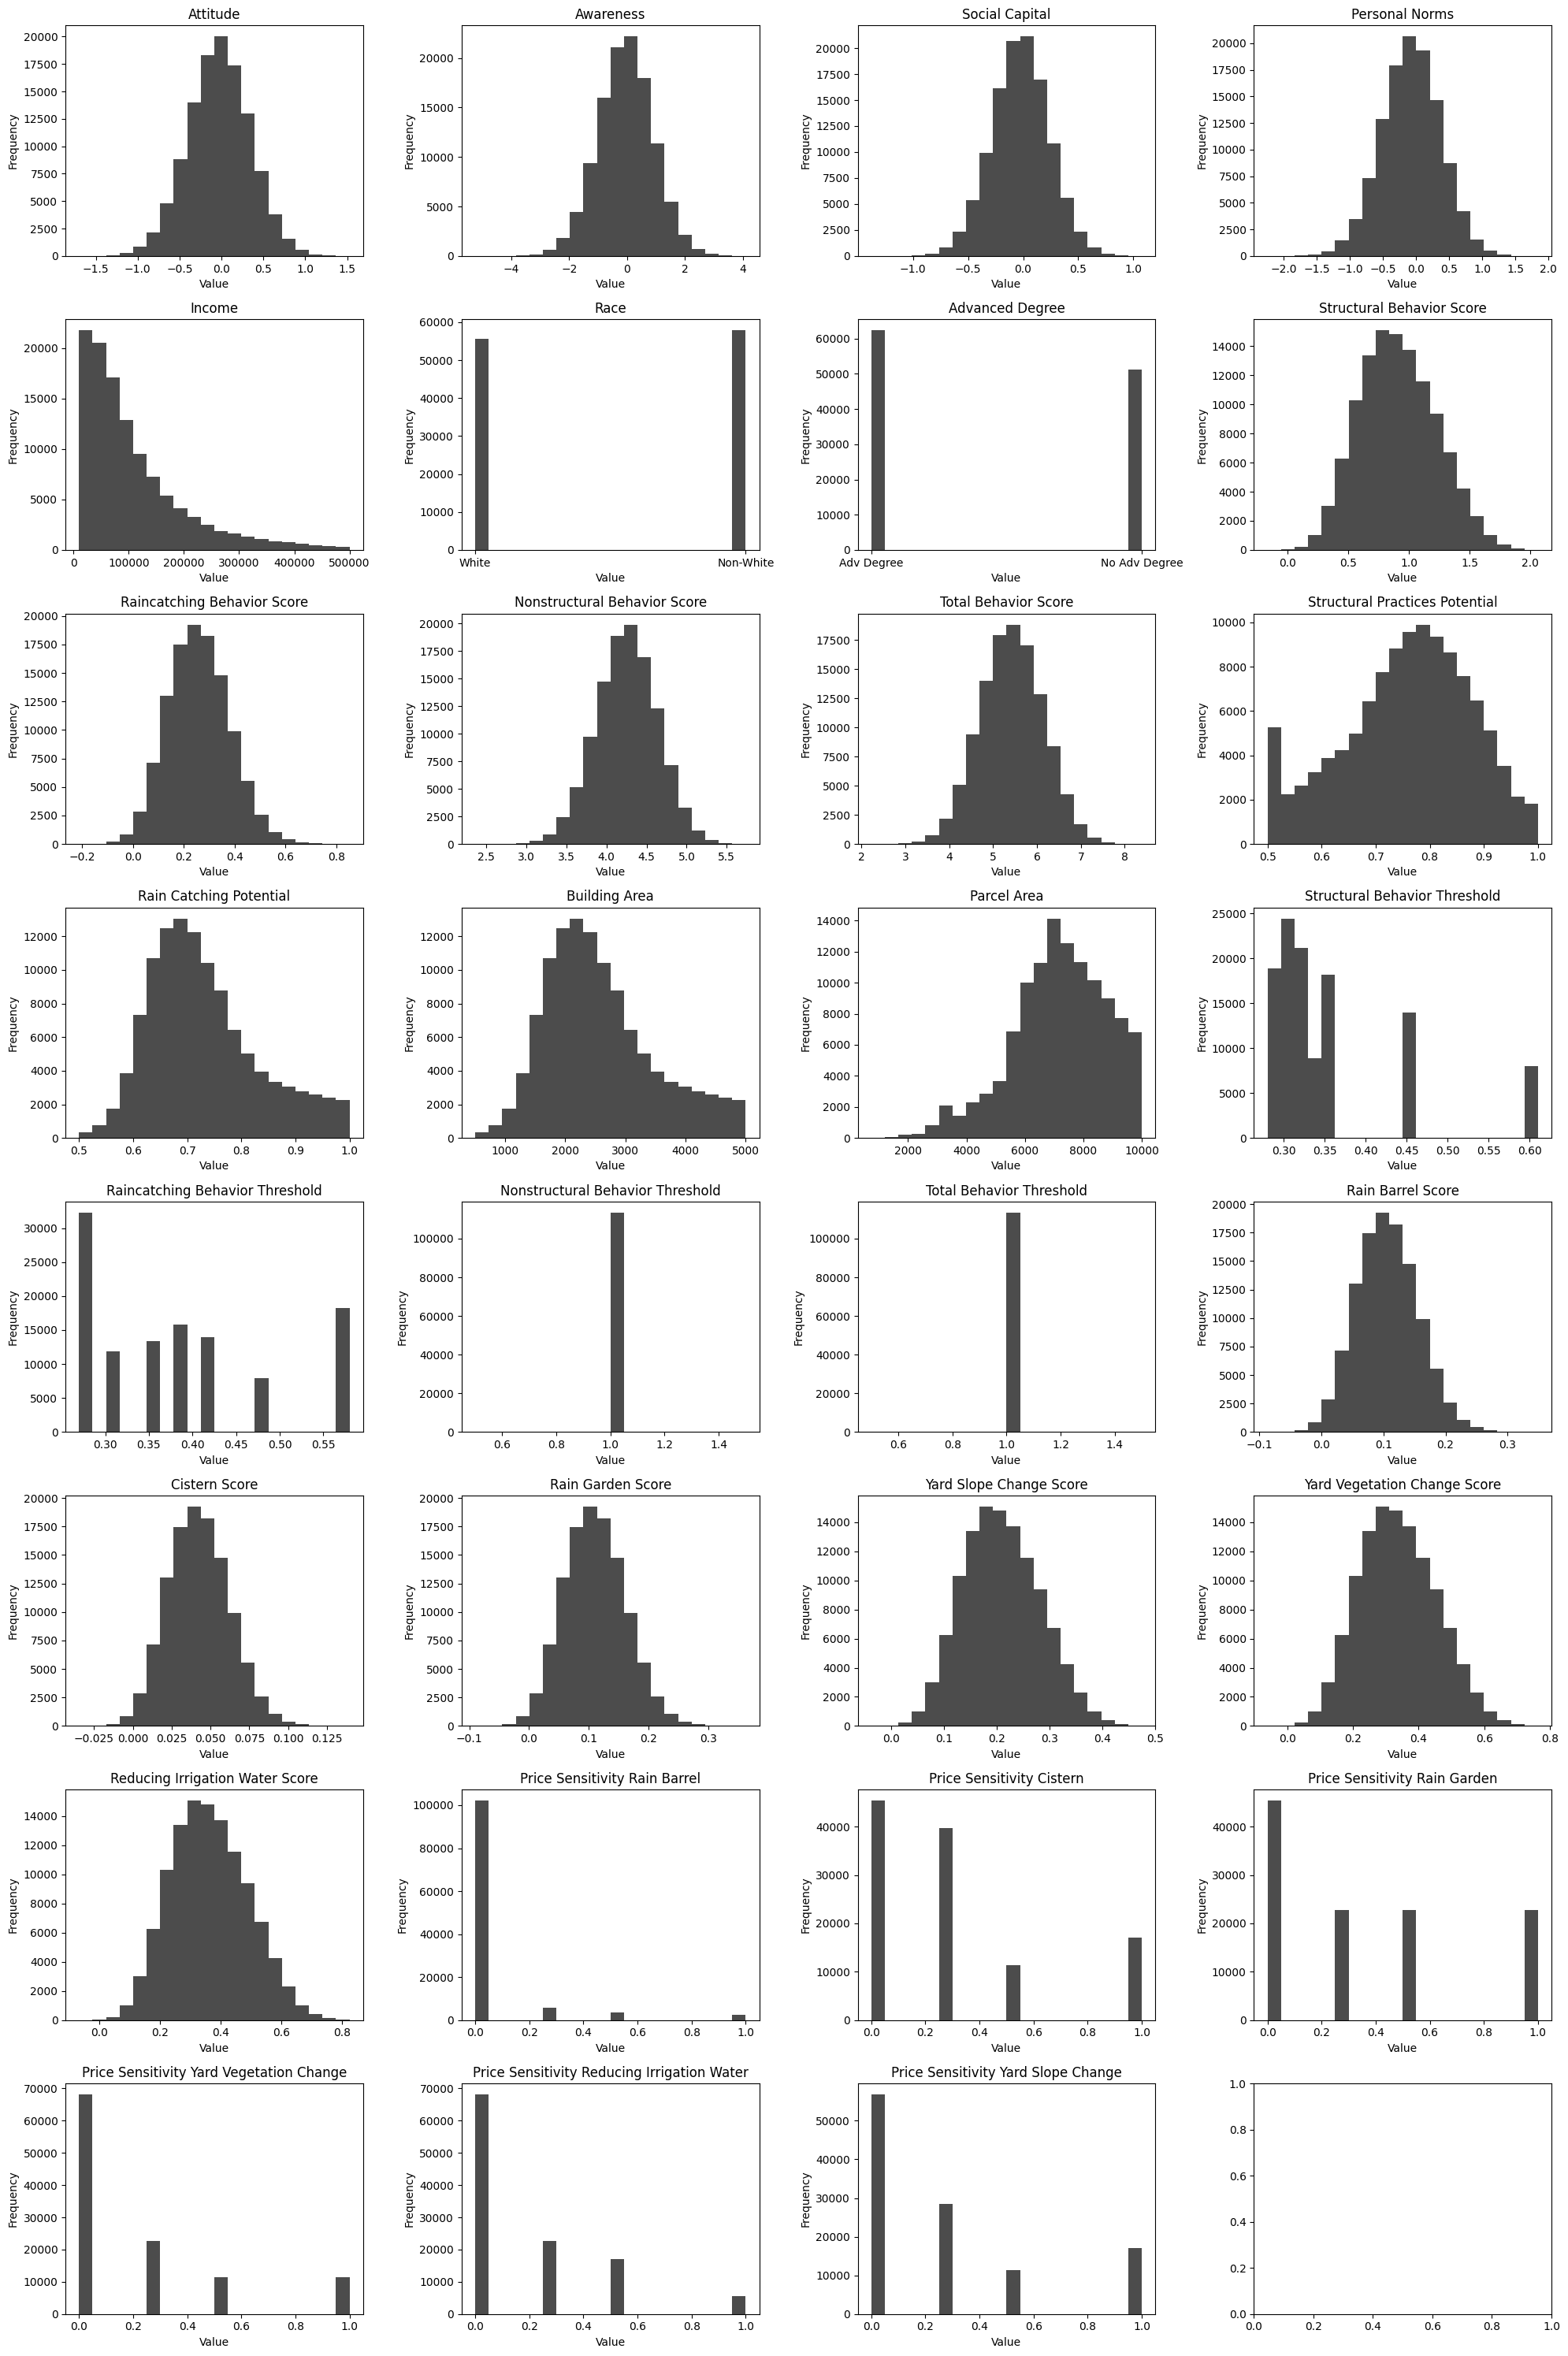

In [14]:
import matplotlib.pyplot as plt

# Variable names based on the provided indices, corresponding to columns 2 to 32
variable_names = [
    'Attitude', 'Awareness', 'Social Capital', 'Personal Norms', 'Income', 'Race', 'Advanced Degree',
    'Structural Behavior Score', 'Raincatching Behavior Score', 'Nonstructural Behavior Score', 'Total Behavior Score',
    'Structural Practices Potential', 'Rain Catching Potential', 'Building Area', 'Parcel Area',
    'Structural Behavior Threshold', 'Raincatching Behavior Threshold', 'Nonstructural Behavior Threshold',
    'Total Behavior Threshold', 'Rain Barrel Score', 'Cistern Score', 'Rain Garden Score',
    'Yard Slope Change Score', 'Yard Vegetation Change Score', 'Reducing Irrigation Water Score',
    'Price Sensitivity Rain Barrel', 'Price Sensitivity Cistern', 'Price Sensitivity Rain Garden',
    'Price Sensitivity Yard Vegetation Change', 'Price Sensitivity Reducing Irrigation Water', 'Price Sensitivity Yard Slope Change'
]

# Plotting the variables from index 2 to 32 (inclusive)
variables_to_plot = [[row[i] for row in household_data] for i in range(2, 33)]  # Extract columns 2 to 32

# Create the plot with 4 plots per row (8 rows total to cover all 31 variables)
fig, axs = plt.subplots(8, 4, figsize=(20, 30))

for i, ax in enumerate(axs.flatten()[:len(variables_to_plot)]):
    ax.hist(variables_to_plot[i], bins=20, color='black', alpha=0.7)
    ax.set_title(variable_names[i])
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [15]:
# =========================================
# Cell 1 · Agent class (Household) + helpers
# =========================================
import math
import random
import numpy as np
from mesa import Agent

# -----------------------------------------------------------------------------#
# Layer flags
# -----------------------------------------------------------------------------#
LAYER_ORDER = ["L0","L1.1","L1.2","L1.3","L2","L3.1","L3.2","L3.3","L3.4","L4"]
LAYER_FLAGS = {
    "L0":   dict(suit=False, aff=False, L2=False, L3_1=False, L3_2=False, L3_3=False, L4=False),
    "L1.1": dict(suit=True,  aff=False, L2=False, L3_1=False, L3_2=False, L3_3=False, L4=False),
    "L1.2": dict(suit=False, aff=True,  L2=False, L3_1=False, L3_2=False, L3_3=False, L4=False),
    "L1.3": dict(suit=True,  aff=True,  L2=False, L3_1=False, L3_2=False, L3_3=False, L4=False),
    "L2":   dict(suit=True,  aff=True,  L2=True,  L3_1=False, L3_2=False, L3_3=False, L4=False),
    "L3.1": dict(suit=True,  aff=True,  L2=False, L3_1=True,  L3_2=False, L3_3=False, L4=False),
    "L3.2": dict(suit=True,  aff=True,  L2=False, L3_1=False, L3_2=True,  L3_3=False, L4=False),
    "L3.3": dict(suit=True,  aff=True,  L2=False, L3_1=False, L3_2=False, L3_3=True,  L4=False),
    "L3.4": dict(suit=True,  aff=True,  L2=True,  L3_1=True,  L3_2=True,  L3_3=True,  L4=False),
    "L4":   dict(suit=True,  aff=True,  L2=True,  L3_1=True,  L3_2=True,  L3_3=True,  L4=True),
}

# Your input row schema
household_data_indices = {
    'tract_id': 0,
    'GEOID': 1,
    'attitude': 2,
    'awareness': 3,
    'social_capital': 4,
    'personal_norms': 5,
    'income': 6,
    'race': 7,
    'adv_degree': 8,
    'structural_practices_potential': 13,
    'rain_catching_potential': 14,
    'structural_behavior_threshold': 17,
    'raincatching_behavior_threshold': 18,
    'price_sensitivity_rain_barrel': 27,
    'price_sensitivity_cistern': 28,
    'price_sensitivity_rain_garden': 29,
    'price_sensitivity_yard_vegetation_change': 30,
    'price_sensitivity_reducing_irrigation_water': 31,
    'price_sensitivity_yard_slope_change': 32,
}

class Household(Agent):
    """
    Agent with:
      - L2: social-capital dynamics only (smooth logistic, small amplitude).
      - L3 channels: Awareness (W), Norms (N), Attitudes (A) with complex-contagion gates.
      - Adoption via fixed-draw RUM, with suitability/affordability filters.
      - L4 (optional): within-step SEM spillovers applied to deltas.
      - Reconsideration windows open ONLY when a latent actually changes by ≥ ε (per channel).
    """

    def __init__(self, unique_id, model, household_data, experiment_layer="L0"):
        super().__init__(unique_id, model)
        self.layer = experiment_layer

        # core attributes
        self.tract_id   = str(household_data[household_data_indices['tract_id']])
        self.income     = float(household_data[household_data_indices['income']])
        self.race       = household_data[household_data_indices['race']]
        self.adv_degree = household_data[household_data_indices['adv_degree']]
        adv_str = str(self.adv_degree).strip().lower()
        self._has_adv_degree = adv_str.startswith("adv") or adv_str in {"1","true","yes"}

        # feasibility & thresholds
        self.structural_practices_potential = float(household_data[household_data_indices['structural_practices_potential']])
        self.rain_catching_potential        = float(household_data[household_data_indices['rain_catching_potential']])
        self.thresholds = {
            'structural':   float(household_data[household_data_indices['structural_behavior_threshold']]),
            'raincatching': float(household_data[household_data_indices['raincatching_behavior_threshold']]),
        }

        # affordability
        self.price_sensitivity = {
            'rain_barrel':               float(household_data[household_data_indices['price_sensitivity_rain_barrel']]),
            'cistern':                   float(household_data[household_data_indices['price_sensitivity_cistern']]),
            'rain_garden':               float(household_data[household_data_indices['price_sensitivity_rain_garden']]),
            'yard_vegetation_change':    float(household_data[household_data_indices['price_sensitivity_yard_vegetation_change']]),
            'reducing_irrigation_water': float(household_data[household_data_indices['price_sensitivity_reducing_irrigation_water']]),
            'yard_slope_change':         float(household_data[household_data_indices['price_sensitivity_yard_slope_change']]),
        }
        self.structural_practices_importance = {"yard_slope_change": 0.23, "yard_vegetation_change": 0.37, "reducing_irrigation_water": 0.40}
        self.rain_catching_importance        = {"rain_barrel": 0.75, "cistern": 0.30, "rain_garden": 0.78}

        # latents history (A,N,W,S)
        base_att = float(household_data[household_data_indices['attitude']])
        base_awa = float(household_data[household_data_indices['awareness']])
        base_pn  = float(household_data[household_data_indices['personal_norms']])
        base_sc  = float(household_data[household_data_indices['social_capital']])
        self.latent_variables_history = {
            'attitude':       {'structural': [base_att], 'raincatching': [base_att]},
            'awareness':      {'structural': [base_awa], 'raincatching': [base_awa]},
            'personal_norms': {'structural': [base_pn],  'raincatching': [base_pn]},
            'social_capital': {'structural': [base_sc],  'raincatching': [base_sc]},
        }
        self._S_init = {'structural': base_sc, 'raincatching': base_sc}

        # adoption flags + history
        self.adoption_flags = {'structural': False, 'raincatching': False}
        self.adoption_flags_history = {b: [False] for b in self.adoption_flags}

        # toggles by layer
        if self.layer not in LAYER_FLAGS:
            raise ValueError(f"Unknown experiment_layer '{self.layer}'.")
        f = LAYER_FLAGS[self.layer]
        self.use_suitability   = f["suit"]
        self.use_affordability = f["aff"]
        self.layer2_active     = f["L2"]
        self.layer3_1_active   = f["L3_1"]  # awareness
        self.layer3_2_active   = f["L3_2"]  # norms
        self.layer3_3_active   = f["L3_3"]  # attitudes
        self.layer4_active     = f["L4"]    # SEM cross-talk

        # ---------------------------------------------
        # Exposure (neutral) & ties (used by attitudes)
        # Keep these neutral; no empirical "credibility" factors in baseline.
        # Optional "ambassador" boost is handled via model flags.
        self.v_type = 1.0
        self.c_type = 1.0
        self.eafi   = 1.0
        self.S_uit  = 1.0
        self.tie_strength = {}   # neighbor_id -> [0,1]
        # ---------------------------------------------

        # network lists
        self.social_contacts = []
        self.contact_method  = None

        # S-process params injected by model
        self.network_influence_rate      = 0.0
        self.neighborhood_influence_rate = 0.0
        self.SC_DECAY_RATE               = 0.0
        self.K                           = 1.0

        # event memory for awareness
        self._seen_local_adopters  = {'structural': set(), 'raincatching': set()}
        self._seen_social_adopters = {'structural': set(), 'raincatching': set()}
        self._seen_local_ts  = {'structural': {}, 'raincatching': {}}
        self._seen_social_ts = {'structural': {}, 'raincatching': {}}

        # reconsideration windows (with cap)
        self._l3_can_reconsider = {'structural': False, 'raincatching': False}
        self._reconsider_until_t = {'structural': -1, 'raincatching': -1}
        self._reconsider_extend_count = {'structural': 0, 'raincatching': 0}
        self._reconsider_max_ext = getattr(model, "reconsider_max_extensions", None)  # None = infinite

        self._awareness_ever_passed = {'structural': False, 'raincatching': False}
        self.steps_since_last_awareness_event = {'structural': 0, 'raincatching': 0}

        # awareness novelty memory
        self._novelty_W_mem = {'structural': 0.0, 'raincatching': 0.0}

        # next-state buffer
        self._next_z = {'structural': None, 'raincatching': None}

        # RUM random utility
        beta = getattr(model, "rum_beta", 0.15)
        self._rum_eps = {
            'structural':   float(np.random.gumbel(loc=0.0, scale=beta)),
            'raincatching': float(np.random.gumbel(loc=0.0, scale=beta)),
        }
        self._theta_star = {'structural': None, 'raincatching': None}

        # tiny per-agent ramp jitter
        jr = float(getattr(model, "ramp_jitter_range", 0.0))
        self._ramp_jitter = {
            'awareness':      random.uniform(-jr, jr),
            'personal_norms': random.uniform(-jr, jr),
            'attitude':       random.uniform(-jr, jr),
        }

        # heterogeneous gates (beta draws)
        if getattr(model, "hetero_gates", True):
            def _beta(mean, kappa):
                a = max(1e-6, mean*kappa); b = max(1e-6, (1-mean)*kappa)
                return float(np.random.beta(a,b))
            μW = float(getattr(model, "gate_aw_min_prev_mean", 0.30))
            μN = float(getattr(model, "gate_n_min_prev_sim_mean", 0.40))
            μA = float(getattr(model, "gate_a_min_cred_mean", 0.40))  # kept name for compat; acts as A-exposure threshold
            κ  = float(getattr(model, "gate_concentration", 20.0))
            self.tau_W_prev     = _beta(μW, κ)
            self.tau_N_prev_sim = _beta(μN, κ)
            self.tau_A_cred     = _beta(μA, κ)
            self.kW = int(np.random.choice(tuple(getattr(model,"k_w_choices",(2,3))),
                                           p=tuple(getattr(model,"k_w_probs",(0.7,0.3)))))
        else:
            self.tau_W_prev     = float(getattr(model, "gate_aw_min_prev", 0.30))
            self.tau_N_prev_sim = float(getattr(model, "gate_n_min_prev_sim", 0.40))
            self.tau_A_cred     = float(getattr(model, "gate_a_min_cred", 0.40))
            self.kW = int(getattr(model, "gate_aw_min_new", 2))

    # ---- RUM helper
    def finalize_rum(self):
        kappa = max(1e-9, float(getattr(self.model, "rum_kappa", 8)))
        bdmap = getattr(self.model, "bd_by_district", {})
        b_d   = float(bdmap.get(getattr(self, "DistrictID", "Unknown"), 0.0))
        self._rum_bd = b_d
        for beh in ('structural','raincatching'):
            theta = self.thresholds[beh]; eps = self._rum_eps[beh]
            self._theta_star[beh] = float(theta - (b_d + eps)/kappa)

    @staticmethod
    def _sigmoid(x): return 1.0/(1.0+math.exp(-x))

    # ---- Feasibility + affordability
    def compute_suitability(self, behavior):
        if not self.use_suitability: return 1.0
        return self.structural_practices_potential if behavior=='structural' else self.rain_catching_potential

    def _practice_weights(self, behavior):
        base = self.structural_practices_importance if behavior=='structural' else self.rain_catching_importance
        tot = sum(float(v) for v in base.values()) if base else 0.0
        if tot <= 0: return {k:0.0 for k in base.keys()}
        return {k: float(v)/tot for k,v in base.items()}

    def affordability_gate(self, value, behavior, threshold=0.60):
        eff = threshold
        pol = getattr(self.model, "policy", {})
        sub = pol.get("subsidy", {})
        if sub.get("active", False) and getattr(self, "DistrictID", None) in sub.get("district_ids", set()):
            t = getattr(self.model,"t",0)
            if sub.get("t_start",-1) <= t <= sub.get("t_end",-1):
                eff = max(threshold, sub.get("threshold", threshold))
        weights = self._practice_weights(behavior)
        dropped = {k:w for k,w in weights.items() if self.price_sensitivity.get(k,1.0) > eff}
        kept    = {k:w for k,w in weights.items() if k not in dropped}
        feasible_frac = max(0.0, 1.0 - sum(dropped.values()))
        return value*feasible_frac, feasible_frac, dropped, kept

    # ---- Intention
    def compute_intention(self, behavior):
        w = self.model.intent_weights[behavior]
        A = self.latent_variables_history['attitude'][behavior][-1]
        N = self.latent_variables_history['personal_norms'][behavior][-1]
        W = self.latent_variables_history['awareness'][behavior][-1]
        S = self.latent_variables_history['social_capital'][behavior][-1]
        return w['A']*A + w['N']*N + w['W']*W + w['S']*S

    # ---- Pair tie strength (uses cached dist/sim)
    def _pair_tie_strength(self, other):
        try:
            sim = self.model.sim(self, other)
        except Exception:
            sim = 0.5
        try:
            d = self.model.dist(self, other)
            dist_w = 1.0/(1.0 + (d ** 1.2))
        except Exception:
            dist_w = 0.6
        inner = 1.15 if other in (self.social_contacts or []) else 1.0
        w = inner*(0.6*sim + 0.4*dist_w)
        return max(0.0, min(1.0, w))

    # ---- Gating info (no side-effects)
    def _gating_info(self, behavior, locals_, socials):
        # adopters in rings
        local_ids  = {n.unique_id for n in locals_  if n.adoption_flags[behavior]}
        social_ids = {n.unique_id for n in socials  if n.adoption_flags[behavior]}
        # prevalence in rings
        nb_rate  = (len(local_ids)/len(locals_)) if locals_ else 0.0
        soc_rate = (len(social_ids)/len(socials)) if socials else 0.0
        prev_mix_ring = self.model.phi*nb_rate + (1.0-self.model.phi)*soc_rate

        # NEW sources this step
        new_local_ids  = local_ids  - self._seen_local_adopters[behavior]
        new_social_ids = social_ids - self._seen_social_adopters[behavior]

        # Awareness gate: k distinct recent sources OR prevalence above τ
        kW     = int(getattr(self,"kW",2))
        window = int(getattr(self.model,"gate_window",8))
        tnow   = int(getattr(self.model,"t",0))
        recent_ids = set()
        for uid,ts in self._seen_local_ts[behavior].items():
            if tnow - ts <= window: recent_ids.add(uid)
        for uid,ts in self._seen_social_ts[behavior].items():
            if tnow - ts <= window: recent_ids.add(uid)
        recent_ids |= new_local_ids | new_social_ids
        tau_W_prev = float(getattr(self,"tau_W_prev", getattr(self.model,"gate_aw_min_prev",0.30)))
        pass_W = self.layer3_1_active and ((len(recent_ids) >= kW) or (prev_mix_ring >= tau_W_prev))

        # similarity-weighted prevalence over neighbors (cached sim)
        def _sim_prevalence(neighs):
            num = den = 0.0
            for n in neighs:
                w = self.model.sim(self, n)
                y = 1.0 if n.adoption_flags[behavior] else 0.0
                num += w*y; den += w
            return (num/den) if den>0 else 0.0

        prev_sim_loc = _sim_prevalence(locals_)
        prev_sim_soc = _sim_prevalence(socials)
        prev_sim_ring = self.model.phi*prev_sim_loc + (1.0-self.model.phi)*prev_sim_soc

        # injunctive (inner circle N), similarity-weighted
        def _inj_contacts_mean():
            neighs = self.social_contacts or []
            if not neighs: return 0.0
            cap = float(getattr(self.model,"latent_cap",1.0) or 1.0)
            num = den = 0.0
            for n in neighs:
                Nj = n.latent_variables_history['personal_norms'][behavior][-1]
                Nj01 = 0.5 + 0.5*max(-cap, min(Nj,cap))/cap
                w = self.model.sim(self, n)
                num += w*Nj01; den += w
            return (num/den) if den>0 else 0.0

        inj_contacts = _inj_contacts_mean()
        mix = float(getattr(self.model,"gate_n_mix_inj",0.35))
        gate_N_metric = (1.0 - mix)*prev_sim_ring + mix*inj_contacts
        tau_N = float(getattr(self,"tau_N_prev_sim", getattr(self.model,"gate_n_min_prev_sim", 0.40)))
        raw_pass_N = self.layer3_2_active and (gate_N_metric >= tau_N)

        # ---------------------------------------------
        # A-channel "exposure" signal (adopters only)
        # Weight = tie strength × (optional) distance decay × (optional) ambassador boost
        def _a_exposure(neighs, use_dist=True):
            num = den = 0.0
            for n in neighs:
                if not n.adoption_flags[behavior]:
                    continue
                ts = self.tie_strength.get(n.unique_id, 0.6)
                w_dist = 1.0
                if use_dist:
                    d = self.model.dist(self, n)
                    w_dist = 1.0 / (1.0 + d)
                mult = 1.0
                if getattr(self.model, "use_credibility", False):
                    if n.unique_id in getattr(self.model, "ambassadors", set()):
                        mult *= float(getattr(self.model, "cred_multiplier", 1.6))
                w = ts * w_dist * mult

                Aj = n.latent_variables_history['attitude'][behavior][-1]
                Aj01 = 1.0/(1.0 + math.exp(-Aj))
                num += w * Aj01
                den += w
            return (num/den) if den > 0 else 0.0
        # ---------------------------------------------

        exp_loc_ring = _a_exposure(locals_, use_dist=True)
        exp_soc_ring = _a_exposure(socials, use_dist=False)
        expo_any = min(1.0, self.model.phi*exp_loc_ring + (1.0-self.model.phi)*exp_soc_ring)
        tau_A = float(getattr(self,"tau_A_cred", getattr(self.model,"gate_a_min_cred", 0.40)))  # threshold on exposure
        raw_pass_A = self.layer3_3_active and (expo_any >= tau_A)

        return dict(
            new_local_ids=new_local_ids, new_social_ids=new_social_ids,
            nb_rate=nb_rate, soc_rate=soc_rate, prev_mix_ring=prev_mix_ring,
            raw_pass_N=raw_pass_N, raw_pass_A=raw_pass_A, pass_W=pass_W
        )


    # ---- L2 delta (Social Capital) — smoother + smaller via shifted logistic
    def _compute_sc_delta(self, behavior, locals_, socials):
        """L2 · Social capital change with personal/district/blend baseline
           + conditional reversion (only when signal is weak)
           + centered saturation around the chosen baseline.
        """
        S0 = self.latent_variables_history['social_capital'][behavior][-1]
        if not self.layer2_active:
            return 0.0, S0, False

        # Adoption rates (signal)
        nb_rate  = (sum(1 for n in locals_  if n.adoption_flags[behavior]) / len(locals_))  if locals_  else 0.0
        soc_rate = (sum(1 for n in socials  if n.adoption_flags[behavior]) / len(socials))  if socials  else 0.0
        inner_rate = (sum(1 for n in self.social_contacts if n.adoption_flags[behavior]) /
                      len(self.social_contacts)) if self.social_contacts else 0.0

        if (nb_rate == 0.0) and (soc_rate == 0.0) and (inner_rate == 0.0):
            return 0.0, S0, False

        # --- choose baseline μ around which S saturates/reverts
        mode   = getattr(self.model, "sc_baseline_mode", "personal")
        mu_p   = float(self._S_init[behavior])  # personal baseline (t=0)
        mu_d   = float(getattr(self.model, "sc_baseline_by_district", {}).get(self.DistrictID, mu_p))

        if mode == "district":
            mu = mu_d
        elif mode == "blend":
            w  = float(getattr(self.model, "sc_baseline_blend_w", 0.7))
            mu = w*mu_p + (1.0-w)*mu_d
        else:  # "personal"
            mu = mu_p

        # --- smoothed logistic mapping of adoption shares
        m  = float(getattr(self.model, "sc_logit_mid",   0.15))
        w  = float(getattr(self.model, "sc_logit_width", 0.12))
        def _logit(x): return 1.0/(1.0 + math.exp(-(x - m)/max(1e-9, w)))

        w_nb    = float(getattr(self.model, "sc_w_nb",    0.50))
        w_soc   = float(getattr(self.model, "sc_w_soc",   0.30))
        w_inner = float(getattr(self.model, "sc_w_inner", 0.20))
        ws = max(1e-9, (w_nb + w_soc + w_inner))
        w_nb, w_soc, w_inner = w_nb/ws, w_soc/ws, w_inner/ws

        f_nb, f_soc, f_inner = _logit(nb_rate), _logit(soc_rate), _logit(inner_rate)
        blended_sig = (w_nb*f_nb + w_soc*f_soc + w_inner*f_inner)

        # centered saturation around μ (not zero)
        S_MAX = float(getattr(self.model, "sc_cap", 1.0))
        sat   = max(0.0, 1.0 - abs(S0 - mu)/max(1e-9, S_MAX))

        # peer gain scale (small but not dominated by reversion)
        peer_amp = float(getattr(self.model, "sc_peer_gain_max", 0.008))
        peer_gain = peer_amp * blended_sig * sat

        # small synergy if ego already adopted (optional)
        gamma_syn = float(getattr(self.model, "sc_synergy", 0.003))
        raw_blend = (w_nb*nb_rate + w_soc*soc_rate + w_inner*inner_rate)
        ego = 1.0 if self.adoption_flags[behavior] else 0.0
        synergy = gamma_syn * ego * raw_blend * sat

        # conditional reversion: only when local signal is weak
        floor = float(getattr(self.model, "sc_reversion_floor", 0.02))
        kappa = float(getattr(self.model, "sc_kappa", 0.06))
        # adopters drift back more slowly (trait reinforcement)
        kappa *= float(getattr(self.model, "sc_kappa_adopter_mult", 0.6)) if ego > 0 else 1.0
        reversion = kappa * (mu - S0) if raw_blend < floor else 0.0

        noise = float(getattr(self.model, "sc_noise", 0.00005))
        delta = peer_gain + synergy + reversion + random.uniform(-noise, noise)
        S1 = max(-S_MAX, min(S0 + delta, S_MAX))
        return (S1 - S0), S1, True


    # ---- L3 deltas (A, N, W)
    def _compute_L3_deltas(self, behavior, locals_, socials, gates):
        A0 = float(self.latent_variables_history['attitude'][behavior][-1])
        N0 = float(self.latent_variables_history['personal_norms'][behavior][-1])
        W0 = float(self.latent_variables_history['awareness'][behavior][-1])

        # ramps with jitter
        aW, bW = self.model.mixing_gains('awareness',      self)
        aN, bN = self.model.mixing_gains('personal_norms', self)
        aA, bA = self.model.mixing_gains('attitude',       self)

        bW_net = float(getattr(self.model, "beta_net_W", self.model.beta_net))
        bN_net = float(getattr(self.model, "beta_net_N", self.model.beta_net))
        bA_net = float(getattr(self.model, "beta_net_A", self.model.beta_net))

        epsW = getattr(self.model,"bconf_eps_W",None)
        epsN = getattr(self.model,"bconf_eps_N",None)
        epsA = getattr(self.model,"bconf_eps_A",None)

        # dedupe contacts from rings
        locals_set  = set(locals_) if locals_ else set()
        socials_set = set(socials) if socials else set()
        ring_set    = locals_set | socials_set
        contacts_unique = [c for c in (self.social_contacts or []) if c not in ring_set]

        phi = float(self.model.phi)
        rho_W = float(getattr(self.model,"dist_rho_W",1.2))
        rho_A = float(getattr(self.model,"dist_rho_A",1.6))
        psiW  = float(getattr(self.model,"contact_blend_w",0.35))
        psiN  = float(getattr(self.model,"contact_blend_n",0.45))
        psiA  = float(getattr(self.model,"contact_blend_a",0.38))
        lam   = float(getattr(self.model,"contact_sig_amp",1.10))

        def _dist_w(d, rho): return 1.0/(1.0 + (d**rho))

        def _aw_signal(neighs, rho):
            s = 0.0
            for n in neighs:
                if not n.adoption_flags[behavior]: continue
                d = self.model.dist(self, n)
                s += _dist_w(d, rho)
            return 1.0 - math.exp(-s)

        def _norm_signal_rings(neighs):
            num = den = 0.0
            for n in neighs:
                w = self.model.sim(self, n)
                y = 1.0 if n.adoption_flags[behavior] else 0.0
                num += w*y; den += w
            return (num/den) if den>0 else 0.0

        def _norm_signal_contacts(neighs):
            cap = float(getattr(self.model,"latent_cap",1.0) or 1.0)
            num = den = 0.0
            for n in neighs:
                Nj = n.latent_variables_history['personal_norms'][behavior][-1]
                Nj01 = 0.5 + 0.5*max(-cap, min(Nj,cap))/cap
                w = self.model.sim(self, n)
                num += w*Nj01; den += w
            return (num/den) if den>0 else 0.0

        # ---------------------------------------------
        # A-channel signal for deltas: exposure-based (optionally boosted for ambassadors)
        def _att_signal(neighs, rho):
            num = den = 0.0
            for n in neighs:
                Aj = n.latent_variables_history['attitude'][behavior][-1]
                Aj01 = 1.0/(1.0 + math.exp(-Aj))
                # Optional weak filter: if non-adopter and attitude is low, skip (keeps "complex contagion" flavor)
                if (not n.adoption_flags[behavior]) and Aj01 < 0.7:
                    continue
                ts = self.tie_strength.get(n.unique_id, 0.6)
                d = self.model.dist(self, n)
                w = ts * _dist_w(d, rho)
                if getattr(self.model, "use_credibility", False):
                    if n.unique_id in getattr(self.model, "ambassadors", set()):
                        w *= float(getattr(self.model, "cred_multiplier", 1.6))
                num += w*Aj01; den += w
            return (num/den) if den>0 else 0.0
        # ---------------------------------------------

        locals_sig = {'W': _aw_signal(locals_, rho_W),
                      'N': _norm_signal_rings(locals_),
                      'A': _att_signal(locals_, rho_A)}
        socials_sig = {'W': _aw_signal(socials, rho_W),
                       'N': _norm_signal_rings(socials),
                       'A': _att_signal(socials, rho_A)}
        ring_mix = {k: phi*locals_sig[k] + (1.0 - phi)*socials_sig[k] for k in ('W','N','A')}

        contacts_sig = {
            'W': _aw_signal(contacts_unique, rho_W) if contacts_unique else 0.0,
            'N': _norm_signal_contacts(contacts_unique) if contacts_unique else 0.0,
            'A': _att_signal(contacts_unique, rho_A) if contacts_unique else 0.0,
        }

        SigW = (1.0 - psiW)*ring_mix['W'] + psiW*min(1.0, lam*contacts_sig['W'])
        SigN = (1.0 - psiN)*ring_mix['N'] + psiN*min(1.0, lam*contacts_sig['N'])
        SigA = (1.0 - psiA)*ring_mix['A'] + psiA*min(1.0, lam*contacts_sig['A'])
        SigW = max(0.0, min(1.0, SigW))
        SigN = max(0.0, min(1.0, SigN))
        SigA = max(0.0, min(1.0, SigA))

        # Awareness novelty memory
        delta_new = len(gates['new_local_ids']) + len(gates['new_social_ids'])
        alpha = float(getattr(self.model,"awareness_novelty_alpha",1.0))
        decay = float(getattr(self.model,"awareness_novelty_decay",0.88))
        inc = 1.0 - math.exp(-alpha*float(delta_new))
        self._novelty_W_mem[behavior] = decay*self._novelty_W_mem[behavior] + inc
        SigW = min(1.0, SigW + float(getattr(self.model,"awareness_novelty_boost",0.22))*self._novelty_W_mem[behavior])

        # prerequisites
        W_min = float(getattr(self.model,"awareness_min_floor",0.12))
        soft_floor = bool(getattr(self.model,"awareness_soft_floor",True))
        require_W_for_N = bool(getattr(self.model,"require_awareness_for_norms",False))
        require_W_for_A = bool(getattr(self.model,"require_awareness_for_attitudes",False))

        raw_pass_N = bool(gates.get('raw_pass_N', False))
        raw_pass_A = bool(gates.get('raw_pass_A', False))
        aw_ok_N = (W0 >= W_min) if require_W_for_N else True
        aw_ok_A = (W0 >= W_min) if require_W_for_A else True

        if soft_floor:
            if raw_pass_N and not aw_ok_N and require_W_for_N:
                self.latent_variables_history['awareness'][behavior][-1] = max(W0, W_min); W0 = W_min; aw_ok_N = True
                self._awareness_ever_passed[behavior] = True
            if raw_pass_A and not aw_ok_A and require_W_for_A:
                self.latent_variables_history['awareness'][behavior][-1] = max(W0, W_min); W0 = W_min; aw_ok_A = True
                self._awareness_ever_passed[behavior] = True

        pass_W = bool(gates['pass_W'])
        pass_N = self.layer3_2_active and raw_pass_N and aw_ok_N
        pass_A = self.layer3_3_active and raw_pass_A and aw_ok_A

        # deltas
        dW = dN = dA = 0.0

        if pass_W:
            W_tilde_raw = (1 - float(self.model.alpha_w))*W0 + float(self.model.alpha_w)*SigW
            L_self = (1 - aW)*W0 + aW*W_tilde_raw
            if self.social_contacts:
                vals = [n.latent_variables_history['awareness'][behavior][-1] for n in self.social_contacts]
                pool = vals if (epsW is None or float(epsW) <= 0) else [x for x in vals if abs(x - W0) <= float(epsW)]
                neigh_mean = float(np.mean(pool)) if pool else W0
            else:
                neigh_mean = W0
            new_val = (1 - bW_net*bW)*L_self + (bW_net*bW)*neigh_mean
            dW = new_val - W0

        if pass_N:
            N_tilde_raw = (1 - float(self.model.alpha_n))*N0 + float(self.model.alpha_n)*SigN
            N_tilde = max(N0, N_tilde_raw) if getattr(self.model,"l3_monotone_AN",True) else N_tilde_raw
            L_self = (1 - aN)*N0 + aN*N_tilde
            if self.social_contacts:
                vals = [n.latent_variables_history['personal_norms'][behavior][-1] for n in self.social_contacts]
                pool = vals if (epsN is None or float(epsN) <= 0) else [x for x in vals if abs(x - N0) <= float(epsN)]
                neigh_mean = float(np.mean(pool)) if pool else N0
            else:
                neigh_mean = N0
            deltaN = (1 - bN_net*bN)*L_self + (bN_net*bN)*neigh_mean - N0
            dN = deltaN if not getattr(self.model,"l3_monotone_AN",True) else max(0.0, deltaN)

        if pass_A:
            A_tilde_raw = (1 - float(self.model.alpha_a))*A0 + float(self.model.alpha_a)*SigA
            A_tilde = max(A0, A_tilde_raw) if getattr(self.model,"l3_monotone_AN",True) else A_tilde_raw
            L_self = (1 - aA)*A0 + aA*A_tilde
            if self.social_contacts:
                vals = [n.latent_variables_history['attitude'][behavior][-1] for n in self.social_contacts]
                pool = vals if (epsA is None or float(epsA) <= 0) else [x for x in vals if abs(x - A0) <= float(epsA)]
                neigh_mean = float(np.mean(pool)) if pool else A0
            else:
                neigh_mean = A0
            deltaA = (1 - bA_net*bA)*L_self + (bA_net*bA)*neigh_mean - A0
            dA = deltaA if not getattr(self.model,"l3_monotone_AN",True) else max(0.0, deltaA)

        # extra awareness decay only when prevalence is low for a while
        if pass_W:
            k = int(self.steps_since_last_awareness_event.get(behavior, 0))
            pause_prev = float(getattr(self.model,"awareness_decay_pause_prev",0.45))
            if gates['prev_mix_ring'] < pause_prev:
                if k >= int(getattr(self.model,"awareness_decay_period",6)):
                    extra = k - int(self.model.awareness_decay_period) + 1
                    dec = float(getattr(self.model,"awareness_decay_rate",0.004)) * extra
                    dW -= dec

        # ===== ADDED: layer-agnostic dampers for multi-channel co-activation =====
        # Share-out when >1 channel passes (keeps total influence comparable)
        k_pass = int(pass_W) + int(pass_N) + int(pass_A)
        if k_pass > 1:
            p = float(getattr(self.model, "l3_share_exponent", 1.0))  # 1.0 = average
            share = 1.0 / (k_pass ** max(0.0, p))
            dW *= share; dN *= share; dA *= share
    
        # Optional global budget on total L3 movement this step
        budget = getattr(self.model, "l3_delta_budget", None)  # e.g., 0.06
        if budget is not None:
            total = abs(dW) + abs(dN) + abs(dA)
            if total > budget:
                scale = budget / max(1e-9, total)
                dW *= scale; dN *= scale; dA *= scale
        # ========================================================================
    
        event_L3 = (dW != 0.0) or (dN != 0.0) or (dA != 0.0)
        return dA, dN, dW, event_L3, pass_W, pass_N, pass_A


    # ---- Adoption checks
    def _rum_should_adopt(self, beh):
        if self._theta_star[beh] is None:
            self.finalize_rum()
        I_raw = self.compute_intention(beh)
        I_eff = I_raw * (self.compute_suitability(beh) if self.use_suitability else 1.0)
        if self.use_affordability:
            I_eff, aff_frac, _, _ = self.affordability_gate(I_eff, beh, threshold=float(getattr(self.model,"affordability_threshold",0.60)))
            if aff_frac <= 0.0: return False
        return I_eff >= self._theta_star[beh]

    def _determine_adoption_once(self):
        t = int(getattr(self.model, "t", 0))

        if getattr(self.model, "baseline_mode", False):
            for beh in ('structural','raincatching'):
                if self.adoption_flags[beh]: continue
                locals_ = getattr(self.model,'local_neighbours',{}).get(self.unique_id, [])
                frac = (sum(1 for n in locals_ if n.adoption_flags[beh]) / len(locals_)) if locals_ else 0.0
                if frac >= float(getattr(self.model,"baseline_tau",0.15)):
                    self.adoption_flags[beh] = True
                    self.model.adoption_counts[self.tract_id][beh] += 1
            return

        for beh in ('structural','raincatching'):
            if self.adoption_flags[beh]: 
                continue
            if t == 0:
                if self._rum_should_adopt(beh):
                    self.adoption_flags[beh] = True
                    self.model.adoption_counts[self.tract_id][beh] += 1
                    self.model._diag["adoptions_struct" if beh=='structural' else "adoptions_rain"] += 1
                continue

            if (self.layer.startswith("L2") or self.layer.startswith("L3") or self.layer == "L4"):
                if self._l3_can_reconsider[beh] and (t <= int(self._reconsider_until_t.get(beh, -1))):
                    if self._rum_should_adopt(beh):
                        self.adoption_flags[beh] = True
                        self.model.adoption_counts[self.tract_id][beh] += 1
                        self.model._diag["adoptions_struct" if beh=='structural' else "adoptions_rain"] += 1

    # ---- Decide/apply
    def decide(self):
        locals_ = getattr(self.model,'local_neighbours',{}).get(self.unique_id, [])
        socials = getattr(self.model,'social_neighbours',{}).get(self.unique_id, [])

        S_MAX      = float(getattr(self.model,"sc_cap",1.0))
        latent_cap = getattr(self.model,"latent_cap",None)
        sem_mode   = str(getattr(self.model,"sem_mode","event"))
        sem_monot_AN  = bool(getattr(self.model,"l3_monotone_AN",True))
        latent_step_cap = getattr(self.model,"latent_step_cap",None)
        sc_step_cap     = getattr(self.model,"sc_step_cap",None)

        for beh in ('structural','raincatching'):
            g = self._gating_info(beh, locals_, socials)

            # bookkeeping for W
            if self.layer3_1_active:
                if g['pass_W'] and (len(g['new_local_ids']) + len(g['new_social_ids']) > 0):
                    self.steps_since_last_awareness_event[beh] = 0
                    self._awareness_ever_passed[beh] = True
                else:
                    self.steps_since_last_awareness_event[beh] = int(self.steps_since_last_awareness_event.get(beh,0)) + 1

            # deltas
            dS, S1, event_L2 = self._compute_sc_delta(beh, locals_, socials)
            dA, dN, dW, event_L3, passW, passN, passA = self._compute_L3_deltas(beh, locals_, socials, g)

            # ---- Reconsideration opens only on actual movement (≥ ε)
            rec_eps_W = float(getattr(self.model, "rec_eps_W", 0.005))
            rec_eps_N = float(getattr(self.model, "rec_eps_N", 0.005))
            rec_eps_A = float(getattr(self.model, "rec_eps_A", 0.005))
            rec_eps_S = float(getattr(self.model, "rec_eps_S", 0.001))

            open_due_L3 = ((passW and abs(dW) >= rec_eps_W) or
                           (passN and abs(dN) >= rec_eps_N) or
                           (passA and abs(dA) >= rec_eps_A))
            open_due_L2 = (getattr(self.model,"l2_unlocks_reconsideration",True) and (abs(dS) >= rec_eps_S))

            # isolate single-channel runs: disable L2-initiated reconsideration in L3.1/.2/.3
            if self.layer in ("L3.1","L3.2","L3.3"):
                open_due_L2 = False

            if open_due_L3 or open_due_L2:
                horizon = int(getattr(self.model, "reconsider_horizon", 3))
                tnow = int(getattr(self.model, "t", 0))
                prev_until = int(self._reconsider_until_t.get(beh, -1))
                if tnow > prev_until:
                    self._l3_can_reconsider[beh] = True
                    self._reconsider_until_t[beh] = tnow + horizon
                    self._reconsider_extend_count[beh] = 1
                else:
                    if (self._reconsider_max_ext is None) or (self._reconsider_extend_count[beh] < int(self._reconsider_max_ext)):
                        self._l3_can_reconsider[beh] = True
                        self._reconsider_until_t[beh] = max(tnow, prev_until) + horizon
                        self._reconsider_extend_count[beh] += 1

            # caps (pre-SEM)
            if latent_step_cap is not None:
                cap = float(latent_step_cap)
                dA = max(-cap, min(float(dA), cap))
                dN = max(-cap, min(float(dN), cap))
                dW = max(-cap, min(float(dW), cap))
            if sc_step_cap is not None:
                sc_cap = float(sc_step_cap)
                dS = max(-sc_cap, min(float(dS), sc_cap))

            Δ = np.array([dA, dN, dW, dS], dtype=float)

            # SEM within-step projection
            A0 = self.latent_variables_history['attitude'][beh][-1]
            N0 = self.latent_variables_history['personal_norms'][beh][-1]
            W0 = self.latent_variables_history['awareness'][beh][-1]
            S0 = self.latent_variables_history['social_capital'][beh][-1]
            z0 = np.array([A0,N0,W0,S0], float)

            do_sem = (sem_mode == "always") or event_L2 or event_L3
            if self.layer4_active and do_sem:
                M = getattr(self.model,"sem_M",{}).get(beh, None)
                if M is not None:
                    if sem_monot_AN:
                        Δ = np.array([max(0.0,Δ[0]), max(0.0,Δ[1]), Δ[2], Δ[3]], float)
                    z_new = z0 + Δ + (M @ Δ)
                else:
                    z_new = z0 + Δ
            else:
                z_new = z0 + Δ

            # clamp & buffer
            z_new[3] = np.clip(z_new[3], -S_MAX, S_MAX)
            if latent_cap is not None:
                z_new[:3] = np.clip(z_new[:3], -float(latent_cap), float(latent_cap))
            self._next_z[beh] = z_new

            # awareness novelty memory (bookkeeping)
            if len(g['new_local_ids']) + len(g['new_social_ids']) > 0:
                self._seen_local_adopters[beh].update(g['new_local_ids'])
                self._seen_social_adopters[beh].update(g['new_social_ids'])
                t = int(getattr(self.model,"t",0))
                for uid in g['new_local_ids']:  self._seen_local_ts[beh][uid]  = t
                for uid in g['new_social_ids']: self._seen_social_ts[beh][uid] = t
                self.model._diag["L3_events"] += 1
            if event_L2:
                self.model._diag["L2_events"] += 1

    def apply(self):
        # commit buffered state
        for beh in ('structural','raincatching'):
            z_new = self._next_z[beh]
            if z_new is None:
                z_prev = np.array([
                    self.latent_variables_history['attitude'][beh][-1],
                    self.latent_variables_history['personal_norms'][beh][-1],
                    self.latent_variables_history['awareness'][beh][-1],
                    self.latent_variables_history['social_capital'][beh][-1],
                ], float)
                z_new = z_prev
            self.latent_variables_history['attitude'][beh].append(float(z_new[0]))
            self.latent_variables_history['personal_norms'][beh].append(float(z_new[1]))
            self.latent_variables_history['awareness'][beh].append(float(z_new[2]))
            self.latent_variables_history['social_capital'][beh].append(float(z_new[3]))
            self._next_z[beh] = None

        # network, adoption, history
        self.adjust_social_network()
        self._determine_adoption_once()
        for beh in ('structural','raincatching'):
            self.adoption_flags_history[beh].append(self.adoption_flags[beh])

    # ---- Network helpers
    def initialize_communication_method(self):
        sc_avg = 0.5*self.latent_variables_history['social_capital']['structural'][-1] + \
                 0.5*self.latent_variables_history['social_capital']['raincatching'][-1]
        self.contact_method = 'in_person' if sc_avg > -1 else ('social_media' if sc_avg > -2 else 'online_forum')

    def _fallback_potential(self):
        try:
            return self.model.grid.get_neighbors(self.pos, moore=True, radius=4, include_center=False)
        except Exception:
            return []

    def initialize_social_network(self):
        potential = getattr(self.model,'potential_neighbours',{}).get(self.unique_id, None)
        if potential is None: potential = self._fallback_potential()
        sc_avg = 0.5*self.latent_variables_history['social_capital']['structural'][-1] + \
                 0.5*self.latent_variables_history['social_capital']['raincatching'][-1]
        size = random.randint(15,20) if sc_avg>0.5 else (random.randint(10,15) if sc_avg>0.0 else random.randint(6,10))
        if potential:
            self.social_contacts = random.sample(potential, min(size, len(potential)))
            self.tie_strength = {n.unique_id: self._pair_tie_strength(n) for n in self.social_contacts}

    def adjust_social_network(self):
        potential = getattr(self.model,'potential_neighbours',{}).get(self.unique_id, None)
        if potential is None: potential = self._fallback_potential()
        sc_avg = 0.5*self.latent_variables_history['social_capital']['structural'][-1] + \
                 0.5*self.latent_variables_history['social_capital']['raincatching'][-1]
        target = random.randint(15,20) if sc_avg>0.5 else (random.randint(10,15) if sc_avg>0.0 else random.randint(6,10))
        current = len(self.social_contacts)
        if current < target and potential:
            candidates = list(set(potential) - set(self.social_contacts))
            add_n = min(target - current, len(candidates))
            if add_n > 0:
                if getattr(self.model,"homophily", False):
                    def _sim(a,b):
                        try:
                            da = abs(a.latent_variables_history['attitude']['structural'][-1] -
                                     b.latent_variables_history['attitude']['structural'][-1])
                        except Exception: da = 0.0
                        same_race = (getattr(a,'race',None)==getattr(b,'race',None))
                        return (1.0/(1.0+da)) * (1.25 if same_race else 1.0)
                    weights = np.array([_sim(self,c) for c in candidates], float)
                    weights = weights/weights.sum() if weights.sum()>0 else None
                    add = np.random.choice(candidates, size=add_n, replace=False, p=weights if weights is not None else None)
                    self.social_contacts.extend(list(add))
                else:
                    self.social_contacts.extend(random.sample(candidates, add_n))
        elif current > target and current > 0:
            self.social_contacts = random.sample(self.social_contacts, target)

        # rebuild tie strengths
        self.tie_strength = {n.unique_id: self._pair_tie_strength(n) for n in self.social_contacts}


In [16]:
# =========================================
# Cell 2 · Model class (GSIAdoptionModel) — agent-level DataCollector
# =========================================
import math
import random
import numpy as np
from mesa import Model
from mesa.time import StagedActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

# ---- SEM helpers
def stabilize_M(M, mode="spectral", row_l1_cap=2.5, spectral_cap=0.85):
    M = np.array(M, float)
    if mode == "row_l1":
        M = M.copy()
        for i in range(M.shape[0]):
            s = np.sum(np.abs(M[i,:]))
            if s > row_l1_cap and s > 0:
                M[i,:] *= (row_l1_cap / s)
        return M
    if mode == "spectral":
        vals = np.linalg.eigvals(M)
        rho = max(abs(vals))
        if np.isfinite(rho) and rho > spectral_cap and rho > 0:
            M = (spectral_cap / rho) * M
        return M
    return M

def _build_sem_total_effects_from_tables():
    A,N,W,S = 0,1,2,3
    TE_struct = np.zeros((4,4), float)
    TE_struct[N,A]=1.329650528; TE_struct[W,A]=1.372340831; TE_struct[S,A]=0.282809065
    TE_struct[A,N]=1.329650528; TE_struct[W,N]=1.311997557; TE_struct[S,N]=0.284287461
    TE_struct[A,W]=1.372340831; TE_struct[N,W]=1.311997557; TE_struct[S,W]=0.285179653
    TE_struct[A,S]=0.282809065; TE_struct[N,S]=0.284287461; TE_struct[W,S]=0.285179653

    TE_rain = np.zeros((4,4), float)
    TE_rain[N,A]=1.288879124; TE_rain[W,A]=1.326398415; TE_rain[S,A]=0.292618984
    TE_rain[A,N]=1.288879124; TE_rain[W,N]=1.268787069; TE_rain[S,N]=0.294297776
    TE_rain[A,W]=1.326398415; TE_rain[N,W]=1.268787069; TE_rain[S,W]=0.29556172
    TE_rain[A,S]=0.292618984; TE_rain[N,S]=0.294297776; TE_rain[W,S]=0.29556172
    return {"structural": TE_struct, "raincatching": TE_rain}

def _build_sem_direct_effects_from_tables():
    A,N,W,S = 0,1,2,3
    B_struct = np.zeros((4,4), float)
    B_struct[N,A]=0.773504429; B_struct[W,A]=0.884236694; B_struct[S,A]=0.087894281
    B_struct[A,N]=0.773504429; B_struct[W,N]=0.612184931; B_struct[S,N]=0.067986615
    B_struct[A,W]=0.884236694; B_struct[N,W]=0.612184931; B_struct[S,W]=0.077719348
    B_struct[A,S]=0.087894281; B_struct[N,S]=0.067986615; B_struct[W,S]=0.077719348

    B_rain = np.zeros((4,4), float)
    B_rain[N,A]=0.752097625; B_rain[W,A]=0.849489062; B_rain[S,A]=0.095318732
    B_rain[A,N]=0.752097625; B_rain[W,N]=0.612473913; B_rain[S,N]=0.071688992
    B_rain[A,W]=0.849489062; B_rain[N,W]=0.612473913; B_rain[S,W]=0.08097222
    B_rain[A,S]=0.095318732; B_rain[N,S]=0.071688992; B_rain[W,S]=0.08097222
    return {"structural": B_struct, "raincatching": B_rain}

class GSIAdoptionModel(Model):
    def __init__(
        self,
        tracts,
        parcels,
        eligible_parcels,
        household_data,
        experiment_layer="L0",

        # neighborhoods / mixing
        phi=0.7, r_loc=3, r_soc=4,

        # L3 self-blend weights (per-channel α)
        alpha_w=0.22, alpha_n=0.3, alpha_a=0.38,

        # ramps + jitter (slow enough to see shape over 100 steps)
        l3_ramp_steps_W=10, l3_ramp_steps_N=12, l3_ramp_steps_A=14,
        l3_ramp_power=1.0, ramp_jitter_range=0.5,

        # per-step caps
        latent_step_cap=0.05, sc_step_cap=0.02,

        # SEM/update
        update_mode="event", sem_mode="event", sem_matrix_type="direct", sem_gain=0.05,
        sem_stabilize="spectral", sem_spectral_cap=0.85,
        l3_monotone=False, l3_monotone_AN=True, l3_monotone_W=False,

        # reconsideration (windows extend only on ∆)
        reconsider_horizon=8, reconsider_max_extensions=6, l2_unlocks_reconsideration=True,
        rec_eps_W=0.007, rec_eps_N=0.007, rec_eps_A=0.007, rec_eps_S=0.001,

        # gates (means if hetero)
        gate_aw_min_new=1, gate_aw_min_prev=0.30, gate_n_min_prev_sim=0.40, gate_a_min_cred=0.40,

        # hetero gates & complex contagion
        hetero_gates=True, gate_aw_min_prev_mean=0.26, gate_n_min_prev_sim_mean=0.28,
        gate_a_min_cred_mean=0.32, gate_concentration=10.0,
        k_w_choices=(2,3), k_w_probs=(0.6,0.4),
        gate_window=14, gate_n_mix_inj=0.40,

        # awareness prereqs & decay
        require_awareness_for_norms=None, require_awareness_for_attitudes=None,
        awareness_min_floor=0.12, awareness_soft_floor=True, awareness_decay_pause_prev=0.45,

        # thresholds / seeding (calibration ON by default for interpretability)
        calibrate_theta_from_I0=False, theta_calibration_mode="raw",
        theta_target_share_struct=0.01, theta_target_share_rain=0.01, seed_initial_share=0.01,

        # S process caps (small for 100-step runs)
        sc_cap=1.0, latent_cap=None, sc_kappa=0.05, sc_noise=0.00005, sc_synergy=0.004,

        # --- NEW: Social-capital reversion options ---
        sc_baseline_mode="personal",    # "personal" | "district" | "blend"
        sc_baseline_blend_w=0.7,        # weight on personal when mode="blend"
        sc_reversion_floor=0.2,        # only revert when local signal below this
        sc_kappa_adopter_mult=0.6,      # adopters revert slower (multiplier on sc_kappa)

        # diagnostics / misc
        baseline_mode=False, baseline_tau=0.15, event_memory=10, homophily=True, random_seed=123,

        # RUM
        rum_kappa=8, rum_beta=0.15, bd_by_district=None,

        # β-mixing
        beta_net=0.01, beta_net_W=0.012, beta_net_N=0.018, beta_net_A=0.024,

        # bounded-confidence (optional)
        bconf_eps_W=None, bconf_eps_N=None, bconf_eps_A=None,

        # inner-circle & awareness boosts
        contact_gate_amp=1.10, contact_sig_amp=1.2,
        contact_blend_w=0.40, contact_blend_n=0.50, contact_blend_a=0.42,
        awareness_novelty_boost=0.3, awareness_novelty_alpha=1, awareness_novelty_decay=0.92,

        # distance decay exponents
        dist_rho_W=1, dist_rho_A=1.3, sc_novelty_eps=0.002,

        # affordability
        affordability_threshold=0.6,

        # L2 smoothing & scale (small, smooth)
        sc_peer_gain_max=0.0045, sc_logit_mid=0.14, sc_logit_width=0.15,
        sc_w_nb=0.50, sc_w_soc=0.30, sc_w_inner=0.20,

        # ------- NEW: Scenario-only "ambassador" credibility toggle -------
        use_credibility=False,     # baseline OFF; when True, boosts ambassadors only
        ambassador_share=0.00,     # fraction of agents to flag as ambassadors
        cred_multiplier=1.6,       # influence multiplier for ambassadors
        # -------------------------------------------------------------------

        # ---- NEW (layer-agnostic L3 dampers) ----
        l3_share_exponent=0,     # 1.0 = average deltas when >1 channel passes
        l3_delta_budget=None,      # e.g., 0.06 caps |dW|+|dN|+|dA| per step; None = off

        # data collection rate
        collect_every=1,
    ):
        super().__init__()
        # RNG
        self.random_seed = random_seed
        random.seed(self.random_seed); np.random.seed(self.random_seed)

        # layer
        self.experiment_layer = experiment_layer

        # store params
        self.sc_novelty_eps = float(sc_novelty_eps)
        self.phi = float(phi); self.r_loc=int(r_loc); self.r_soc=int(r_soc)
        self.alpha_w=float(alpha_w); self.alpha_n=float(alpha_n); self.alpha_a=float(alpha_a)
        self.l3_ramp_steps_W=int(l3_ramp_steps_W); self.l3_ramp_steps_N=int(l3_ramp_steps_N)
        self.l3_ramp_steps_A=int(l3_ramp_steps_A); self.l3_ramp_power=float(l3_ramp_power)
        self.ramp_jitter_range=float(ramp_jitter_range)
        self.latent_step_cap=None if latent_step_cap is None else float(latent_step_cap)
        self.sc_step_cap=None if sc_step_cap is None else float(sc_step_cap)
        self.update_mode=str(update_mode); self.sem_mode=str(sem_mode)
        self.collect_every = int(collect_every)

        # ---- NEW assignments for L3 dampers ----
        self.l3_share_exponent = float(l3_share_exponent)
        self.l3_delta_budget   = None if l3_delta_budget is None else float(l3_delta_budget)

        # reconsider eps
        self.rec_eps_W=float(rec_eps_W); self.rec_eps_N=float(rec_eps_N)
        self.rec_eps_A=float(rec_eps_A); self.rec_eps_S=float(rec_eps_S)

        # monotone options
        if l3_monotone is not False:
            self.l3_monotone_AN=bool(l3_monotone); self.l3_monotone_W=bool(l3_monotone)
        else:
            self.l3_monotone_AN=bool(l3_monotone_AN); self.l3_monotone_W=bool(l3_monotone_W)

        self.reconsider_horizon=int(reconsider_horizon)
        self.reconsider_max_extensions=int(reconsider_max_extensions)
        self.l2_unlocks_reconsideration=bool(l2_unlocks_reconsideration)

        # gates / hetero (defaults received)
        self.gate_aw_min_new=int(gate_aw_min_new)
        self.gate_aw_min_prev=float(gate_aw_min_prev)
        self.gate_n_min_prev_sim=float(gate_n_min_prev_sim)
        self.gate_a_min_cred=float(gate_a_min_cred)

        self.hetero_gates=bool(hetero_gates)
        self.gate_aw_min_prev_mean=float(gate_aw_min_prev_mean)
        self.gate_n_min_prev_sim_mean=float(gate_n_min_prev_sim_mean)
        self.gate_a_min_cred_mean=float(gate_a_min_cred_mean)
        self.gate_concentration=float(gate_concentration)
        self.k_w_choices=tuple(k_w_choices); self.k_w_probs=tuple(k_w_probs)
        self.gate_window=int(gate_window)
        self.gate_n_mix_inj=float(gate_n_mix_inj)

        # ---- Awareness prerequisites (default: only enforced in L3.1)
        if require_awareness_for_norms is None:
            self.require_awareness_for_norms = (experiment_layer == "L3.1")
        else:
            self.require_awareness_for_norms = bool(require_awareness_for_norms)
        if require_awareness_for_attitudes is None:
            self.require_awareness_for_attitudes = (experiment_layer == "L3.1")
        else:
            self.require_awareness_for_attitudes = bool(require_awareness_for_attitudes)

        self.awareness_min_floor=float(awareness_min_floor)
        self.awareness_soft_floor=bool(awareness_soft_floor)
        self.awareness_decay_pause_prev=float(awareness_decay_pause_prev)

        self.sc_cap=float(sc_cap)
        self.latent_cap=None if latent_cap is None else float(latent_cap)
        self.sc_kappa=float(sc_kappa); self.sc_noise=float(sc_noise); self.sc_synergy=float(sc_synergy)
        # L2 smoothing & scale
        self.sc_peer_gain_max = float(sc_peer_gain_max)
        self.sc_logit_mid     = float(sc_logit_mid)
        self.sc_logit_width   = float(sc_logit_width)
        self.sc_w_nb          = float(sc_w_nb)
        self.sc_w_soc         = float(sc_w_soc)
        self.sc_w_inner       = float(sc_w_inner)

        # --- NEW: store reversion options ---
        self.sc_baseline_mode = str(sc_baseline_mode)
        self.sc_baseline_blend_w = float(sc_baseline_blend_w)
        self.sc_reversion_floor = float(sc_reversion_floor)
        self.sc_kappa_adopter_mult = float(sc_kappa_adopter_mult)

        self.baseline_mode=bool(baseline_mode); self.baseline_tau=float(baseline_tau)
        self.event_memory=int(event_memory); self.homophily=bool(homophily)

        # intention weights (keep S visible even when L2 off)
        self.intent_weights = {
            "structural":   {"A":0.25,"W":0.25,"N":0.25,"S":0.25},
            "raincatching": {"A":0.25,"W":0.25,"N":0.25,"S":0.25},
        }
        # isolate single-channel runs from L2-induced reconsideration
        if experiment_layer in ("L3.1","L3.2","L3.3"):
            self.l2_unlocks_reconsideration = True

        self.policy = dict(
            awareness_boost=dict(active=False, delta=0.05, district_ids=set(), t_start=10, t_end=20),
            subsidy        =dict(active=False, threshold=0.60, district_ids=set(), t_start=5,  t_end=25),
        )

        # SEM matrices
        self.sem_gain=float(sem_gain); self.sem_spectral_cap=float(sem_spectral_cap)
        base = _build_sem_direct_effects_from_tables() if sem_matrix_type=="direct" else _build_sem_total_effects_from_tables()
        self.sem_M={}
        for beh in ("structural","raincatching"):
            Mbase=np.array(base.get(beh, np.zeros((4,4))), float)
            Mscaled=self.sem_gain*Mbase
            self.sem_M[beh]=stabilize_M(Mscaled, mode=sem_stabilize, spectral_cap=self.sem_spectral_cap)

        # RUM
        self.rum_kappa=float(rum_kappa); self.rum_beta=float(rum_beta)
        bd = dict(bd_by_district or {})
        if len(bd)>0:
            mu=float(np.mean(list(bd.values()))); bd={k:float(v-mu) for k,v in bd.items()}
        self.bd_by_district=bd

        # β-mixing
        self.beta_net=float(beta_net)
        self.beta_net_W=float(beta_net_W); self.beta_net_N=float(beta_net_N); self.beta_net_A=float(beta_net_A)

        # bounded-confidence
        self.bconf_eps_W=bconf_eps_W; self.bconf_eps_N=bconf_eps_N; self.bconf_eps_A=bconf_eps_A

        # inner-circle & awareness
        self.contact_gate_amp=float(contact_gate_amp)
        self.contact_sig_amp=float(contact_sig_amp)
        self.contact_blend_w=float(contact_blend_w)
        self.contact_blend_n=float(contact_blend_n)
        self.contact_blend_a=float(contact_blend_a)
        self.awareness_novelty_boost=float(awareness_novelty_boost)
        self.awareness_novelty_alpha=float(awareness_novelty_alpha)
        self.awareness_novelty_decay=float(awareness_novelty_decay)
        self.dist_rho_W=float(dist_rho_W); self.dist_rho_A=float(dist_rho_A)

        self.affordability_threshold=float(affordability_threshold)

        # ---------- Channel presets (gentle; make single-channel layers distinct)
        MECH = {
            "W": {  # Awareness
                "gate_aw_min_prev_mean": 0.3,
                "k_w_choices": (2, 3),
                "k_w_probs":   (0.7, 0.3),
                "gate_window": 14,
                "dist_rho_W":  1.0,
                "contact_blend_w": 0.55,
                "contact_sig_amp": 1.20,
                "l3_ramp_steps_W": 10,
                "beta_net_W":  0.016,
                "awareness_novelty_boost": 0.32,
                "awareness_novelty_decay": 0.92,
            },
            "N": {  # Personal norms
                "gate_n_min_prev_sim_mean": 0.30,
                "gate_n_mix_inj": 0.55,
                "contact_blend_n": 0.65,
                "l3_ramp_steps_N": 9,
                "beta_net_N": 0.025,
            },
            "A": {  # Attitudes
                "gate_a_min_cred_mean": 0.4,   # kept name; acts as A-exposure threshold
                "dist_rho_A": 1.2,
                "contact_blend_a": 0.7,
                "contact_sig_amp": 1.30,
                "l3_ramp_steps_A": 10,
                "beta_net_A": 0.03,
            }
        }

        def _apply_channel_preset(ch):
            p = MECH[ch]
            if ch == "W":
                if self.hetero_gates and "gate_aw_min_prev_mean" in p:
                    self.gate_aw_min_prev_mean = float(p["gate_aw_min_prev_mean"])
                elif (not self.hetero_gates) and "gate_aw_min_prev_mean" in p:
                    self.gate_aw_min_prev = float(p["gate_aw_min_prev_mean"])
                if "k_w_choices" in p: self.k_w_choices = tuple(p["k_w_choices"])
                if "k_w_probs"   in p: self.k_w_probs   = tuple(p["k_w_probs"])
                if "gate_window" in p: self.gate_window = int(p["gate_window"])
                if "dist_rho_W"  in p: self.dist_rho_W  = float(p["dist_rho_W"])
                if "contact_blend_w" in p: self.contact_blend_w = float(p["contact_blend_w"])
                if "contact_sig_amp" in p: self.contact_sig_amp = max(self.contact_sig_amp, float(p["contact_sig_amp"]))
                if "l3_ramp_steps_W" in p: self.l3_ramp_steps_W = int(p["l3_ramp_steps_W"])
                if "beta_net_W" in p: self.beta_net_W = max(self.beta_net_W, float(p["beta_net_W"]))
                if "awareness_novelty_boost" in p: self.awareness_novelty_boost = float(p["awareness_novelty_boost"])
                if "awareness_novelty_decay" in p: self.awareness_novelty_decay = float(p["awareness_novelty_decay"])
            elif ch == "N":
                if self.hetero_gates and "gate_n_min_prev_sim_mean" in p:
                    self.gate_n_min_prev_sim_mean = float(p["gate_n_min_prev_sim_mean"])
                elif (not self.hetero_gates) and "gate_n_min_prev_sim_mean" in p:
                    self.gate_n_min_prev_sim = float(p["gate_n_min_prev_sim_mean"])
                if "gate_n_mix_inj" in p: self.gate_n_mix_inj = float(p["gate_n_mix_inj"])
                if "contact_blend_n" in p: self.contact_blend_n = float(p["contact_blend_n"])
                if "l3_ramp_steps_N" in p: self.l3_ramp_steps_N = int(p["l3_ramp_steps_N"])
                if "beta_net_N" in p: self.beta_net_N = max(self.beta_net_N, float(p["beta_net_N"]))
            else:  # "A"
                if self.hetero_gates and "gate_a_min_cred_mean" in p:
                    self.gate_a_min_cred_mean = float(p["gate_a_min_cred_mean"])
                elif (not self.hetero_gates) and "gate_a_min_cred_mean" in p:
                    self.gate_a_min_cred = float(p["gate_a_min_cred_mean"])
                if "dist_rho_A" in p: self.dist_rho_A = float(p["dist_rho_A"])
                if "contact_blend_a" in p: self.contact_blend_a = float(p["contact_blend_a"])
                if "contact_sig_amp" in p: self.contact_sig_amp  = max(self.contact_sig_amp, float(p["contact_sig_amp"]))
                if "l3_ramp_steps_A" in p: self.l3_ramp_steps_A  = int(p["l3_ramp_steps_A"])
                if "beta_net_A" in p: self.beta_net_A = max(self.beta_net_A, float(p["beta_net_A"]))

        if experiment_layer in ("L3.1","L3.4","L4"): _apply_channel_preset("W")
        if experiment_layer in ("L3.2","L3.4","L4"): _apply_channel_preset("N")
        if experiment_layer in ("L3.3","L3.4","L4"): _apply_channel_preset("A")

        # dataframes
        self.tracts = tracts.copy(); self.parcels=parcels.copy(); self.eligible_parcels=eligible_parcels.copy()
        for df in (self.tracts,self.parcels,self.eligible_parcels):
            if 'GEOID' in df.columns: df['GEOID']=df['GEOID'].astype(str)

        # district lookup
        if 'concl_d' in self.tracts.columns:
            tract_to_dist = self.tracts.set_index('GEOID')['concl_d'].astype(str).to_dict()
        elif 'council_di' in self.tracts.columns:
            tract_to_dist = self.tracts.set_index('GEOID')['council_di'].astype(str).to_dict()
        else:
            tract_to_dist = {}

        # scheduler
        self.schedule = StagedActivation(self, stage_list=["decide","apply"], shuffle=True, shuffle_between_stages=True)

        # bookkeeping
        self.adoption_counts = {tid: {'structural':0,'raincatching':0} for tid in self.tracts.get('GEOID', [])}
        self.t = 0

        # grid
        total_agents = len(household_data)
        side = max(int(math.ceil(math.sqrt(total_agents))), 50)
        self.grid = MultiGrid(side, side, torus=False)

        # income normalization
        incomes = [float(row[household_data_indices['income']]) for row in household_data] if household_data else [0.0]
        self.income_min=float(min(incomes)); self.income_max=float(max(incomes))
        self.income_range=max(1e-9, self.income_max - self.income_min)

        # similarity weights
        self.w_inc, self.w_edu, self.w_race = 0.4, 0.3, 0.3

        # awareness decay tuning
        self.awareness_decay_period = 6
        self.awareness_decay_rate   = 0.004

        # carve x-slices by tract
        tract_ids = list(self.tracts.get('GEOID', []))
        n_tracts = len(tract_ids)
        slice_width = max(1, side // n_tracts) if n_tracts>0 else side
        self.tract_region={}
        for i,tid in enumerate(tract_ids):
            x_min=i*slice_width; x_max=side if i==n_tracts-1 else (i+1)*slice_width
            self.tract_region[tid]=(x_min,x_max)

        # S-process heterogeneity
        self.district_network_rate      = {tid: random.uniform(0.004, 0.01) for tid in tract_ids}
        self.district_neighborhood_rate = {tid: random.uniform(0.002, 0.006) for tid in tract_ids}
        self.SC_DECAY_RATE = random.uniform(0.02, 0.03)
        self.K             = random.uniform(0.5, 0.8)

        # neighbor caches
        self.local_neighbours     = {}
        self.social_neighbours    = {}
        self.potential_neighbours = {}

        # pair caches (distance & similarity)
        self._dist_cache = {}   # {(min_id,max_id): float}
        self._sim_cache  = {}   # {(min_id,max_id): float}

        # create agents
        from collections import defaultdict
        tract_agents = defaultdict(list)

        for aid, hh in enumerate(household_data):
            agent = Household(aid, self, hh, experiment_layer)
            self.schedule.add(agent)

            tid = str(hh[household_data_indices['tract_id']])
            agent.DistrictID = tract_to_dist.get(tid, 'Unknown')
            tract_agents[tid].append(agent)

            # place
            x_min, x_max = self.tract_region.get(tid, (0, side))
            x = random.randrange(x_min, x_max); y = random.randrange(side)
            self.grid.place_agent(agent, (x, y)); agent.pos=(x,y)

            # initial potentials
            self.potential_neighbours[aid] = self.grid.get_neighbors(agent.pos, moore=True, radius=3, include_center=False)

            # inject S-process params
            agent.network_influence_rate      = self.district_network_rate.get(tid, random.uniform(0.005,0.015))
            agent.neighborhood_influence_rate = self.district_neighborhood_rate.get(tid, random.uniform(0.003,0.010))
            agent.SC_DECAY_RATE               = self.SC_DECAY_RATE
            agent.K                           = self.K

            # comms & network
            agent.initialize_communication_method()
            agent.initialize_social_network()

        # neighbor caches per agent
        for agent in self.schedule.agents:
            pos = agent.pos
            self.local_neighbours[agent.unique_id]  = self.grid.get_neighbors(pos, moore=True, radius=self.r_loc, include_center=False)
            self.social_neighbours[agent.unique_id] = self.grid.get_neighbors(pos, moore=True, radius=self.r_soc, include_center=False)
            self.potential_neighbours[agent.unique_id] = self.grid.get_neighbors(pos, moore=True, radius=2, include_center=False)

        # ------- NEW: Choose ambassadors (scenario only; baseline no-op) -------
        self.use_credibility = bool(use_credibility)
        self.ambassador_share = float(ambassador_share)
        self.cred_multiplier = float(cred_multiplier)
        self.ambassadors = set()
        if self.use_credibility and self.ambassador_share > 0.0:
            k = max(1, int(self.ambassador_share * len(self.schedule.agents)))
            ranked = sorted(self.schedule.agents, key=lambda a: len(a.social_contacts), reverse=True)
            self.ambassadors = {a.unique_id for a in ranked[:k]}
        # ----------------------------------------------------------------------

        # optional θ recalibration (keeps step-0 adoption small so diffusion is visible)
        if calibrate_theta_from_I0:
            self._recalibrate_theta_to_I0(
                shares={'structural': theta_target_share_struct, 'raincatching': theta_target_share_rain},
                mode=str(theta_calibration_mode)
            )

        # finalize RUM thresholds
        for a in self.schedule.agents: a.finalize_rum()

        # optional manual seeds
        if seed_initial_share and seed_initial_share > 0:
            for tid, agents in tract_agents.items():
                if not agents: continue
                m = max(1, int(len(agents) * seed_initial_share))
                for beh in ('structural','raincatching'):
                    picks = random.sample(agents, min(m, len(agents)))
                    for a in picks:
                        if not a.adoption_flags[beh]:
                            a.adoption_flags[beh] = True
                            a.adoption_flags_history[beh][0] = True
                            self.adoption_counts.setdefault(tid, {'structural':0,'raincatching':0})
                            self.adoption_counts[tid][beh] += 1

        # diagnostics
        def _mean_latent(m, var, beh):
            vals = [a.latent_variables_history[var][beh][-1] for a in m.schedule.agents]
            return float(np.mean(vals)) if vals else 0.0

        self._diag = dict(L2_events=0, L3_events=0, adoptions_struct=0, adoptions_rain=0)
        self.datacollector = DataCollector(
            model_reporters={
                "AdoptionCounts": lambda m: m.adoption_counts.copy(),
                "A_mean_struct": lambda m: _mean_latent(m,'attitude','structural'),
                "N_mean_struct": lambda m: _mean_latent(m,'personal_norms','structural'),
                "W_mean_struct": lambda m: _mean_latent(m,'awareness','structural'),
                "S_mean_struct": lambda m: _mean_latent(m,'social_capital','structural'),
                "A_mean_rain":   lambda m: _mean_latent(m,'attitude','raincatching'),
                "N_mean_rain":   lambda m: _mean_latent(m,'personal_norms','raincatching'),
                "W_mean_rain":   lambda m: _mean_latent(m,'awareness','raincatching'),
                "S_mean_rain":   lambda m: _mean_latent(m,'social_capital','raincatching'),
                "L2_events":     lambda m: m._diag["L2_events"],
                "L3_events":     lambda m: m._diag["L3_events"],
                "Adopt_S":       lambda m: m._diag["adoptions_struct"],
                "Adopt_R":       lambda m: m._diag["adoptions_rain"],
            },
            agent_reporters={
                "Layer":      lambda a: a.layer,
                "Tract":      lambda a: a.tract_id,
                "District":   lambda a: getattr(a, "DistrictID", "Unknown"),
                "Income":     lambda a: a.income,
                "Race":       lambda a: a.race,
                "AdvDegree":  lambda a: a._has_adv_degree,
                "A_struct":   lambda a: a.latent_variables_history['attitude']['structural'][-1],
                "N_struct":   lambda a: a.latent_variables_history['personal_norms']['structural'][-1],
                "W_struct":   lambda a: a.latent_variables_history['awareness']['structural'][-1],
                "S_struct":   lambda a: a.latent_variables_history['social_capital']['structural'][-1],
                "A_rain":     lambda a: a.latent_variables_history['attitude']['raincatching'][-1],
                "N_rain":     lambda a: a.latent_variables_history['personal_norms']['raincatching'][-1],
                "W_rain":     lambda a: a.latent_variables_history['awareness']['raincatching'][-1],
                "S_rain":     lambda a: a.latent_variables_history['social_capital']['raincatching'][-1],
                "Adopt_S":    lambda a: a.adoption_flags['structural'],
                "Adopt_R":    lambda a: a.adoption_flags['raincatching'],
            }
        )

        # Make SEM always-on for L4
        if experiment_layer == "L4" and self.sem_mode != "always":
            self.sem_mode = "always"

    # θ calibration helper
    def _recalibrate_theta_to_I0(self, shares, mode="raw"):
        for beh in ('structural', 'raincatching'):
            if mode == "raw":
                I = np.array([a.compute_intention(beh) for a in self.schedule.agents], float)
            else:
                I_list = []
                for a in self.schedule.agents:
                    I_raw = a.compute_intention(beh)
                    I_eff = I_raw * (a.compute_suitability(beh) if a.use_suitability else 1.0)
                    I_eff, _, _, _ = (a.affordability_gate(I_eff, beh, threshold=float(self.affordability_threshold))
                                      if a.use_affordability else (I_eff, 1.0, {}, {}))
                    I_list.append(I_eff)
                I = np.array(I_list, float)
            if I.size == 0: continue
            q = max(0.0, min(1.0, 1.0 - float(shares.get(beh, 0.01))))
            theta = float(np.quantile(I, q))
            for a in self.schedule.agents: a.thresholds[beh] = theta

    # channel-specific mixing ramps
    def mixing_gains(self, channel, agent=None):
        if channel=='awareness':   steps = self.l3_ramp_steps_W
        elif channel=='personal_norms': steps = self.l3_ramp_steps_N
        else: steps = self.l3_ramp_steps_A
        jitter = 0.0
        if agent is not None:
            jitter = float(getattr(agent,"_ramp_jitter",{}).get(channel,0.0))
        denom = max(1.0, steps + jitter)
        s = min(1.0, max(0.0, self.t / denom))
        s = s ** max(1.0, self.l3_ramp_power)
        alpha_eff = 0.9 * s
        beta_factor = s
        return alpha_eff, beta_factor

    # cached pair key / dist / sim
    def _pair_key(self, a, b):
        ia, ib = a.unique_id, b.unique_id
        return (ia, ib) if ia <= ib else (ib, ia)

    def dist(self, a, b):
        key = self._pair_key(a, b)
        d = self._dist_cache.get(key)
        if d is None:
            ax, ay = a.pos; bx, by = b.pos
            d = math.hypot(ax - bx, ay - by)
            self._dist_cache[key] = d
        return d

    def sim(self, a, b):
        key = self._pair_key(a, b)
        s = self._sim_cache.get(key)
        if s is None:
            race_sim = 1.0 if getattr(a,'race',None)==getattr(b,'race',None) else 0.5
            a_adv = 1.0 if a._has_adv_degree else 0.0
            b_adv = 1.0 if (str(getattr(b,'adv_degree','')).strip().lower().startswith('adv') or
                            str(getattr(b,'adv_degree','')).strip().lower() in {'1','true','yes'}) else 0.0
            edu_sim = 1.0 if a_adv==b_adv else 0.5
            inc_diff = abs(float(getattr(a,'income',0.0)) - float(getattr(b,'income',0.0))) / self.income_range
            inc_sim = max(0.0, 1.0 - inc_diff)
            s = (self.w_race*race_sim + self.w_edu*edu_sim + self.w_inc*inc_sim)
            self._sim_cache[key] = s
        return s

    def step(self):
        # exogenous awareness boost (policy)
        if self.policy.get("awareness_boost", {}).get("active", False):
            ab = self.policy["awareness_boost"]
            if ab["t_start"] <= self.t <= ab["t_end"]:
                for a in self.schedule.agents:
                    if getattr(a,"DistrictID",None) in ab.get("district_ids", set()):
                        for beh in ('structural','raincatching'):
                            W0 = a.latent_variables_history['awareness'][beh][-1]
                            cap = self.latent_cap if self.latent_cap is not None else 1e9
                            a.latent_variables_history['awareness'][beh][-1] = min(W0 + ab["delta"], cap)

        self.schedule.step()
        self.t += 1

        if (self.t % self.collect_every) == 0:
            self.datacollector.collect(self)


In [54]:
# === Cell 1 · setup & helpers ==============================================
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import copy

# ---- Layers & horizons ----
layers = ["L0","L1.1","L1.2","L1.3","L2","L3.1","L3.2","L3.3","L3.4","L4"]
n_steps = 120
static_layers = {"L0", "L1.1", "L1.2", "L1.3"}
steps_by_layer = {layer: (1 if layer in static_layers else n_steps) for layer in layers}

# ---- Per-layer overrides (ONLY for L3.4 and L4) ----
base_kwargs = dict(
    calibrate_theta_from_I0=False,
    collect_every=1
)
layer_overrides = {
    "L3.4": dict(
        require_awareness_for_norms=True,
        require_awareness_for_attitudes=True,
        l3_share_exponent=0.6,
        l3_delta_budget=0.03
    ),
    "L4": dict(
        require_awareness_for_norms=True,
        require_awareness_for_attitudes=True,
        l3_share_exponent=0.6,
        l3_delta_budget=0.03
    ),
}

# ---- Cross-path ablation config ----
# Pairs are (src -> dst) using latent codes {'A','N','W','S'}
ABLATION_PATHS = [
    ("W","N"), ("N","A"), ("A","W"),
    ("W","A"), ("A","N"), ("N","W"),
    ("W","S"), ("N","S"), ("A","S"),
]

# ---- Impulse–response config ----
IMP_T0            = 25
IMP_H             = 10
IMP_EPS           = 0.15
IMP_DISTRICT_LIST = ["6"]
IMP_LATENTS       = ["W","N","A"]
IMP_BEHAVIORS     = ["structural", "raincatching"]
IMP_SAVE_CONTROL  = True

# ---- Helpers ---------------------------------------------------------------
def _slope_metrics(curve, win=10):
    y = np.asarray(curve, float)
    if len(y) <= win:
        return dict(max_slope=0.0, at=None, half=None)
    diffs = (y[win:] - y[:-win]) / float(win)
    k = int(np.argmax(diffs))
    max_slope = float(diffs[k]); at = k + win
    half_val = y[0] + 0.5*(y[-1] - y[0])
    half_idx = int(np.argmax(y >= half_val)) if np.any(y >= half_val) else None
    return dict(max_slope=max_slope, at=at, half=half_idx)

def _make_model_for_layer(layer_name):
    """Build model with deterministic per-layer overrides."""
    kwargs = base_kwargs.copy()
    kwargs.update(layer_overrides.get(layer_name, {}))
    m = GSIAdoptionModel(
        tracts, parcels_with_tracts, eligible_parcels, household_data,
        experiment_layer=layer_name,
        **kwargs
    )
    return m

def _zero_paths_in_semM(model, paths):
    """Zero selected within-step SEM cross-paths (src→dst) for BOTH behaviors."""
    idx = {"A":0, "N":1, "W":2, "S":3}
    for beh, M in model.sem_M.items():
        M2 = M.copy()
        for (src, dst) in paths:
            i = idx[dst]; j = idx[src]
            M2[i, j] = 0.0
        model.sem_M[beh] = M2

def _district_mean(model, behavior, latent_key, district_id):
    # latent_key in {'attitude','personal_norms','awareness','social_capital'}
    arr = [a.latent_variables_history[latent_key][behavior][-1]
           for a in model.schedule.agents
           if str(getattr(a, "DistrictID", "")) == str(district_id)]
    return float(np.mean(arr)) if arr else 0.0

def _district_adopt_count(model, behavior, district_id):
    return int(sum(1 for a in model.schedule.agents
                   if str(getattr(a,"DistrictID","")) == str(district_id)
                   and a.adoption_flags[behavior]))

def _apply_impulse(model, behavior, latent_code, district_id, eps):
    key_map = {"W":"awareness", "N":"personal_norms", "A":"attitude", "S":"social_capital"}
    key = key_map[latent_code]
    for a in model.schedule.agents:
        if str(getattr(a,"DistrictID","")) == str(district_id):
            val = a.latent_variables_history[key][behavior][-1] + float(eps)
            if key == "social_capital":
                val = float(np.clip(val, -model.sc_cap, model.sc_cap))
            elif model.latent_cap is not None:
                val = float(np.clip(val, -model.latent_cap, model.latent_cap))
            a.latent_variables_history[key][behavior][-1] = val
# ============================================================================
# === Cell 2 · base run: simulations + metrics + dc_by_layer + agents_all ===

# ---- Metric containers ----
new_adoptions_struct = {layer: [] for layer in layers}
new_adoptions_rain   = {layer: [] for layer in layers}
cumulative_struct    = {layer: [] for layer in layers}
cumulative_rain      = {layer: [] for layer in layers}
intention_median     = {layer: [] for layer in layers}
intention_pos_share  = {layer: [] for layer in layers}
latent_means = {
    layer: {
        'structural':   {'A': [], 'N': [], 'W': [], 'S': []},
        'raincatching': {'A': [], 'N': [], 'W': [], 'S': []},
    } for layer in layers
}

dc_by_layer   = {}
agent_frames  = []
overlay_metrics = {"structural": {}, "raincatching": {}}

# ---- Main loop ----
for layer in tqdm(layers, desc="Layer", position=0):
    model = _make_model_for_layer(layer)

    # initialize previous feasible intentions (structural)
    prev_I = [
        a.compute_intention('structural') *
        (a.compute_suitability('structural') if a.use_suitability else 1.0)
        for a in model.schedule.agents
    ]

    steps_to_run = steps_by_layer[layer]
    step_bar = tqdm(range(1, steps_to_run + 1), desc=f"{layer} — steps", position=1, leave=False)
    for step in step_bar:
        before_struct = sum(c['structural']   for c in model.adoption_counts.values())
        before_rain   = sum(c['raincatching'] for c in model.adoption_counts.values())

        model.step()

        after_struct = sum(c['structural']   for c in model.adoption_counts.values())
        after_rain   = sum(c['raincatching'] for c in model.adoption_counts.values())
        d_struct = after_struct - before_struct
        d_rain   = after_rain   - before_rain

        new_adoptions_struct[layer].append(d_struct)
        new_adoptions_rain[layer].append(d_rain)
        cumulative_struct[layer].append(after_struct)
        cumulative_rain[layer].append(after_rain)

        step_bar.set_postfix(step=step, new_struct=d_struct, new_rain=d_rain)

        # intentions (structural)
        curr_I = [
            a.compute_intention('structural') *
            (a.compute_suitability('structural') if a.use_suitability else 1.0)
            for a in model.schedule.agents
        ]
        intention_median[layer].append(float(np.median(curr_I)))
        intention_pos_share[layer].append(float((np.array(curr_I) - np.array(prev_I) > 0).mean()))
        prev_I = curr_I

        # latent means (both behaviors)
        for beh in ('structural', 'raincatching'):
            A_vals = [a.latent_variables_history['attitude'][beh][-1]       for a in model.schedule.agents]
            N_vals = [a.latent_variables_history['personal_norms'][beh][-1] for a in model.schedule.agents]
            W_vals = [a.latent_variables_history['awareness'][beh][-1]      for a in model.schedule.agents]
            S_vals = [a.latent_variables_history['social_capital'][beh][-1] for a in model.schedule.agents]
            latent_means[layer][beh]['A'].append(float(np.mean(A_vals)) if A_vals else 0.0)
            latent_means[layer][beh]['N'].append(float(np.mean(N_vals)) if N_vals else 0.0)
            latent_means[layer][beh]['W'].append(float(np.mean(W_vals)) if W_vals else 0.0)
            latent_means[layer][beh]['S'].append(float(np.mean(S_vals)) if S_vals else 0.0)

    # model-level DataCollector
    df_dc = model.datacollector.get_model_vars_dataframe().reset_index(drop=True)
    if len(df_dc) < n_steps and len(df_dc) > 0:
        last_row = df_dc.iloc[[-1]].copy()
        pad_n = n_steps - len(df_dc)
        pad_df = pd.concat([last_row] * pad_n, ignore_index=True)
        df_dc = pd.concat([df_dc, pad_df], ignore_index=True)
    dc_by_layer[layer] = df_dc

    # agent-level DataCollector
    dfa = model.datacollector.get_agent_vars_dataframe().reset_index()
    dfa["Layer_from_loop"] = layer
    agent_frames.append(dfa)

    # pad static-layer series to n_steps
    if steps_to_run < n_steps:
        k = n_steps - steps_to_run
        new_adoptions_struct[layer].extend([0] * k)
        new_adoptions_rain[layer].extend([0] * k)

        cumulative_struct[layer].extend([cumulative_struct[layer][-1]] * k if cumulative_struct[layer] else [0]*k)
        cumulative_rain[layer].extend([cumulative_rain[layer][-1]] * k     if cumulative_rain[layer] else [0]*k)

        intention_median[layer].extend([intention_median[layer][-1]] * k if intention_median[layer] else [0.0]*k)
        intention_pos_share[layer].extend([intention_pos_share[layer][-1]] * k if intention_pos_share[layer] else [0.0]*k)

        for beh in ('structural', 'raincatching'):
            for var in ('A', 'N', 'W', 'S'):
                series = latent_means[layer][beh][var]
                last_val = series[-1] if series else 0.0
                series.extend([last_val] * k)

    # overlay metrics (steepest 10-step window + half-plateau)
    overlay_metrics["structural"][layer]   = _slope_metrics(cumulative_struct[layer], win=10)
    overlay_metrics["raincatching"][layer] = _slope_metrics(cumulative_rain[layer],   win=10)

# combine agents across layers
agents_all = pd.concat(agent_frames, ignore_index=True) if agent_frames else pd.DataFrame()

# bundle (placeholders for add-ons; to be filled in Cell 3)
metrics = dict(
    new_adoptions_struct=new_adoptions_struct,
    new_adoptions_rain=new_adoptions_rain,
    cumulative_struct=cumulative_struct,
    cumulative_rain=cumulative_rain,
    intention_median=intention_median,
    intention_pos_share=intention_pos_share,
    latent_means=latent_means,
    dc_by_layer=dc_by_layer,
    agents_all=agents_all,
    overlay_metrics=overlay_metrics,
    ablation_runs=None,
    impulse_runs=None,
)


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

L0 — steps:   0%|          | 0/1 [00:00<?, ?it/s]

L1.1 — steps:   0%|          | 0/1 [00:00<?, ?it/s]

L1.2 — steps:   0%|          | 0/1 [00:00<?, ?it/s]

L1.3 — steps:   0%|          | 0/1 [00:00<?, ?it/s]

L2 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

L3.1 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

L3.2 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

L3.3 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

L3.4 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

L4 — steps:   0%|          | 0/120 [00:00<?, ?it/s]

In [ ]:
# === Cell 3A · Cross-path ablation only (run AFTER Cell 2) =================
if "metrics" not in globals():
    raise RuntimeError("Run Cell 2 first to create `metrics`.")

ablation_runs = {
    "paths_tested": ABLATION_PATHS,
    "structural": {},
    "raincatching": {}
}

# Optional: baseline L4 warm-up (not stored)
_base = _make_model_for_layer("L4")
for _ in range(n_steps):
    _base.step()

for (src, dst) in tqdm(ABLATION_PATHS, desc="Cross-path ablations (L4)"):
    m = _make_model_for_layer("L4")
    _zero_paths_in_semM(m, [(src, dst)])
    cumS, cumR = [], []
    for _ in range(n_steps):
        m.step()
        cumS.append(sum(c['structural']   for c in m.adoption_counts.values()))
        cumR.append(sum(c['raincatching'] for c in m.adoption_counts.values()))
    key = f"{src}->{dst}"
    ablation_runs["structural"][key]   = dict(curve=cumS, metrics=_slope_metrics(cumS, win=10))
    ablation_runs["raincatching"][key] = dict(curve=cumR, metrics=_slope_metrics(cumR, win=10))

# add to the existing bundle without touching impulse_runs
metrics["ablation_runs"] = ablation_runs

print("Cross-path ablation complete.")
print(f"Stored {len(ABLATION_PATHS)} ablation curves per behavior in metrics['ablation_runs'].")
# Optionally persist:
# pd.to_pickle(metrics, "metrics_bundle.pkl")


In [98]:
# === Cell 3B · Impulse–response only (run AFTER Cell 2; independent of 3A) ==
if "metrics" not in globals():
    raise RuntimeError("Run Cell 2 first to create `metrics`.")

# Progress bar (falls back gracefully if tqdm isn't available)
from itertools import product
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x  # no-op fallback

impulse_runs = {}

combos = list(product(IMP_BEHAVIORS, IMP_DISTRICT_LIST, IMP_LATENTS))
with tqdm(total=len(combos), desc="Impulse–response runs", unit="run") as pbar:
    for (beh, dID, code) in combos:
        # control (optional)
        ctrl = None
        if IMP_SAVE_CONTROL:
            mc = _make_model_for_layer("L4")
            for _ in range(IMP_T0 - 1):
                mc.step()
            ctrl = dict(
                steps=[],
                latents=dict(A=[], N=[], W=[], S=[]),
                adoption=dict(incidence=[], cumulative=[])
            )
            prev_cnt = _district_adopt_count(mc, beh, dID)
            for h in range(IMP_H + 1):
                ctrl["steps"].append(IMP_T0 - 1 + h)
                for k, key in {"A": "attitude", "N": "personal_norms", "W": "awareness", "S": "social_capital"}.items():
                    ctrl["latents"][k].append(_district_mean(mc, beh, key, dID))
                curr_cnt = _district_adopt_count(mc, beh, dID)
                ctrl["adoption"]["cumulative"].append(curr_cnt)
                ctrl["adoption"]["incidence"].append(max(0, curr_cnt - prev_cnt))
                prev_cnt = curr_cnt
                if h < IMP_H:
                    mc.step()

        # shock run
        m = _make_model_for_layer("L4")
        for _ in range(IMP_T0 - 1):
            m.step()
        _apply_impulse(m, beh, code, dID, IMP_EPS)

        out = dict(
            district=str(dID), behavior=beh, latent_shocked=code,
            t0=IMP_T0, eps=IMP_EPS,
            steps=[], latents=dict(A=[], N=[], W=[], S=[]),
            adoption=dict(incidence=[], cumulative=[])
        )
        prev_cnt = _district_adopt_count(m, beh, dID)
        for h in range(IMP_H + 1):
            out["steps"].append(IMP_T0 - 1 + h)
            for k, key in {"A": "attitude", "N": "personal_norms", "W": "awareness", "S": "social_capital"}.items():
                out["latents"][k].append(_district_mean(m, beh, key, dID))
            curr_cnt = _district_adopt_count(m, beh, dID)
            out["adoption"]["cumulative"].append(curr_cnt)
            out["adoption"]["incidence"].append(max(0, curr_cnt - prev_cnt))
            prev_cnt = curr_cnt
            if h < IMP_H:
                m.step()

        impulse_runs[(beh, dID, code)] = dict(run=out, control=ctrl)

        # update progress
        pbar.set_postfix({"beh": beh, "dist": str(dID), "lat": code})
        pbar.update(1)

# add to the existing bundle without touching ablation_runs
metrics["impulse_runs"] = impulse_runs

print("Impulse–response complete.")
print(f"Stored {len(impulse_runs)} runs in metrics['impulse_runs'].")
# Optionally persist:
# pd.to_pickle(metrics, "metrics_bundle.pkl")


Impulse–response runs:   0%|          | 0/6 [00:00<?, ?run/s]

Impulse–response complete.
Stored 6 runs in metrics['impulse_runs'].


In [87]:
# =========================================
# Focused Sensitivity (ONE TRACT): aW,aN,aA · αS,ηS,u's · ρ · τW,τN,τA · εW,εN,εA,εS
# =========================================
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# --- 0) Pick one tract (same as before) ---
if 'GEOID' in tracts.columns:
    tracts['GEOID'] = tracts['GEOID'].astype(str)
if 'GEOID' in parcels_with_tracts.columns:
    parcels_with_tracts['GEOID'] = parcels_with_tracts['GEOID'].astype(str)
if 'GEOID' in eligible_parcels.columns:
    eligible_parcels['GEOID'] = eligible_parcels['GEOID'].astype(str)

hh_tract_ids = [str(row[household_data_indices['tract_id']]) for row in household_data]
available_tracts = sorted(set(hh_tract_ids))
rng = np.random.default_rng(2025)
SELECTED_TRACT = str(rng.choice(available_tracts))
print(">>> Selected tract GEOID:", SELECTED_TRACT)

tracts_1 = tracts[tracts['GEOID'] == SELECTED_TRACT].copy()
parcels_1 = parcels_with_tracts[parcels_with_tracts['GEOID'] == SELECTED_TRACT].copy()
eligible_parcels_1 = eligible_parcels[eligible_parcels['GEOID'] == SELECTED_TRACT].copy()
household_data_1 = [row for row in household_data if str(row[household_data_indices['tract_id']]) == SELECTED_TRACT]
if len(household_data_1) == 0:
    raise ValueError(f"No households found for tract {SELECTED_TRACT}")

# --- 1) Helpers (metrics & runner) ---
def _curve_metrics(curve: np.ndarray, win: int = 10):
    y = np.asarray(curve, float)
    if y.size == 0:
        return dict(final=0.0, t_half=None, max_slope=0.0, auc=0.0)
    final = float(y[-1])
    t_half = None
    if final > 0:
        half = 0.5 * final
        if np.any(y >= half):
            t_half = int(np.argmax(y >= half))
    max_slope = float(np.max((y[win:] - y[:-win]) / float(win))) if len(y) > win else 0.0
    auc = float(np.trapezoid(y))
    return dict(final=final, t_half=t_half, max_slope=max_slope, auc=auc)

def _run_one_sim(param_kwargs: dict, seed: int, *, steps=120, layer="L4",
                 plateau_win=10, plateau_min_increase=1):
    m = GSIAdoptionModel(
        tracts=tracts_1,
        parcels=parcels_1,
        eligible_parcels=eligible_parcels_1,
        household_data=household_data_1,
        experiment_layer=layer,
        random_seed=seed,
        collect_every=10**9,      # disable per-step DataCollector
        **param_kwargs
    )
    s_series, r_series = [], []
    flat = 0
    for t in range(steps):
        m.step()
        c = m.adoption_counts.get(SELECTED_TRACT, {'structural': 0, 'raincatching': 0})
        s_series.append(int(c['structural']))
        r_series.append(int(c['raincatching']))
        if t >= plateau_win:
            s_inc = s_series[-1] - s_series[-1 - plateau_win]
            r_inc = r_series[-1] - r_series[-1 - plateau_win]
            flat = flat + 1 if (s_inc < plateau_min_increase and r_inc < plateau_min_increase) else 0
            if flat >= 2: break
    return (np.asarray(s_series, float),
            np.asarray(r_series, float),
            _curve_metrics(np.asarray(s_series,float)),
            _curve_metrics(np.asarray(r_series,float)))

# --- 2) Parameter ranges (tight, as in Methods ~10–15% around baseline) ---
PARAM_RANGES = {
    # Latent update rates
    "alpha_w": (0.18, 0.30),
    "alpha_n": (0.24, 0.36),
    "alpha_a": (0.32, 0.44),

    # Social capital dynamics (αS, ηS) + blend weights (u_loc,u_soc,u_in)
    "sc_peer_gain_max": (0.0035, 0.0060),   # αS amplitude
    "sc_kappa":         (0.040,  0.070),    # ηS reversion
    "sc_w_nb":          (0.45,   0.55),     # u_loc  (local ring)
    "sc_w_soc":         (0.25,   0.35),     # u_soc  (social ring)
    "sc_w_inner":       (0.15,   0.25),     # u_in   (inner circle)

    # Distance decay exponents (ρ)
    "dist_rho_W": (0.90, 1.20),  # awareness
    "dist_rho_A": (1.10, 1.60),  # attitudes

    # Thresholds / gates (means for heterogeneous per-agent draws)
    "gate_aw_min_prev_mean":    (0.24, 0.38),  # τW
    "gate_n_min_prev_sim_mean": (0.24, 0.40),  # τN
    "gate_a_min_cred_mean":     (0.28, 0.44),  # τA

    # Reconsideration triggers (window openers)
    "rec_eps_W": (0.004, 0.012),
    "rec_eps_N": (0.004, 0.012),
    "rec_eps_A": (0.004, 0.012),
    "rec_eps_S": (0.0005, 0.0030),
}

# --- 3) LHS sampler over this reduced space ---
def lhs(n, d):
    rng = np.random.default_rng()
    cut = np.linspace(0, 1, n + 1)
    u = rng.random((n, d))
    a = cut[:n]
    b = cut[1:n+1]
    pts = u*(b - a)[:, None] + a[:, None]
    for j in range(d):
        rng.shuffle(pts[:, j])
    return pts

def sample_param_sets(N: int):
    keys = list(PARAM_RANGES.keys())
    lows = np.array([PARAM_RANGES[k][0] for k in keys], float)
    highs = np.array([PARAM_RANGES[k][1] for k in keys], float)
    unit = lhs(N, len(keys))
    vals = lows + unit*(highs - lows)
    out = []
    for i in range(N):
        d = {keys[j]: float(vals[i, j]) for j in range(len(keys))}
        # normalize u_loc,u_soc,u_in
        s = max(1e-9, d["sc_w_nb"] + d["sc_w_soc"] + d["sc_w_inner"])
        d["sc_w_nb"] /= s; d["sc_w_soc"] /= s; d["sc_w_inner"] /= s
        out.append(d)
    return out

def params_to_kwargs(p: dict):
    return dict(
        # gates as heterogeneous (means varied above)
        hetero_gates=True,
        gate_aw_min_prev_mean=p["gate_aw_min_prev_mean"],
        gate_n_min_prev_sim_mean=p["gate_n_min_prev_sim_mean"],
        gate_a_min_cred_mean=p["gate_a_min_cred_mean"],

        # latent self-updates
        alpha_w=p["alpha_w"], alpha_n=p["alpha_n"], alpha_a=p["alpha_a"],

        # social capital dynamics & weights
        sc_peer_gain_max=p["sc_peer_gain_max"], sc_kappa=p["sc_kappa"],
        sc_w_nb=p["sc_w_nb"], sc_w_soc=p["sc_w_soc"], sc_w_inner=p["sc_w_inner"],

        # distance decay exponents
        dist_rho_W=p["dist_rho_W"], dist_rho_A=p["dist_rho_A"],

        # reconsideration triggers
        rec_eps_W=p["rec_eps_W"], rec_eps_N=p["rec_eps_N"],
        rec_eps_A=p["rec_eps_A"], rec_eps_S=p["rec_eps_S"],
    )

# --- 4) PRCC & SRC helpers (same as before) ---
def _rank(x):
    temp = x.argsort(kind="mergesort")
    ranks = np.empty_like(temp, dtype=float)
    ranks[temp] = np.arange(len(x), dtype=float)
    return ranks

def prcc(X: np.ndarray, y: np.ndarray):
    from numpy.linalg import lstsq
    Xr = np.apply_along_axis(_rank, 0, X)
    yr = _rank(y)
    n, k = Xr.shape
    out = np.zeros(k, dtype=float)
    for j in range(k):
        idx = [i for i in range(k) if i != j]
        Xj = Xr[:, idx]
        A = np.c_[np.ones(n), Xj]
        by, *_ = lstsq(A, yr, rcond=None)
        ry = yr - A @ by
        bx, *_ = lstsq(A, Xr[:, j], rcond=None)
        rx = Xr[:, j] - A @ bx
        num = float(np.dot(ry - ry.mean(), rx - rx.mean()))
        den = float(np.linalg.norm(ry - ry.mean()) * np.linalg.norm(rx - rx.mean()) + 1e-12)
        out[j] = num/den if den > 0 else 0.0
    return out

def src(X: np.ndarray, y: np.ndarray):
    from numpy.linalg import lstsq
    Xs = (X - X.mean(0)) / (X.std(0) + 1e-12)
    ys = (y - y.mean()) / (y.std() + 1e-12)
    beta, *_ = lstsq(np.c_[np.ones(Xs.shape[0]), Xs], ys, rcond=None)
    return beta[1:]

# --- 5) Run focused sensitivity (smaller N,R since dimension is smaller) ---
N = 30    # samples
R = 4     # reps per sample
STEPS = 50
LAYER = "L4"

param_sets = sample_param_sets(N)
keys = list(PARAM_RANGES.keys())
rows = []

with tqdm(total=N*R, desc="Focused sensitivity (one tract)", dynamic_ncols=True) as pbar:
    for i, p in enumerate(param_sets):
        ctor_kwargs = params_to_kwargs(p)
        s_rep, r_rep = [], []
        for r in range(R):
            seed = 20_000*i + r
            s_curve, r_curve, s_m, r_m = _run_one_sim(
                ctor_kwargs, seed, steps=STEPS, layer=LAYER,
                plateau_win=10, plateau_min_increase=1
            )
            s_rep.append(s_m); r_rep.append(r_m); pbar.update(1)
        s_mean = {f"S_{k}": float(np.nanmean([m[k] if m[k] is not None else np.nan for m in s_rep]))
                  for k in ["final","t_half","max_slope","auc"]}
        r_mean = {f"R_{k}": float(np.nanmean([m[k] if m[k] is not None else np.nan for m in r_rep]))
                  for k in ["final","t_half","max_slope","auc"]}
        rows.append({**p, **s_mean, **r_mean})

results_df = pd.DataFrame(rows)
print(">>> Samples shape:", results_df.shape)

# PRCC & SRC tables
X = results_df[keys].values
outputs = ["S_final","S_t_half","S_max_slope","S_auc","R_final","R_t_half","R_max_slope","R_auc"]

prcc_rows, src_rows = [], []
for out in outputs:
    y = results_df[out].values
    pr = prcc(X, y)
    sc = src(X, y)
    prcc_rows.append(dict(output=out, **{k: pr[j] for j, k in enumerate(keys)}))
    src_rows.append(dict(output=out, **{k: sc[j] for j, k in enumerate(keys)}))

prcc_df = pd.DataFrame(prcc_rows)
src_df  = pd.DataFrame(src_rows)

print(">>> PRCC (head):")
display(prcc_df.head(8))
print(">>> SRC (head):")
display(src_df.head(8))

# Optional saves:
# results_df.to_csv(f"/mnt/data/focused_sens_{SELECTED_TRACT}.csv", index=False)
# prcc_df.to_csv(f"/mnt/data/focused_prcc_{SELECTED_TRACT}.csv", index=False)
# src_df.to_csv(f"/mnt/data/focused_src_{SELECTED_TRACT}.csv", index=False)


>>> Selected tract GEOID: 48453002422


Focused sensitivity (one tract):   0%|          | 0/120 [00:00<?, ?it/s]

>>> Samples shape: (30, 25)
>>> PRCC (head):


output   alpha_w   alpha_n   alpha_a  sc_peer_gain_max  sc_kappa  \
0      S_final  0.092407  0.231000  0.598018          0.005310 -0.060223   
1     S_t_half  0.349643  0.555060  0.256605         -0.316218  0.643289   
2  S_max_slope  0.389046  0.099312  0.080132          0.034867 -0.102476   
3        S_auc -0.297728  0.045198  0.129795          0.458737 -0.099997   
4      R_final  0.028458  0.259725  0.316050          0.468060  0.532629   
5     R_t_half  0.349643  0.555060  0.256605         -0.316218  0.643289   
6  R_max_slope  0.110305  0.205589  0.367569          0.175441  0.240662   
7        R_auc -0.290402  0.034615  0.109133          0.471017 -0.010846   

    sc_w_nb  sc_w_soc  sc_w_inner  dist_rho_W  dist_rho_A  \
0  0.419841  0.465978    0.469461   -0.091464   -0.296866   
1  0.468993  0.470172    0.397775    0.162238   -0.236706   
2  0.021155  0.044622    0.108960   -0.104598    0.074421   
3  0.293967  0.240802    0.292437    0.275642   -0.120287   
4  0.124708  0.030117    0.011920    0.466518   -0.533247   
5  0.468993  0.470172    0.397775    0.162238   -0.236706   
6  0.256056  0.210922    0.195019    0.475430   -0.482553   
7  0.269727  0.212637    0.250668    0.256289   -0.192800   

   gate_aw_min_prev_mean  gate_n_min_prev_sim_mean  gate_a_min_cred_mean  \
0              -0.163154                  0.540384             -0.105886   
1              -0.525736                  0.243282             -0.430752   
2               0.182264                  0.274191              0.053647   
3               0.342054                 -0.191760              0.146763   
4              -0.259418                 -0.175709              0.244330   
5              -0.525736                  0.243282             -0.430752   
6              -0.260831                 -0.069151              0.009516   
7               0.273693                 -0.231339              0.192537   

   rec_eps_W  rec_eps_N  rec_eps_A  rec_eps_S  
0   0.013230  -0.826160   0.089513   0.052555  
1  -0.315857  -0.434694  -0.423260  -0.019418  
2   0.036155  -0.418593   0.005129  -0.043004  
3  -0.043098   0.039709   0.203396   0.139402  
4  -0.530762  -0.104748   0.287088   0.140133  
5  -0.315857  -0.434694  -0.423260  -0.019418  
6  -0.417800  -0.092689   0.076301  -0.194761  
7  -0.079234   0.083531   0.148388   0.102176

>>> SRC (head):


output   alpha_w   alpha_n   alpha_a  sc_peer_gain_max  sc_kappa  \
0      S_final  0.207052  0.251504  0.517912          0.041869 -0.130235   
1     S_t_half  0.000000  0.000000  0.000000          0.000000  0.000000   
2  S_max_slope  0.534520  0.124462  0.158388         -0.002723 -0.193155   
3        S_auc -0.294932 -0.041380  0.101577          0.670824  0.013823   
4      R_final  0.018061  0.153127  0.261878          0.423484  0.439299   
5     R_t_half  0.000000  0.000000  0.000000          0.000000  0.000000   
6  R_max_slope  0.255897  0.231961  0.380725          0.259720  0.199982   
7        R_auc -0.262411 -0.009700  0.092031          0.666827  0.103213   

    sc_w_nb  sc_w_soc  sc_w_inner  dist_rho_W  dist_rho_A  \
0 -0.129299  0.039822    0.078313   -0.237925   -0.176684   
1  0.000000  0.000000    0.000000    0.000000    0.000000   
2 -0.160709 -0.103378    0.258878   -0.121197    0.159029   
3  0.094532 -0.157249    0.078145    0.273336   -0.115172   
4  0.243008 -0.108264   -0.111866    0.453389   -0.493600   
5  0.000000  0.000000    0.000000    0.000000    0.000000   
6  0.105110 -0.042138   -0.053343    0.419469   -0.514273   
7  0.120957 -0.163751    0.060412    0.300807   -0.221460   

   gate_aw_min_prev_mean  gate_n_min_prev_sim_mean  gate_a_min_cred_mean  \
0              -0.074969                  0.565151              0.001188   
1               0.000000                  0.000000              0.000000   
2               0.310218                  0.398191              0.216209   
3               0.429880                 -0.340063              0.171436   
4              -0.175799                 -0.217864              0.126829   
5               0.000000                  0.000000              0.000000   
6              -0.152404                 -0.110368              0.017844   
7               0.347724                 -0.379789              0.183017   

   rec_eps_W  rec_eps_N  rec_eps_A  rec_eps_S  
0   0.063815  -0.933968   0.181572   0.079803  
1   0.000000   0.000000   0.000000   0.000000  
2   0.002161  -0.448401   0.173904  -0.057999  
3  -0.008147   0.089252   0.184684   0.192021  
4  -0.346249  -0.083606   0.116658   0.155305  
5   0.000000   0.000000   0.000000   0.000000  
6  -0.336467  -0.079729   0.135370  -0.044690  
7  -0.105781   0.123454   0.223194   0.214561

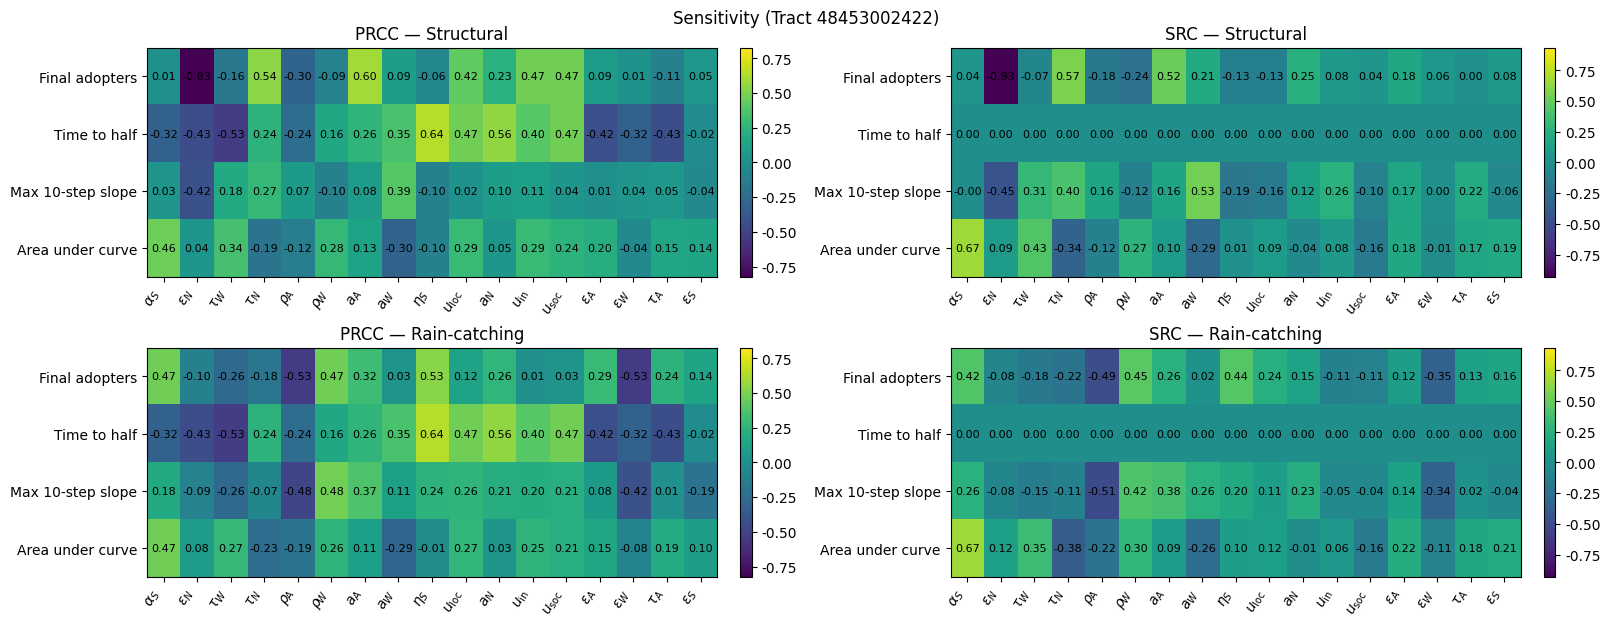

Saved: /mnt/data\heatmaps_2x2_prcc_src_tract_48453002422.png


In [92]:
# =========================================
# 2x2 Heatmap Figure:
#   Row 1: Structural  — [PRCC | SRC]
#   Row 2: Rain-catch. — [PRCC | SRC]
# Requirements in memory: prcc_df, src_df, SELECTED_TRACT
# =========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

outdir = "/mnt/data"
os.makedirs(outdir, exist_ok=True)

# ---- Labels (mathtext) ----
PARAM_LABELS = {
    # Latent update rates
    "alpha_w": r"$a_{W}$",
    "alpha_n": r"$a_{N}$",
    "alpha_a": r"$a_{A}$",

    # Social capital dynamics
    "sc_peer_gain_max": r"$\alpha_{S}$",
    "sc_kappa":         r"$\eta_{S}$",
    "sc_w_nb":          r"$u_{\mathrm{loc}}$",
    "sc_w_soc":         r"$u_{\mathrm{soc}}$",
    "sc_w_inner":       r"$u_{\mathrm{in}}$",

    # Distance & similarity
    "dist_rho_W": r"$\rho_{\!W}$",
    "dist_rho_A": r"$\rho_{\!A}$",
    "tie_lambda": r"$\lambda$",

    # Thresholds / gates
    "gate_aw_min_prev_mean":    r"$\tau_{W}$",
    "gate_n_min_prev_sim_mean": r"$\tau_{N}$",
    "gate_a_min_cred_mean":     r"$\tau_{A}$",

    # Reconsideration triggers
    "rec_eps_W": r"$\varepsilon_{W}$",
    "rec_eps_N": r"$\varepsilon_{N}$",
    "rec_eps_A": r"$\varepsilon_{A}$",
    "rec_eps_S": r"$\varepsilon_{S}$",
}
def pretty_param(k): return PARAM_LABELS.get(k, k)

OUTPUT_LABELS = {
    "S_final":     r"Final adopters",
    "S_t_half":    r"Time to half",
    "S_max_slope": r"Max 10-step slope",
    "S_auc":       r"Area under curve",
    "R_final":     r"Final adopters",
    "R_t_half":    r"Time to half",
    "R_max_slope": r"Max 10-step slope",
    "R_auc":       r"Area under curve",
}

S_ROWS = ["S_final","S_t_half","S_max_slope","S_auc"]
R_ROWS = ["R_final","R_t_half","R_max_slope","R_auc"]

# ---- Helpers to go from long -> wide (outputs × params), then slice to S/R blocks ----
def infer_param_cols(effect_df: pd.DataFrame) -> list:
    return [c for c in effect_df.columns if c != "output"]

def df_to_wide(effect_df: pd.DataFrame, outputs_order: list, enforce_params=None) -> pd.DataFrame:
    rows = []
    for out in outputs_order:
        row = effect_df.loc[effect_df["output"] == out]
        s = row.iloc[0].drop(labels=["output"], errors="ignore") if not row.empty else pd.Series(dtype=float)
        rows.append(s)
    wide = pd.DataFrame(rows, index=outputs_order).fillna(0.0)

    if enforce_params is not None:
        for p in enforce_params:
            if p not in wide.columns:
                wide[p] = 0.0
        wide = wide[enforce_params]

    return wide

# Build unified parameter set from PRCC/SRC (focused set = only keys we have labels for)
param_cols_prcc = infer_param_cols(prcc_df)
param_cols_src  = infer_param_cols(src_df)
param_union = sorted(set(param_cols_prcc) | set(param_cols_src))
focused_params = [p for p in param_union if p in PARAM_LABELS]

# Make wide matrices for all outputs (kept unsorted for now)
outputs_all = S_ROWS + R_ROWS
prcc_wide_all = df_to_wide(prcc_df, outputs_all, enforce_params=focused_params)
src_wide_all  = df_to_wide(src_df,  outputs_all, enforce_params=focused_params)

# Decide one common parameter order for ALL PANELS:
# sort by mean |effect| across BOTH PRCC & SRC, and across all outputs
mean_abs = (prcc_wide_all.abs().mean(axis=0) + src_wide_all.abs().mean(axis=0)) / 2.0
param_order = mean_abs.sort_values(ascending=False).index.tolist()

# Reorder columns consistently
prcc_wide_all = prcc_wide_all[param_order]
src_wide_all  = src_wide_all[param_order]

# Split into Structural (S) and Rain-catching (R) blocks
prcc_S = prcc_wide_all.loc[S_ROWS]
prcc_R = prcc_wide_all.loc[R_ROWS]
src_S  = src_wide_all.loc[S_ROWS]
src_R  = src_wide_all.loc[R_ROWS]

# Pretty axis labels
y_S = [OUTPUT_LABELS[r] for r in S_ROWS]
y_R = [OUTPUT_LABELS[r] for r in R_ROWS]
x_labels = [pretty_param(k) for k in param_order]

# ---- Plot 2×2 panel ----
fig, axes = plt.subplots(2, 2, figsize=(max(16, 0.55*len(x_labels)), 6), constrained_layout=True)

# Common color scales: one for PRCC panels, one for SRC panels
prcc_mat_all = np.vstack([prcc_S.values, prcc_R.values])
src_mat_all  = np.vstack([src_S.values,  src_R.values])

prcc_vmax = float(np.nanmax(np.abs(prcc_mat_all))) if np.isfinite(prcc_mat_all).any() else 1.0
src_vmax  = float(np.nanmax(np.abs(src_mat_all)))  if np.isfinite(src_mat_all).any()  else 1.0
prcc_vmin, prcc_vmax = -prcc_vmax, prcc_vmax
src_vmin,  src_vmax  = -src_vmax,  src_vmax

# Panel A: PRCC — Structural
ax = axes[0, 0]
imA = ax.imshow(prcc_S.values, aspect='auto', vmin=prcc_vmin, vmax=prcc_vmax)
ax.set_title("PRCC — Structural")
ax.set_xticks(np.arange(len(x_labels))); ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_yticks(np.arange(len(y_S)));     ax.set_yticklabels(y_S)
for i in range(prcc_S.shape[0]):
    for j in range(prcc_S.shape[1]):
        val = prcc_S.values[i, j]
        ax.text(j, i, f"{val:.2f}" if np.isfinite(val) else "NA", ha='center', va='center', fontsize=8)
cbarA = fig.colorbar(imA, ax=ax, fraction=0.046, pad=0.04)
cbarA.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Panel B: SRC — Structural
ax = axes[0, 1]
imB = ax.imshow(src_S.values, aspect='auto', vmin=src_vmin, vmax=src_vmax)
ax.set_title("SRC — Structural")
ax.set_xticks(np.arange(len(x_labels))); ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_yticks(np.arange(len(y_S)));     ax.set_yticklabels(y_S)
for i in range(src_S.shape[0]):
    for j in range(src_S.shape[1]):
        val = src_S.values[i, j]
        ax.text(j, i, f"{val:.2f}" if np.isfinite(val) else "NA", ha='center', va='center', fontsize=8)
cbarB = fig.colorbar(imB, ax=ax, fraction=0.046, pad=0.04)
cbarB.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Panel C: PRCC — Rain-catching
ax = axes[1, 0]
imC = ax.imshow(prcc_R.values, aspect='auto', vmin=prcc_vmin, vmax=prcc_vmax)
ax.set_title("PRCC — Rain-catching")
ax.set_xticks(np.arange(len(x_labels))); ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_yticks(np.arange(len(y_R)));     ax.set_yticklabels(y_R)
for i in range(prcc_R.shape[0]):
    for j in range(prcc_R.shape[1]):
        val = prcc_R.values[i, j]
        ax.text(j, i, f"{val:.2f}" if np.isfinite(val) else "NA", ha='center', va='center', fontsize=8)
cbarC = fig.colorbar(imC, ax=ax, fraction=0.046, pad=0.04)
cbarC.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Panel D: SRC — Rain-catching
ax = axes[1, 1]
imD = ax.imshow(src_R.values, aspect='auto', vmin=src_vmin, vmax=src_vmax)
ax.set_title("SRC — Rain-catching")
ax.set_xticks(np.arange(len(x_labels))); ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_yticks(np.arange(len(y_R)));     ax.set_yticklabels(y_R)
for i in range(src_R.shape[0]):
    for j in range(src_R.shape[1]):
        val = src_R.values[i, j]
        ax.text(j, i, f"{val:.2f}" if np.isfinite(val) else "NA", ha='center', va='center', fontsize=8)
cbarD = fig.colorbar(imD, ax=ax, fraction=0.046, pad=0.04)
cbarD.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

fname = os.path.join(outdir, f"heatmaps_2x2_prcc_src_tract_{SELECTED_TRACT}.png")
fig.suptitle(f"Sensitivity (Tract {SELECTED_TRACT})", y=1.02, fontsize=12)
plt.savefig(fname, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", fname)


In [ ]:
# === Side-by-side panel sets: Structural (left 3×3) + Rain-catching (right 3×3) ===
import numpy as np
import math, string
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Build cumulative totals (exclude L1.3), preserving your original layer order
layers_plot = [L for L in layers if L != "L1.3"]

results_struct = {L: np.cumsum(new_adoptions_struct[L]) for L in layers_plot}
results_rain   = {L: np.cumsum(new_adoptions_rain[L])   for L in layers_plot}

# Grid sizes
cols_inner = 3
rows_inner = math.ceil(len(layers_plot) / cols_inner)

# Big figure: 1 row × 2 columns containers
fig = plt.figure(figsize=(5 * cols_inner * 2, 3.5 * rows_inner))  # width doubled for two blocks
gs  = GridSpec(1, 2, figure=fig, wspace=0.15)

# Sub-grids for left (structural) and right (rain-catching)
gs_left  = gs[0, 0].subgridspec(rows_inner, cols_inner, wspace=0.25, hspace=0.35)
gs_right = gs[0, 1].subgridspec(rows_inner, cols_inner, wspace=0.25, hspace=0.35)

letters = list(string.ascii_lowercase)

# ------------------------
# Left column: STRUCTURAL
# ------------------------
for idx, layer in enumerate(layers_plot):
    r, c = divmod(idx, cols_inner)
    ax = fig.add_subplot(gs_left[r, c])

    s = results_struct[layer]
    x = np.arange(len(s))

    ax.plot(x, s, lw=2, color="tab:blue", marker="o", markersize=3)
    ax.set_title(f"({letters[idx]}) {layer}", fontsize=12)
    ax.set_xlabel("Step", fontsize=10)
    ax.set_ylabel("Cumulative Structural Adopters", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

# Turn off any unused subplots on the left
for idx in range(len(layers_plot), rows_inner * cols_inner):
    r, c = divmod(idx, cols_inner)
    fig.add_subplot(gs_left[r, c]).axis("off")

# ---------------------------
# Right column: RAIN-CATCHING
# ---------------------------
offset = rows_inner * cols_inner  # continue lettering
for idx, layer in enumerate(layers_plot):
    r, c = divmod(idx, cols_inner)
    ax = fig.add_subplot(gs_right[r, c])

    rseries = results_rain[layer]
    x = np.arange(len(rseries))

    ax.plot(x, rseries, lw=2, color="tab:brown", marker="s", markersize=3)
    ax.set_title(f"({letters[offset + idx]}) {layer}", fontsize=12)
    ax.set_xlabel("Step", fontsize=10)
    ax.set_ylabel("Cumulative Rain-Catching Adopters", fontsize=10)
    ax.grid(True, linestyle="--", alpha=0.5)

# Turn off any unused subplots on the right
for idx in range(len(layers_plot), rows_inner * cols_inner):
    r, c = divmod(idx, cols_inner)
    fig.add_subplot(gs_right[r, c]).axis("off")

# Column headers
fig.text(0.25, 0.995, "Structural cumulative adopters (3×3 panels)", ha="center", va="top", fontsize=13)
fig.text(0.75, 0.995, "Rain-catching cumulative adopters (3×3 panels)", ha="center", va="top", fontsize=13)

plt.tight_layout(rect=(0, 0, 1, 0.97))  # leave space for the column headers
plt.show()


In [24]:
# ===== Cell F · build per-district panels & deltas for chosen layer =====

# Focus on single layer for mechanism analysis
if "Layer_from_loop" in agents_all.columns:
    aa = agents_all[agents_all["Layer_from_loop"] == LAYER_TO_ANALYZE].copy()
else:
    aa = agents_all[agents_all["Layer"] == LAYER_TO_ANALYZE].copy()

# Normalize types
for col in ["Adopt_S","Adopt_R"]:
    if col in aa.columns:
        aa[col] = aa[col].astype(int)

# Add adoption incidence (0->1 new adopters per agent per step)
agent_id_col = "AgentID" if "AgentID" in aa.columns else aa.columns[0]  # best effort
if agent_id_col.lower() not in [c.lower() for c in aa.columns]:
    # pick the first column starting with 'agent'
    candidates = [c for c in aa.columns if c.lower().startswith("agent")]
    agent_id_col = candidates[0] if candidates else aa.columns[0]

aa = aa.sort_values([agent_id_col, STEP_COL]).reset_index(drop=True)
for col in ("Adopt_S","Adopt_R"):
    if col in aa.columns:
        aa[col + "_int"] = aa[col].astype(int)
        aa["new_" + col] = aa.groupby(agent_id_col)[col + "_int"].diff().clip(lower=0).fillna(0).astype(int)
    else:
        aa["new_" + col] = 0

# Keep only labeled districts
if "District" in aa.columns:
    aa = aa[aa["District"].astype(str) != "Unknown"].copy()
else:
    aa["District"] = "All"

# District population (unique agents)
district_pop = (aa.groupby("District")[agent_id_col].nunique()
                  .rename("pop").reset_index())

# Map latent column names
latent_map = {
    "structural":   {"W":"W_struct","N":"N_struct","A":"A_struct","S":"S_struct"},
    "raincatching": {"W":"W_rain",  "N":"N_rain",  "A":"A_rain",  "S":"S_rain"},
}
adopt_new_map = {"structural":"new_Adopt_S", "raincatching":"new_Adopt_R"}

def _build_panel(behavior):
    keep = list(latent_map[behavior].values()) + [adopt_new_map[behavior], "District", STEP_COL]
    g = (aa[keep]
         .groupby(["District", STEP_COL])
         .agg({**{c:'mean' for c in latent_map[behavior].values()}, adopt_new_map[behavior]:'sum'})
         .reset_index()
         .rename(columns={adopt_new_map[behavior]:'new_adopt'}))
    # per 1k hh incidence
    g = g.merge(district_pop, on="District", how="left")
    g["new_adopt_per1k"] = 1000.0 * g["new_adopt"] / g["pop"].clip(lower=1)
    # latent deltas
    for L, col in latent_map[behavior].items():
        g[f"d{L}"] = g.groupby("District")[col].diff().fillna(0.0)
    return g

panel_struct = _build_panel("structural")
panel_rain   = _build_panel("raincatching")

print("Panels ready:",
      f"\n  structural rows={len(panel_struct)} cols={list(panel_struct.columns)[:10]}...",
      f"\n  rain rows={len(panel_rain)} cols={list(panel_rain.columns)[:10]}...")


Panels ready: 
  structural rows=1200 cols=['District', 'Step', 'W_struct', 'N_struct', 'A_struct', 'S_struct', 'new_adopt', 'pop', 'new_adopt_per1k', 'dW']... 
  rain rows=1200 cols=['District', 'Step', 'W_rain', 'N_rain', 'A_rain', 'S_rain', 'new_adopt', 'pop', 'new_adopt_per1k', 'dW']...


In [36]:
# ===== Cell G · feedback correlations (adopt_t vs Δlatent_t / Δlatent_{t+1}) =====

def _safe_corr(a, b):
    a = pd.Series(a); b = pd.Series(b)
    m = a.notna() & b.notna()
    a, b = a[m], b[m]
    if len(a) < 3 or a.std(ddof=0) == 0 or b.std(ddof=0) == 0:
        return np.nan
    return float(a.corr(b))

rows = []
for beh, panel in [("structural", panel_struct), ("raincatching", panel_rain)]:
    for d, sub in panel.groupby("District"):
        for L in ("W","N","A","S"):
            same_r = _safe_corr(sub["new_adopt_per1k"], sub[f"d{L}"])            # adopt_t vs ΔL_t
            lead_r = _safe_corr(sub["new_adopt_per1k"], sub[f"d{L}"].shift(-1))  # adopt_t vs ΔL_{t+1}
            rows.append(dict(layer=LAYER_TO_ANALYZE, District=d, behavior=beh, latent=L,
                             same_step_r=same_r, lead_r=lead_r))

fb_all = pd.DataFrame(rows).merge(district_pop, on="District", how="left")
fb_all = fb_all.sort_values(["behavior","latent","District"]).reset_index(drop=True)

csv_path = os.path.join(OUTDIR, f"feedback_correlations_by_district_{LAYER_TO_ANALYZE}.csv")
fb_all.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

# Citywide summary (mean across districts with simple 95% CI)
def _ci95(x):
    x = pd.Series(x).dropna()
    if len(x) == 0: return (np.nan, np.nan)
    mu, se = x.mean(), x.std(ddof=1)/math.sqrt(len(x))
    return (mu - 1.96*se, mu + 1.96*se)

summary = (fb_all
           .groupby(["behavior","latent"])["lead_r"]
           .agg(["count","mean","std"])
           .reset_index())
summary[["ci_low","ci_high"]] = summary.apply(
    lambda r: pd.Series(_ci95(fb_all[(fb_all["behavior"]==r["behavior"]) & (fb_all["latent"]==r["latent"])]["lead_r"])),
    axis=1
)
display(summary.round(3))


Saved: figs_clean\feedback_correlations_by_district_L4.csv


behavior latent  count   mean    std  ci_low  ci_high
0  raincatching      A     10 -0.086  0.383  -0.323    0.152
1  raincatching      N     10 -0.129  0.370  -0.358    0.100
2  raincatching      S     10  0.154  0.230   0.012    0.297
3  raincatching      W     10 -0.143  0.150  -0.236   -0.050
4    structural      A     10 -0.444  0.314  -0.638   -0.249
5    structural      N     10 -0.412  0.345  -0.626   -0.199
6    structural      S     10  0.237  0.312   0.044    0.430
7    structural      W     10 -0.260  0.114  -0.330   -0.189

Rolling coefficients built: structural=1050 rows, rain=1050 rows.


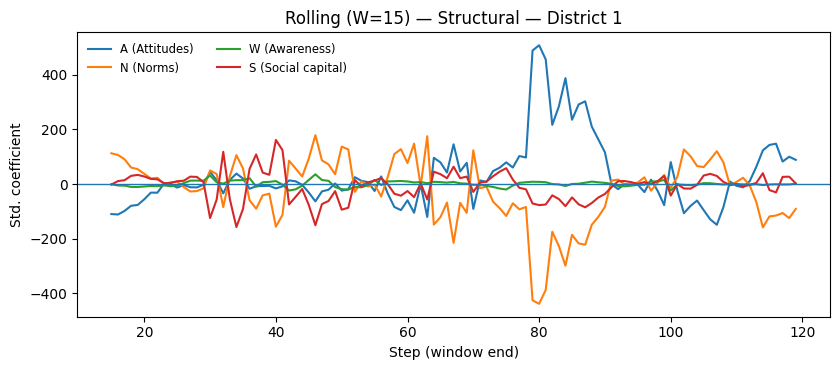

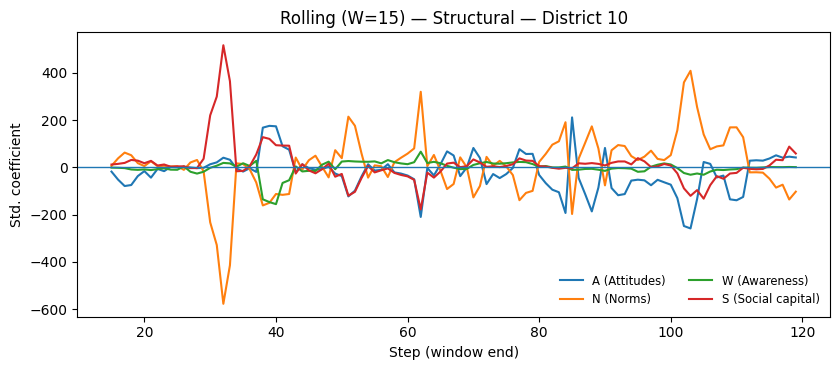

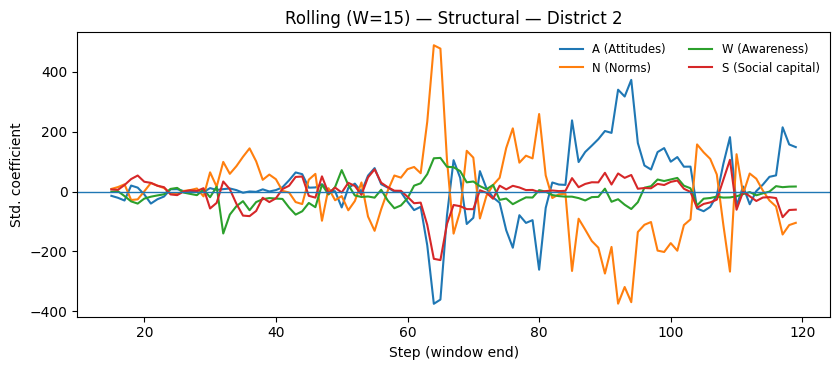

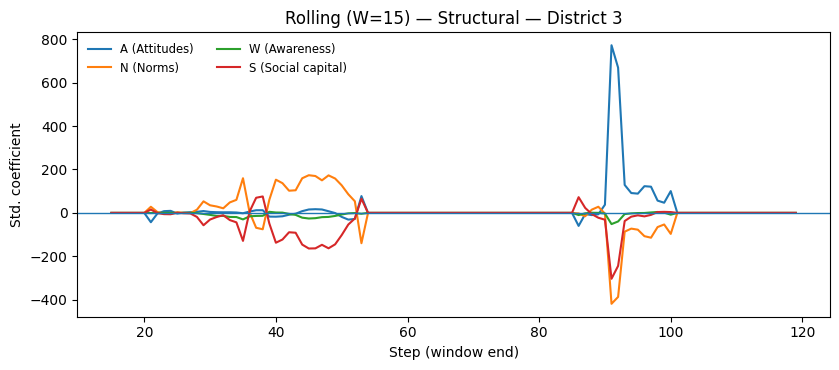

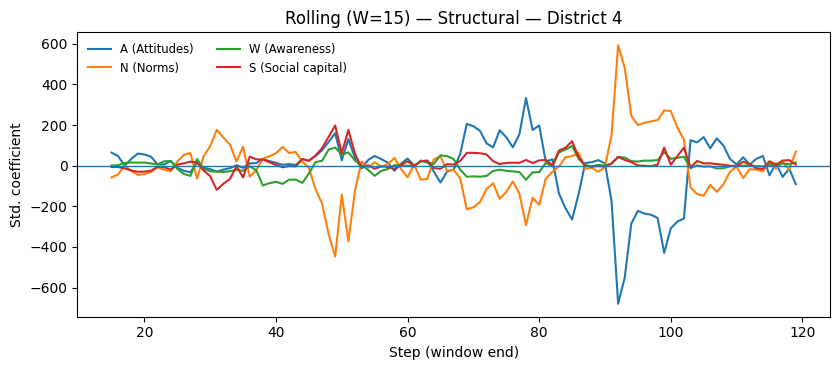

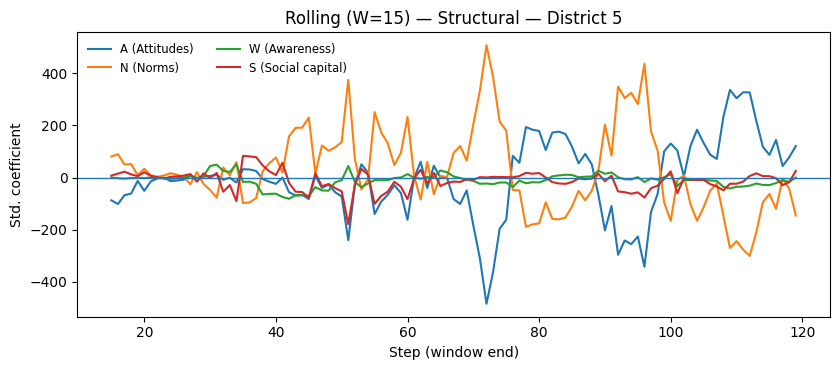

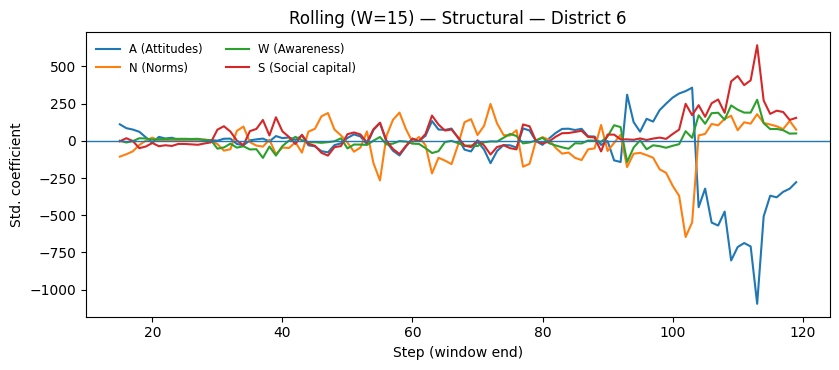

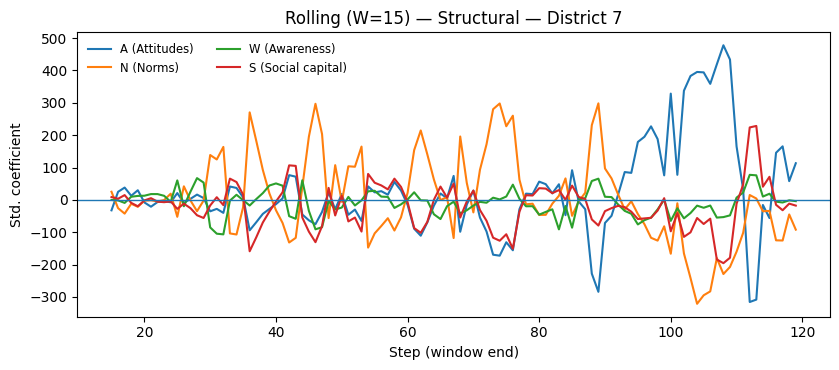

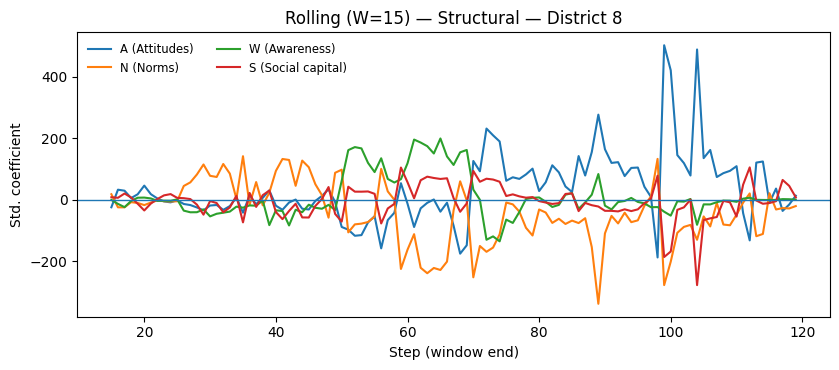

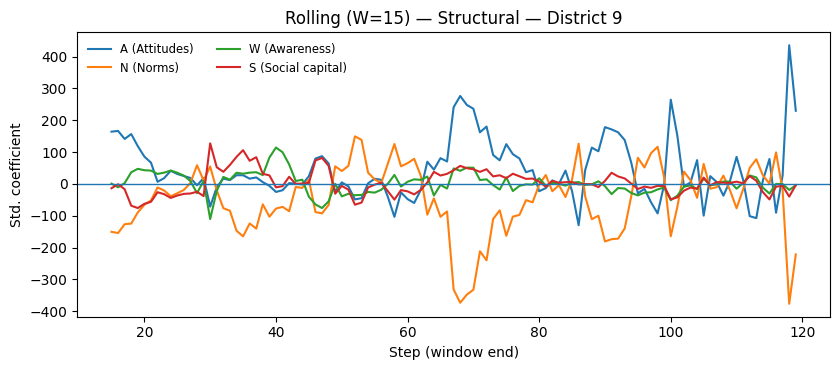

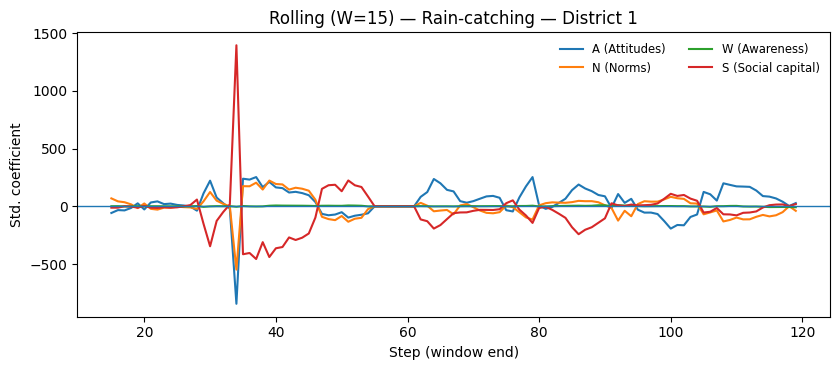

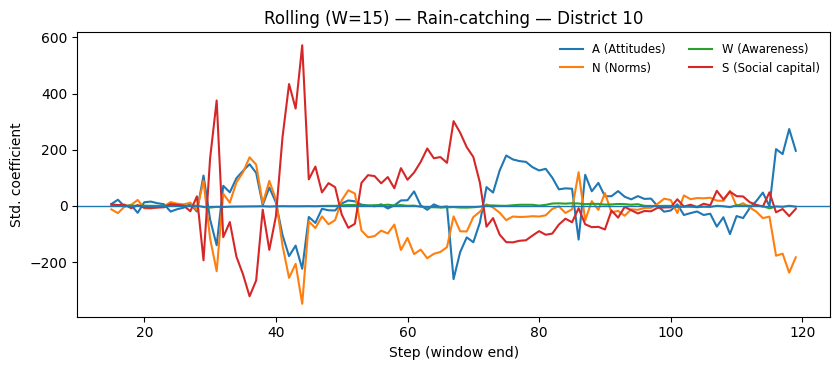

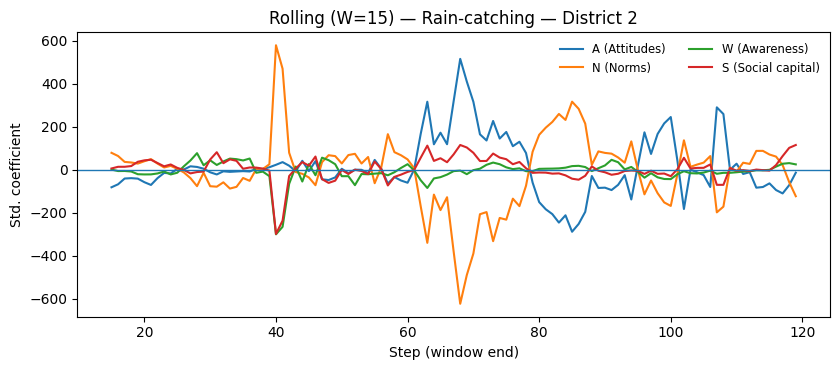

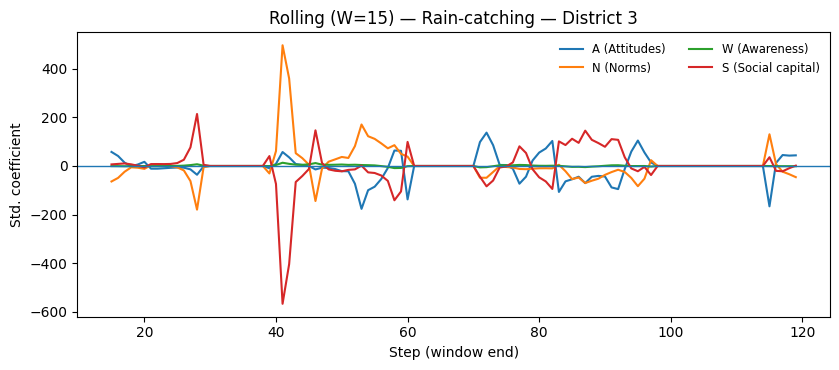

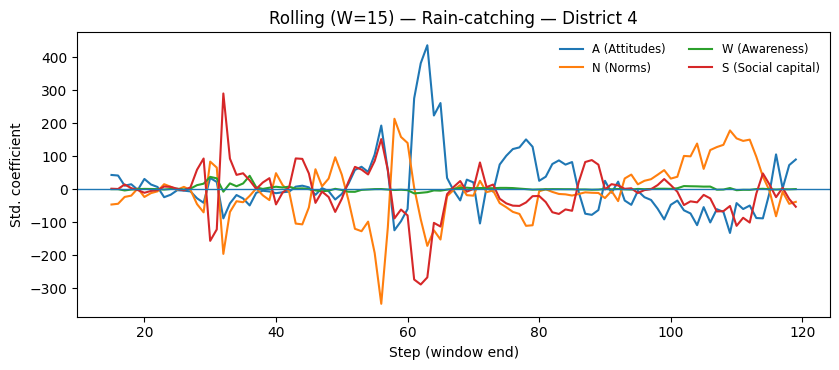

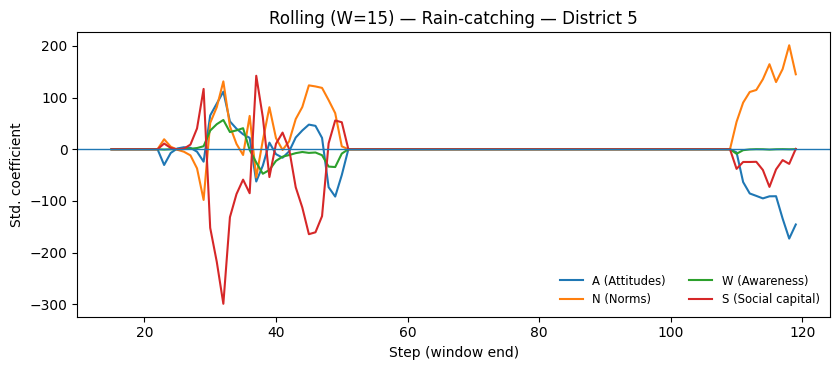

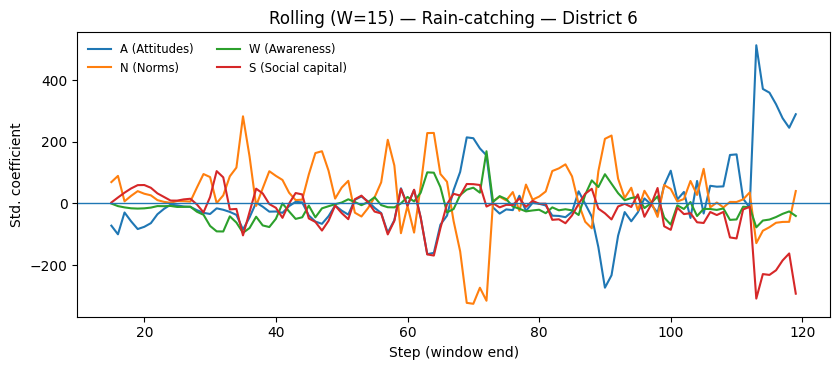

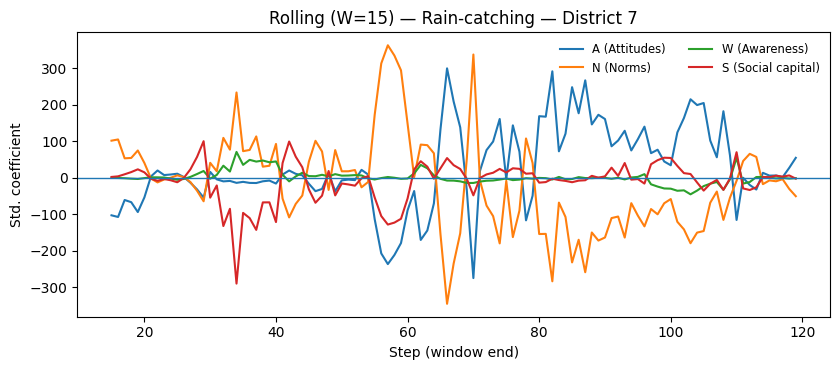

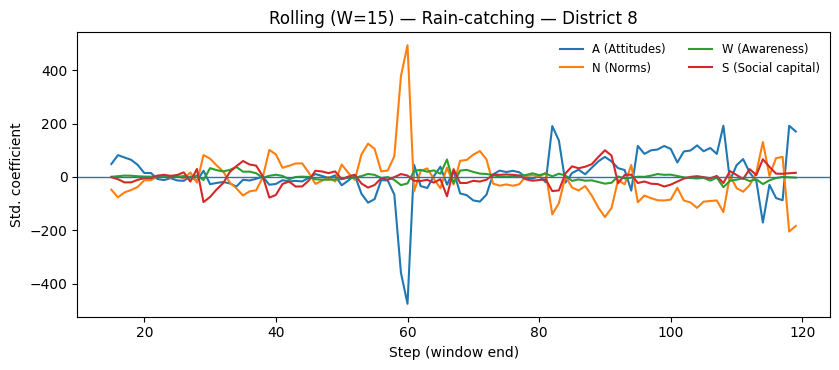

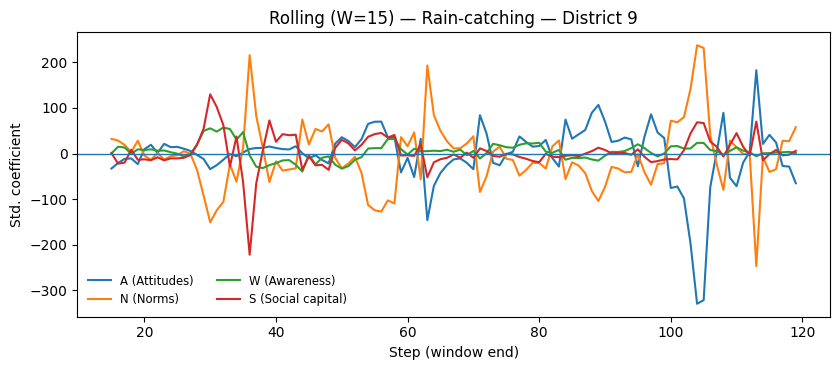

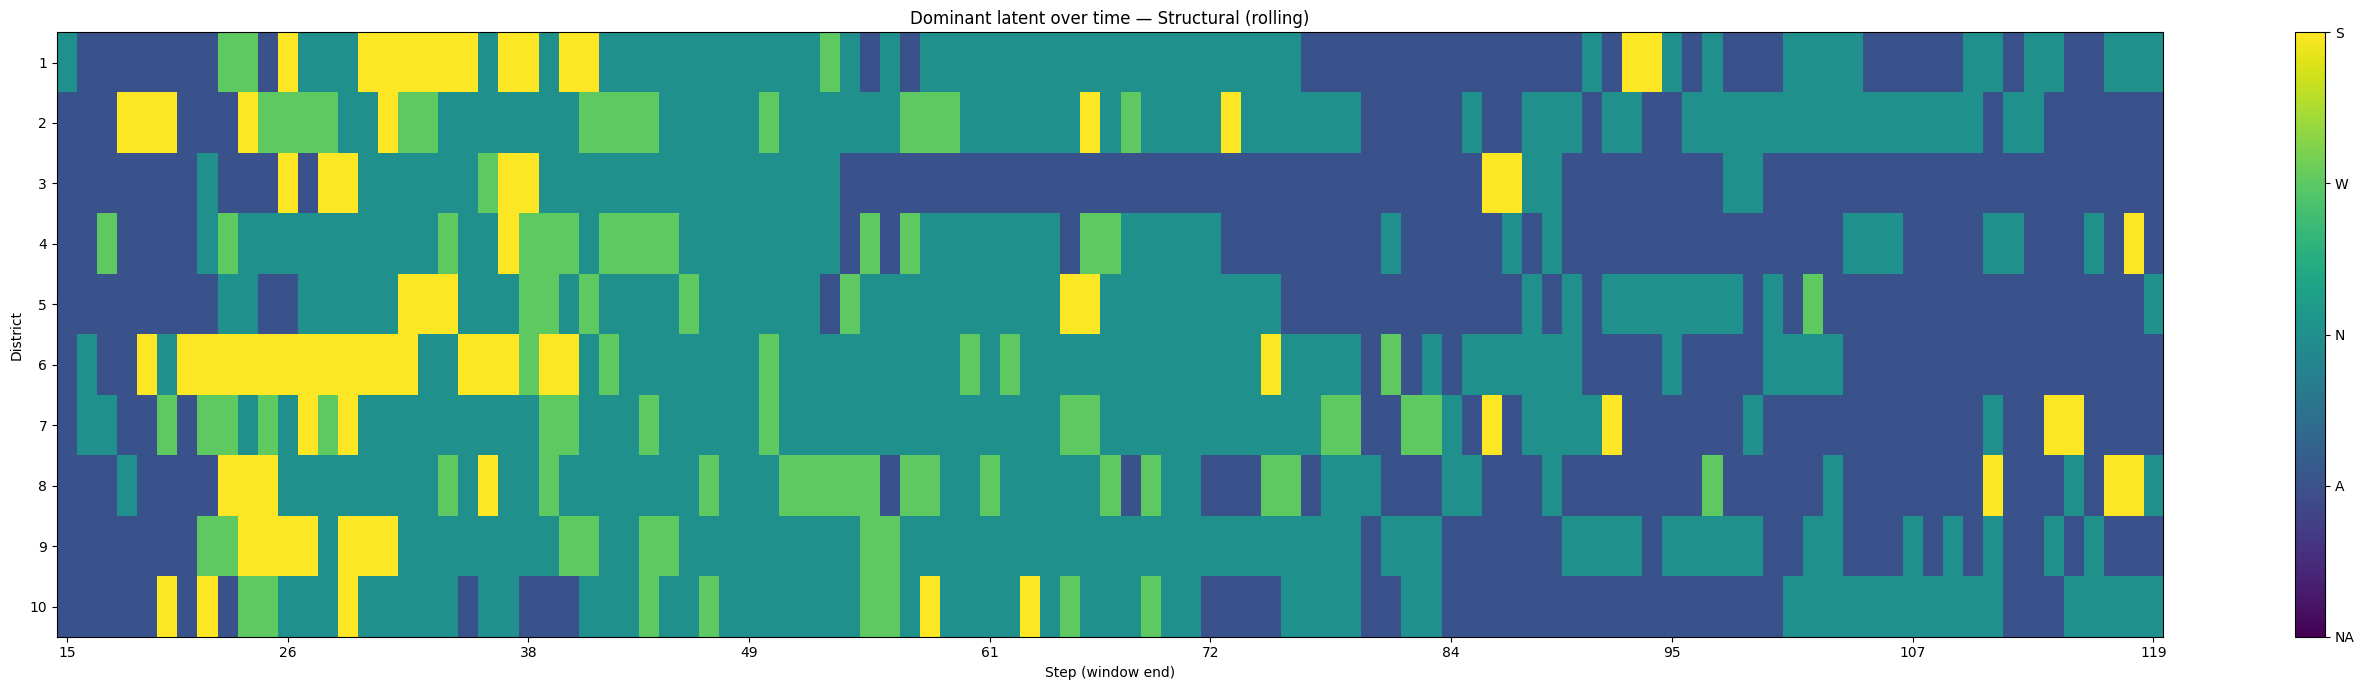

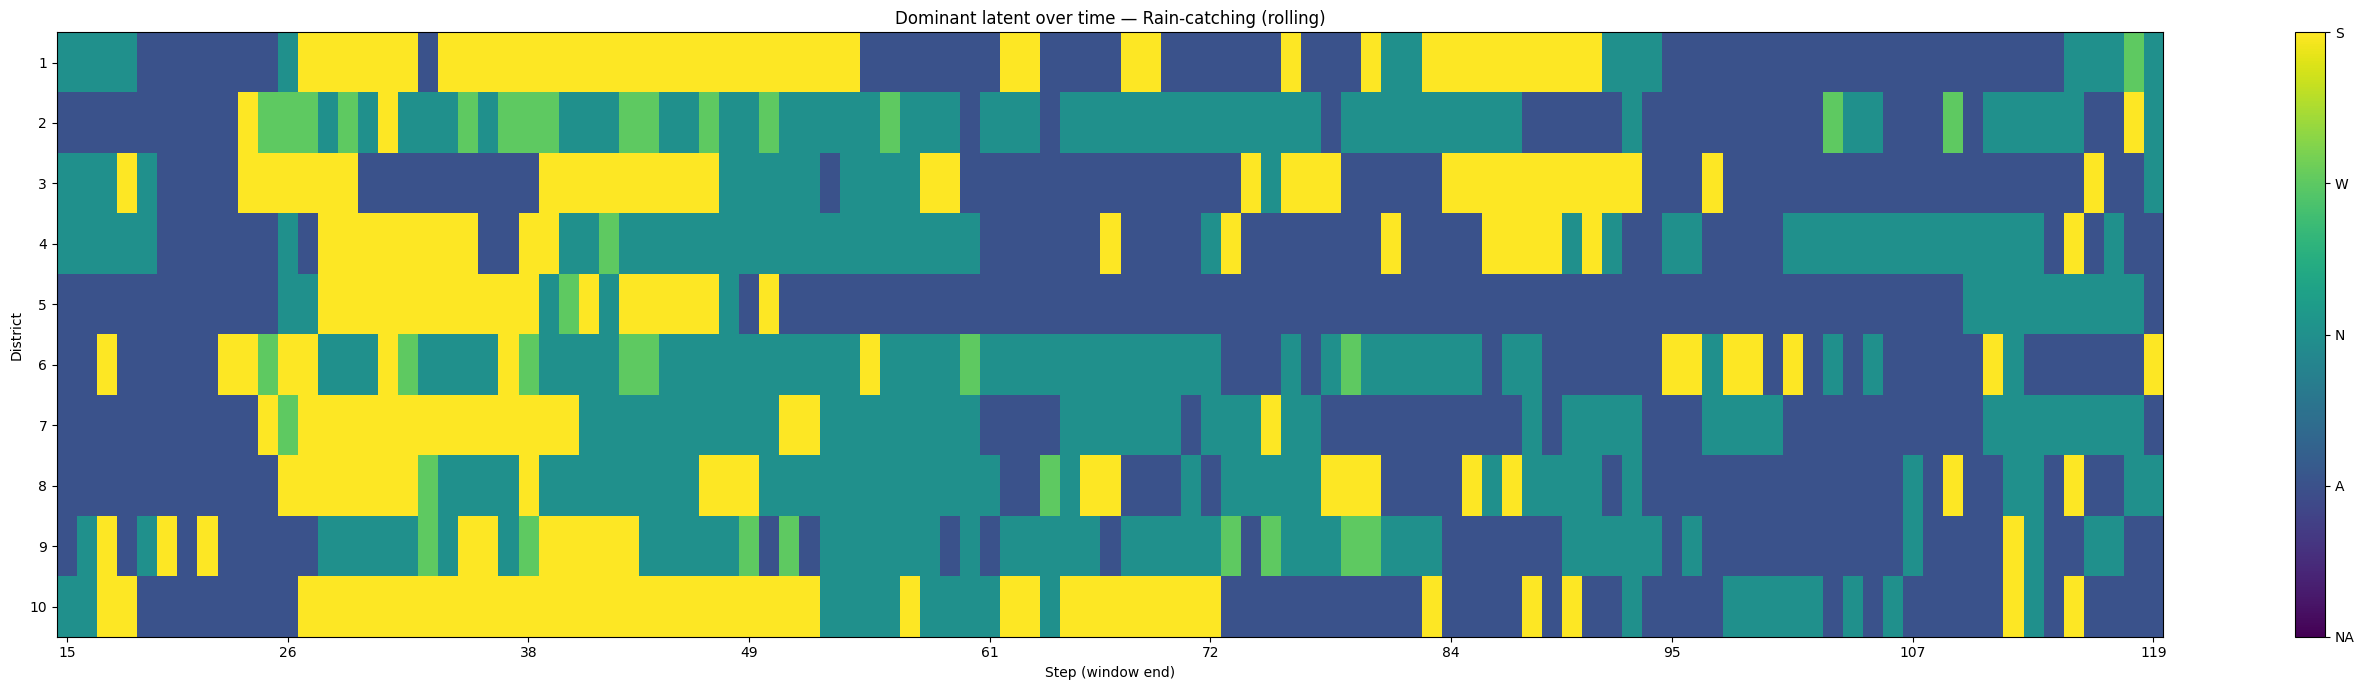

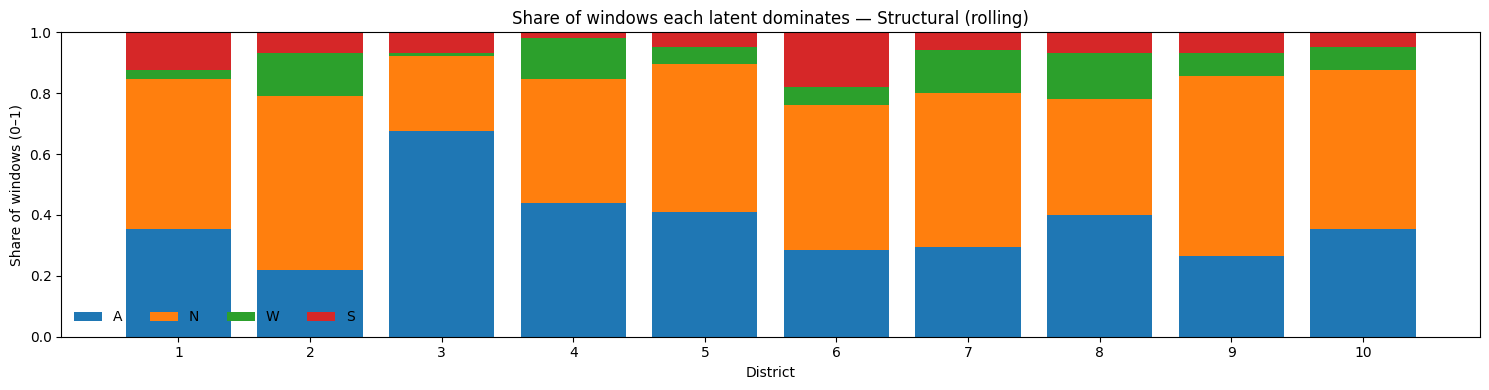

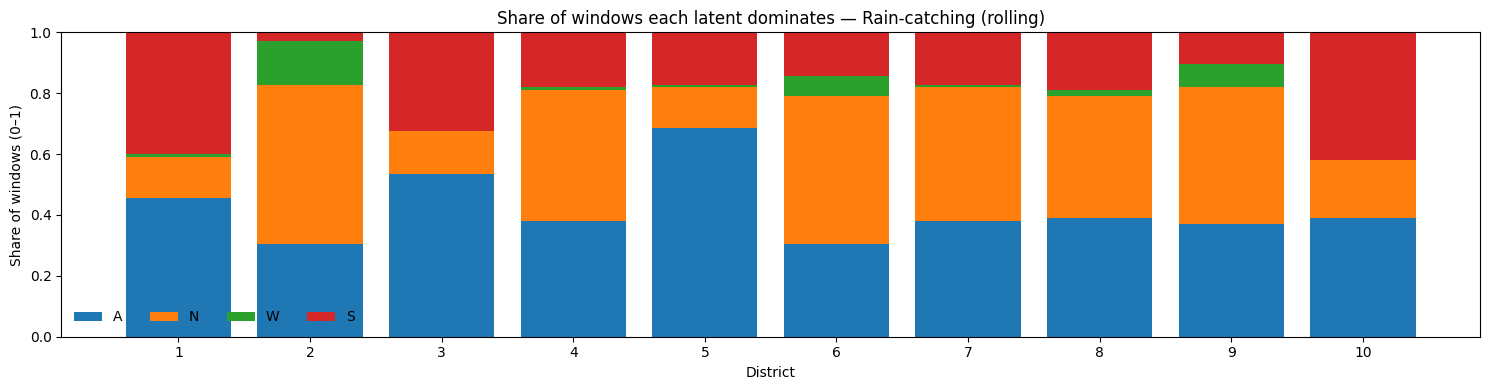

In [35]:
# === Rolling, time-varying drivers (ALL-IN-ONE CELL) =========================================
# Outputs:
#  • Per-district coefficient time series (structural & rain-catching)
#  • Heatmaps of the dominant latent over time (structural & rain-catching)
#  • Stacked bars: share of windows where A/N/W/S is the winner (structural & rain-catching)
#
# Requirements in memory: either
#   (panel_struct, panel_rain, district_pop)   OR   agents_all
# ---------------------------------------------------------------------------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------- Config --------------------------
WINDOW       = 15     # rolling window length (steps)
STEP         = 1      # slide by this many steps
MIN_OBS      = 5      # minimum rows in a window to fit OLS
STANDARDIZE  = "window"  # "window" or "global" (z-score within window vs global series)

# --------------------- Small helpers ------------------------
def _add_const(X):
    X = np.asarray(X, dtype=float)
    return np.hstack([np.ones((X.shape[0], 1), dtype=float), X])

def _ols_fit(X, y):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    beta = beta.reshape(-1, 1)
    resid = y - X @ beta
    n, p = X.shape
    dof = max(1, n - p)
    rss = float((resid.T @ resid).flatten()[0])
    s2  = rss / dof
    XtX_inv = np.linalg.pinv(X.T @ X)
    se = np.sqrt(np.clip(np.diag(s2 * XtX_inv), 0, np.inf)).reshape(-1, 1)
    se = np.where(se == 0, np.inf, se)
    tstat = (beta / se).flatten()
    # vectorized erf with a safe fallback
    try:
        erf_vec = np.erf
    except AttributeError:
        from math import erf
        erf_vec = np.vectorize(erf)
    pval = 2 * (1 - 0.5 * (1 + erf_vec(np.abs(tstat) / np.sqrt(2))))
    return beta.flatten(), se.flatten(), tstat, pval

def _z(x):
    x = pd.Series(x, dtype=float)  # IMPORTANT: dtype as keyword (fixes your error)
    s = x.std(ddof=0)
    return (x - x.mean()) / (s if s else 1.0)

# ------------- Build panels if not already present ----------
def _build_panels_from_agents(aa):
    step_col = 'step' if 'step' in aa.columns else ('Step' if 'Step' in aa.columns else None)
    if step_col is None:
        raise RuntimeError("Couldn't find a step column in `agents_all`.")
    cand = [c for c in ['AgentID','agent_id','agent','aid','unique_id','index','Agent'] if c in aa.columns]
    if not cand:
        cand = [c for c in aa.columns if c.lower().startswith('agent')]
    if not cand:
        raise RuntimeError("Couldn't find an agent id column in `agents_all`.")
    agent_col = cand[0]

    # per-agent 0→1 new adoptions
    for col in ('Adopt_S','Adopt_R'):
        if col in aa.columns:
            aa[col + '_int'] = aa[col].astype(int)
            aa['new_' + col] = aa.groupby(agent_col)[col + '_int'].diff().clip(lower=0).fillna(aa[col + '_int']).astype(int)
        else:
            aa['new_' + col] = 0

    if 'District' in aa.columns and aa['District'].dtype == 'object':
        aa = aa[aa['District'] != 'Unknown'].copy()

    district_pop = (aa.groupby('District')[agent_col].nunique()
                      .rename('pop').reset_index())

    latent_map = {
        'structural':   {'W':'W_struct','N':'N_struct','A':'A_struct','S':'S_struct'},
        'raincatching': {'W':'W_rain',  'N':'N_rain',  'A':'A_rain',  'S':'S_rain'},
    }
    adopt_new_map = {'structural':'new_Adopt_S','raincatching':'new_Adopt_R'}

    outs = {}
    for beh in ('structural','raincatching'):
        keep = list(latent_map[beh].values()) + [adopt_new_map[beh]]
        g = (aa.groupby(['District', step_col])[keep]
                .agg({**{c:'mean' for c in latent_map[beh].values()}, adopt_new_map[beh]:'sum'})
                .reset_index()
                .rename(columns={adopt_new_map[beh]:'new_adopt'}))
        for L, col in latent_map[beh].items():
            g[f'd{L}'] = g.groupby('District')[col].diff().fillna(0.0)
        outs[beh] = g

    return step_col, outs['structural'], outs['raincatching'], district_pop

# Use existing panels if available; else rebuild from agents_all
if 'panel_struct' in globals() and 'panel_rain' in globals() and 'district_pop' in globals():
    step_col = 'step' if 'step' in panel_struct.columns else ('Step' if 'Step' in panel_struct.columns else None)
    if step_col is None and 'agents_all' in globals():
        step_col, panel_struct, panel_rain, district_pop = _build_panels_from_agents(agents_all.copy())
    elif step_col is None:
        raise RuntimeError("Need a step column or `agents_all` to rebuild panels.")
else:
    if 'agents_all' not in globals():
        raise RuntimeError("I need either (panel_struct, panel_rain, district_pop) OR `agents_all` to proceed.")
    step_col, panel_struct, panel_rain, district_pop = _build_panels_from_agents(agents_all.copy())

# ---------------- Rolling forward OLS per district ----------------
def rolling_forward(panel, behavior, dpop, W=20, slide=1, min_obs=8, standardize="window"):
    lat_cols = {'structural': ['A_struct','N_struct','W_struct','S_struct'],
                'raincatching': ['A_rain','N_rain','W_rain','S_rain']}[behavior]
    def _pop(d):
        r = dpop[dpop['District'] == d]
        return float(r['pop'].iloc[0]) if len(r) else np.nan

    rows = []
    for d, sub in panel.groupby('District'):
        pop = _pop(d)
        if not np.isfinite(pop) or pop <= 0:
            continue
        sub = sub.sort_values(step_col).reset_index(drop=True)
        y = (sub['new_adopt'] / pop).shift(-1)       # next-step adoption rate
        X = sub[lat_cols].copy()
        df = pd.concat([X, y.rename('y'), sub[step_col]], axis=1).dropna()
        if len(df) < max(W, min_obs):
            continue

        # global standardization (optional)
        if standardize == "global":
            Xm = df[lat_cols].mean(axis=0)
            Xs = df[lat_cols].std(axis=0, ddof=0).replace(0, np.nan)
            ym = df['y'].mean()
            ys = df['y'].std(ddof=0) or np.nan

        i = 0
        while i + W <= len(df):
            win = df.iloc[i:i+W].copy()
            if standardize == "window":
                Xz = win[lat_cols].apply(_z, axis=0).values
                yz = _z(win['y']).values
            else:
                Xz = (win[lat_cols] - Xm).divide(Xs).fillna(0.0).values
                yz = ((win['y'] - ym) / (ys if ys not in (0, np.nan) else 1.0)).fillna(0.0).values

            if len(win) >= min_obs:
                B, _, _, _ = _ols_fit(_add_const(Xz), yz)
                rows.append({'District': str(d),
                             'step_end': int(win[step_col].iloc[-1]),
                             'A': float(B[1]), 'N': float(B[2]), 'W': float(B[3]), 'S': float(B[4])})
            i += slide

    return pd.DataFrame(rows)

coef_ts_struct = rolling_forward(panel_struct, 'structural',   district_pop,
                                 W=WINDOW, slide=STEP, min_obs=MIN_OBS, standardize=STANDARDIZE)
coef_ts_rain   = rolling_forward(panel_rain,   'raincatching', district_pop,
                                 W=WINDOW, slide=STEP, min_obs=MIN_OBS, standardize=STANDARDIZE)

print(f"Rolling coefficients built: structural={len(coef_ts_struct)} rows, rain={len(coef_ts_rain)} rows.")

# ------------------- Per-district time-series plots -------------------
def _plot_coef_ts(coef_ts, behavior_name):
    for d, sub in coef_ts.groupby('District'):
        sub = sub.sort_values('step_end')
        fig, ax = plt.subplots(figsize=(8.5, 3.8))
        ax.plot(sub['step_end'], sub['A'], label='A (Attitudes)')
        ax.plot(sub['step_end'], sub['N'], label='N (Norms)')
        ax.plot(sub['step_end'], sub['W'], label='W (Awareness)')
        ax.plot(sub['step_end'], sub['S'], label='S (Social capital)')
        ax.axhline(0, linewidth=1)
        ax.set_xlabel('Step (window end)')
        ax.set_ylabel('Std. coefficient')
        ax.set_title(f'Rolling (W={WINDOW}) — {behavior_name} — District {d}')
        ax.legend(ncol=2, fontsize='small', frameon=False)
        plt.tight_layout()
        plt.show()

_plot_coef_ts(coef_ts_struct, "Structural")
_plot_coef_ts(coef_ts_rain,   "Rain-catching")

# ------------------- Winner-over-time heatmaps -------------------
def _winners_heatmap(coef_ts, title):
    if coef_ts.empty:
        print("No data for:", title); return
    dlist = sorted(coef_ts['District'].unique(), key=lambda x: int(x) if str(x).isdigit() else str(x))
    steps = sorted(coef_ts['step_end'].unique())
    M = np.full((len(dlist), len(steps)), -1, dtype=int)  # -1 = NA
    for i, d in enumerate(dlist):
        sub = coef_ts[coef_ts['District'] == d]
        for _, row in sub.iterrows():
            s = int(row['step_end']); j = steps.index(s)
            vals = np.array([row['A'], row['N'], row['W'], row['S']], float)
            M[i, j] = int(np.argmax(np.abs(vals)))  # 0=A,1=N,2=W,3=S
    fig, ax = plt.subplots(figsize=(0.22*len(steps)+4, 0.5*len(dlist)+2))
    im = ax.imshow(M, aspect='auto', vmin=-1, vmax=3)
    ax.set_title(title)
    ax.set_yticks(np.arange(len(dlist))); ax.set_yticklabels([str(d) for d in dlist])
    xt = np.linspace(0, len(steps)-1, min(10, len(steps))).astype(int)
    ax.set_xticks(xt); ax.set_xticklabels([str(steps[k]) for k in xt])
    ax.set_xlabel('Step (window end)'); ax.set_ylabel('District')
    cb = plt.colorbar(im, ax=ax); cb.set_ticks([-1,0,1,2,3]); cb.set_ticklabels(['NA','A','N','W','S'])
    plt.tight_layout(); plt.show()

_winners_heatmap(coef_ts_struct, "Dominant latent over time — Structural (rolling)")
_winners_heatmap(coef_ts_rain,   "Dominant latent over time — Rain-catching (rolling)")

# --------- Share of windows where each latent is the winner ----------
def _winner_shares(coef_ts):
    rows = []
    for d, sub in coef_ts.groupby('District'):
        if sub.empty: continue
        idx = np.argmax(np.abs(sub[['A','N','W','S']].values), axis=1)
        labs = np.array(['A','N','W','S'])
        winners = labs[idx]
        shares = {k: (winners == k).mean() for k in ['A','N','W','S']}
        rows.append({'District': str(d), **shares})
    out = pd.DataFrame(rows).fillna(0.0)
    try:
        out = out.sort_values('District', key=lambda s: s.astype(int))
    except Exception:
        out = out.sort_values('District')
    return out

def _plot_winner_share(coef_ts, title):
    shares = _winner_shares(coef_ts)
    if shares.empty:
        print("No data for:", title); return
    x = np.arange(len(shares))
    bottom = np.zeros(len(shares))
    fig, ax = plt.subplots(figsize=(1.2*len(shares)+3, 4))
    for col in ['A','N','W','S']:
        ax.bar(x, shares[col].values, bottom=bottom, label=col)
        bottom += shares[col].values
    ax.set_xticks(x); ax.set_xticklabels(shares['District'].tolist())
    ax.set_ylim(0, 1); ax.set_ylabel('Share of windows (0–1)')
    ax.set_xlabel('District'); ax.set_title(title)
    ax.legend(ncol=4, frameon=False)
    plt.tight_layout(); plt.show()

_plot_winner_share(coef_ts_struct, "Share of windows each latent dominates — Structural (rolling)")
_plot_winner_share(coef_ts_rain,   "Share of windows each latent dominates — Rain-catching (rolling)")
# ====================================== END CELL =============================================


[Awareness @ TRUE step0 quartiles]
              Q1  Median     Q3
District                      
1        -0.876  -0.155  0.552
2        -0.782  -0.173  0.412
3        -0.311   0.186  0.674
4        -0.559   0.026  0.603
5        -0.596   0.040  0.675
6        -0.781  -0.160  0.452
7        -0.729  -0.035  0.667
8        -0.531   0.048  0.624
9        -0.769  -0.106  0.549
10       -0.851  -0.158  0.534 

[White% check] any NaN in race parse? -> False
Saved: figs_clean/fig_9panel_dashboard.png


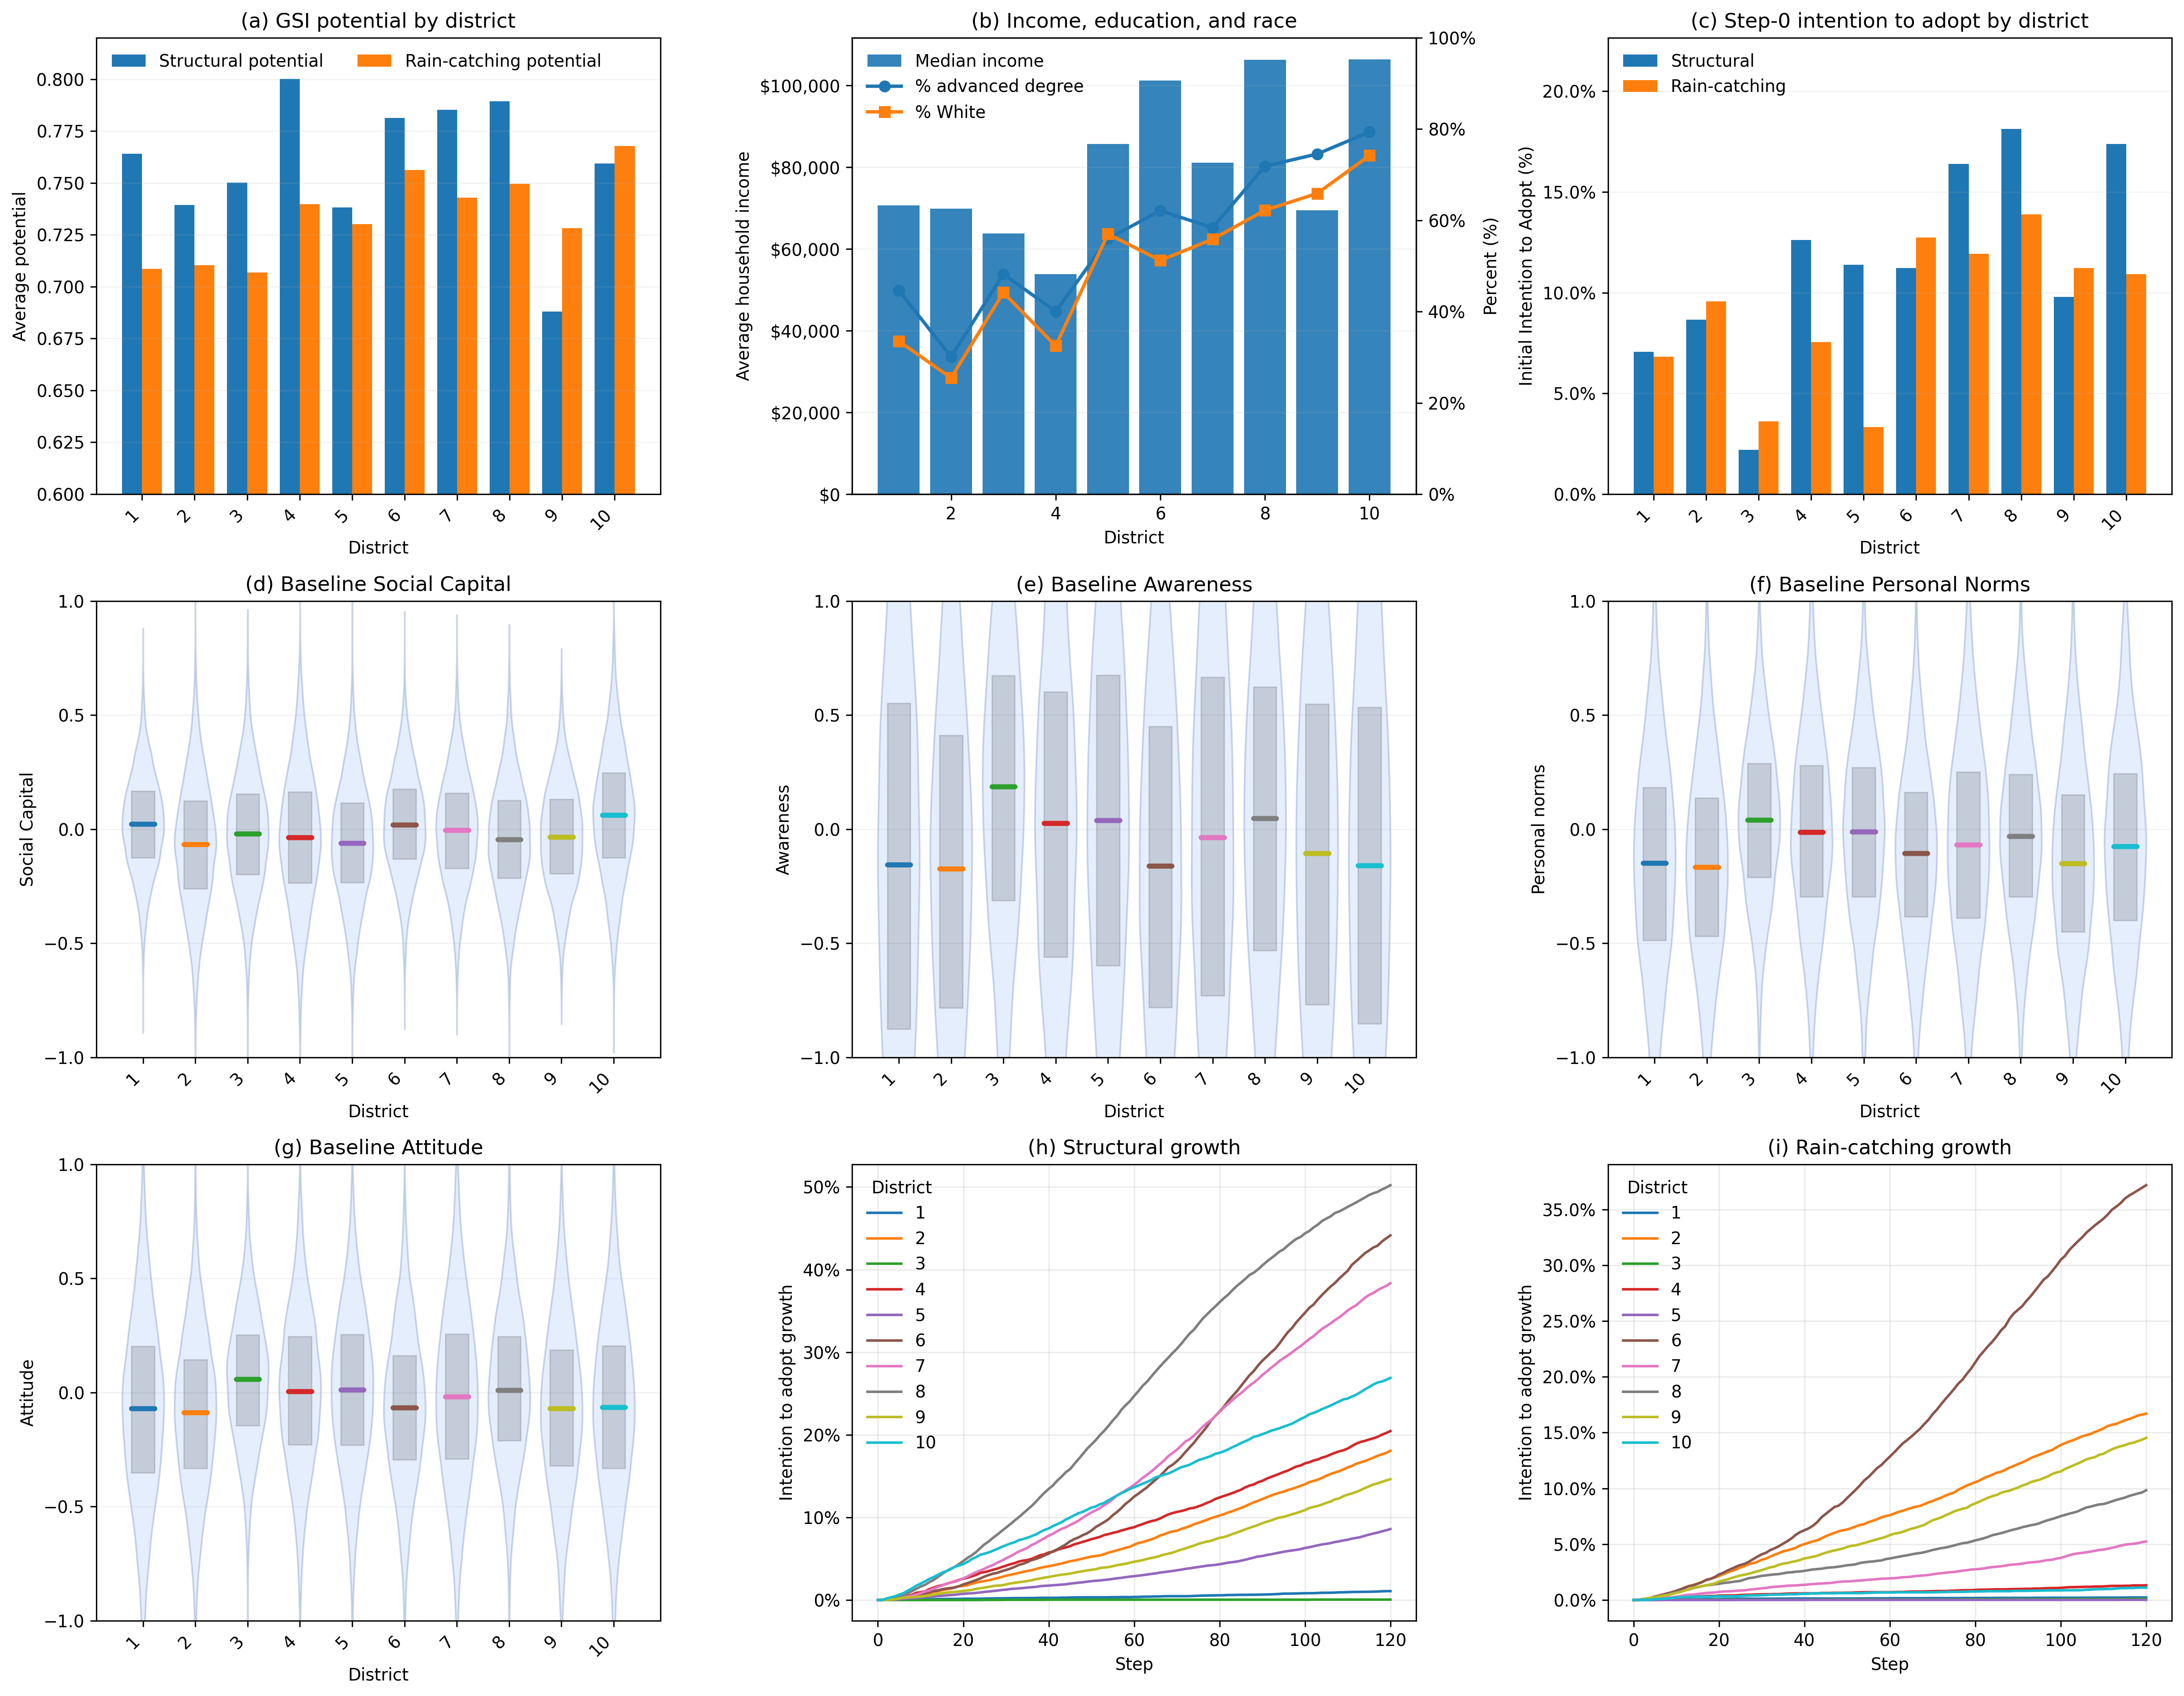

In [73]:
# ==========================================================
# 3×3 dashboard (a–i)
# (a)(b) unchanged in layout (income from hh step-0 summary)
# (c) step-0 adoption baseline (same numbers subtracted in h/i)
# (d)(e)(f)(g) TRUE step-0 S/W/N/A from household_data (violin + IQR + median)
# (h)(i) growth from step 0 (all curves start at 0)
# ==========================================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, StrMethodFormatter
from matplotlib.patches import Rectangle
import os

# If not set earlier, default to L4
if "LAYER_TO_PLOT" not in globals():
    LAYER_TO_PLOT = "L4"

SAVE_FIG = True
FIG_PATH = "figs_clean/fig_9panel_dashboard.png"
DPI = 300

# ---------------- helpers ----------------
def _as_num(v):
    """Scalar/array/Series-safe numeric coercion."""
    if hasattr(v, "dtype") or isinstance(v, (list, tuple, np.ndarray, pd.Series)):
        return pd.to_numeric(v, errors="coerce")
    if isinstance(v, (int, float, np.integer, np.floating)):
        return float(v)
    out = pd.to_numeric(v, errors="coerce")
    if not pd.isna(out):
        try:
            return float(out)
        except Exception:
            pass
    m = re.search(r"-?\d+\.?\d*", str(v))
    return float(m.group(0)) if m else np.nan

def _pick(df, candidates, regex=None):
    for c in candidates:
        if c in df.columns: return c
    if regex:
        for c in df.columns:
            if re.search(regex, str(c), re.I): return c
    return None

def _first_per_group(df, key, val, order):
    sub = df.sort_values([key, order])
    first = sub.groupby(key, as_index=False).first()
    return dict(zip(first[key].astype(int), first[val].astype(float)))

def _with_step0_zero(df_g):
    rows = []
    for d, sub in df_g.sort_values(['District','Step']).groupby('District'):
        s0 = pd.DataFrame({'Step':[0], 'District':[int(d)], 'growth':[0.0]})
        rows.append(pd.concat([s0, sub[['Step','District','growth']]], ignore_index=True))
    return pd.concat(rows, ignore_index=True)

# violin with IQR band + median (median colored by district)
def _violin_iqr(
    ax,
    data_by_district,
    title,
    ylabel,
    districts,
    district_colors,
    width=0.8,
    band_frac=0.55,
    body_face="#89B4FA",
    body_edge="#1F4C99",
    body_alpha=0.22,
    body_lw=1.0,
    band_color="#000000",
    band_alpha=0.14,
    band_edge="#000000",
    band_lw=0.8,
    median_lw=3.0,
):
    xs = np.arange(1, len(districts) + 1, dtype=float)
    data = [np.asarray(data_by_district.get(d, []), float) for d in districts]

    v = ax.violinplot(
        dataset=data,
        positions=xs,
        widths=width,
        showmeans=False,
        showextrema=False,
        showmedians=False,
    )

    for body in v["bodies"]:
        body.set_alpha(body_alpha)
        body.set_facecolor(body_face)
        body.set_edgecolor(body_edge)
        body.set_linewidth(body_lw)
        body.set_zorder(1)

    for i, d in enumerate(districts, start=1):
        vals = data[i - 1]
        vals = vals[~np.isnan(vals)]
        if vals.size == 0:
            continue
        q1, med, q3 = np.quantile(vals, [0.25, 0.50, 0.75])

        bw = width * band_frac
        ax.add_patch(
            Rectangle(
                (i - bw / 2, q1), bw, q3 - q1,
                linewidth=band_lw, edgecolor=band_edge,
                facecolor=band_color, alpha=band_alpha, zorder=3,
            )
        )
        ax.plot(
            [i - bw / 2, i + bw / 2], [med, med],
            color=district_colors.get(d, "#000000"),
            linewidth=median_lw, solid_capstyle="round", zorder=4,
        )

    ax.set_xticks(xs)
    ax.set_xticklabels(districts, rotation=45, ha="right")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(axis="y", alpha=0.15)

# ---------------- A/B/C/H/I from agents_all ----------------
layer_col = 'Layer_from_loop' if 'Layer_from_loop' in agents_all.columns else 'Layer'
aa = agents_all[agents_all[layer_col] == LAYER_TO_PLOT].copy()
if aa.empty:
    raise ValueError(f"No agent rows for layer '{LAYER_TO_PLOT}'. "
                     f"Available: {sorted(agents_all[layer_col].unique().tolist())}")

step_col   = _pick(aa, ['Step','step','t','TIME','time'], r'^(step|time|t)$')
dist_col   = _pick(aa, ['District','district','Dist','ward','dist_id'], r'^(district|dist|ward)$')
id_col     = _pick(aa, ['AgentID','agent_id','unique_id','uid','UniqueID'], r'(agent|unique).*id')
adoptS_col = _pick(aa, ['Adopt_S','adopt_struct','adopted_structural','structural_adopted'], r'(adopt).*?(struct|S)')
adoptR_col = _pick(aa, ['Adopt_R','adopt_rain','adopted_raincatching','rain_adopted'], r'(adopt).*?(rain|R)')
tract_col  = _pick(aa, ['Tract','tract','tract_id','TractID'], r'tract')

aa['Step']     = _as_num(aa[step_col]).astype(int)
aa['District'] = _as_num(aa[dist_col]).astype(float)
aa = aa[~aa['District'].isna()]
aa['District'] = aa['District'].astype(int)
aa['Adopt_S']  = aa[adoptS_col].astype(int)
aa['Adopt_R']  = aa[adoptR_col].astype(int)

# population by district
pop = (aa[[id_col,'District']].drop_duplicates()
         .value_counts('District').rename('Pop').reset_index())

# adoption shares over time
g = (aa.groupby(['Step','District'], as_index=False)
       .agg(adopters_S=('Adopt_S','sum'),
            adopters_R=('Adopt_R','sum'))
       .merge(pop, on='District', how='left'))
g['share_S'] = g['adopters_S'] / g['Pop']
g['share_R'] = g['adopters_R'] / g['Pop']

df_struct_pct = g[['Step','District']].copy(); df_struct_pct['pct'] = g['share_S']
df_rain_pct   = g[['Step','District']].copy(); df_rain_pct['pct']   = g['share_R']

# districts order for plotting
districts = [int(d) for d in sorted(g['District'].unique())]

# baselines from first recorded step (same as subtracted in h/i)
baseline_S = _first_per_group(df_struct_pct, key='District', val='pct', order='Step')
baseline_R = _first_per_group(df_rain_pct,   key='District', val='pct', order='Step')

# growth series (subtract baselines) + prepend Step=0→0
df_struct_growth = df_struct_pct.copy()
df_struct_growth['growth'] = df_struct_growth.apply(
    lambda r: float(r['pct']) - float(baseline_S.get(int(r['District']), 0.0)), axis=1
)
df_rain_growth = df_rain_pct.copy()
df_rain_growth['growth'] = df_rain_pct.apply(
    lambda r: float(r['pct']) - float(baseline_R.get(int(r['District']), 0.0)), axis=1
)
df_struct_growth0 = _with_step0_zero(df_struct_growth)
df_rain_growth0   = _with_step0_zero(df_rain_growth)

# ---------------- D/E/F/G from true step-0 (household_data) ----------------
# tract -> district map from run (fallback to tracts table if needed)
if tract_col is not None:
    _m = (aa[[tract_col, 'District']]
            .dropna()
            .astype({tract_col: str, 'District': int})
            .value_counts()
            .reset_index(name='n'))
    tract_to_dist = (_m.sort_values(['n'], ascending=False)
                       .drop_duplicates(subset=[tract_col])
                       .set_index(tract_col)['District']
                       .to_dict())
else:
    if 'GEOID' in tracts.columns and 'concl_d' in tracts.columns:
        tract_to_dist = tracts.set_index('GEOID')['concl_d'].astype(int).to_dict()
    elif 'GEOID' in tracts.columns and 'council_di' in tracts.columns:
        tract_to_dist = tracts.set_index('GEOID')['council_di'].astype(int).to_dict()
    else:
        raise ValueError("Cannot map tracts to districts: expected 'GEOID' + ('concl_d' or 'council_di').")

def _has_adv(x):
    s = str(x).strip().lower()
    return (s.startswith("adv")) or (s in {"1","true","yes"})

# >>> FIX: robust "White" detector (avoids matching 'Non-White')
_wh_regex = re.compile(r'\bwhite\b', flags=re.IGNORECASE)
_nonwhite_regex = re.compile(r'\bnon[-\s]?white\b', flags=re.IGNORECASE)
def _is_white(x):
    s = str(x).strip().lower()
    if s in {"", "nan", "none", "null"}:
        return np.nan
    # Common explicit cases
    if s in {"white", "white alone", "w", "caucasian"}:
        return True
    if s in {"non-white", "nonwhite", "not white"}:
        return False
    # Regex: if it explicitly says nonwhite/non-white -> False
    if _nonwhite_regex.search(s):
        return False
    # Otherwise require a whole-word 'white' token
    return bool(_wh_regex.search(s))

rows0 = []
idx = household_data_indices  # from your model cell
for hh in household_data:
    tid = str(hh[idx['tract_id']])
    dist = tract_to_dist.get(tid, None)
    if dist is None:
        continue
    dist_i = _as_num(dist)
    if pd.isna(dist_i):
        continue
    rows0.append({
        'District': int(dist_i),
        'S0': float(hh[idx['social_capital']]),
        'W0': float(hh[idx['awareness']]),
        'N0': float(hh[idx['personal_norms']]),
        'A0': float(hh[idx['attitude']]),
        'struct_pot': float(hh[idx['structural_practices_potential']]),
        'rain_pot':   float(hh[idx['rain_catching_potential']]),
        'income0':    float(hh[idx['income']]),
        'advdeg0':    _has_adv(hh[idx['adv_degree']]),
        'is_white0':  _is_white(hh[idx['race']]),
    })
hh0 = pd.DataFrame(rows0)
hh0 = hh0[hh0['District'].isin(districts)].sort_values('District')

# ---- build the 'summary' used by panels (a) and (b) ----
summary = (hh0.groupby('District', as_index=True)
             .agg(mean_struct_potential=('struct_pot','mean'),
                  mean_rain_potential=('rain_pot','mean'),
                  mean_income=('income0','mean'),
                  median_income=('income0','median'),
                  adv_degree_share_pct=('advdeg0', lambda s: 100.0*np.nanmean(s.astype(float))),
                  white_pct=('is_white0', lambda s: 100.0*np.nanmean(s.astype(float))))
             .reindex(districts))

# dicts of values per district for S/W/N/A (true step 0)
vals_S0 = {d: hh0.loc[hh0['District']==d, 'S0'].to_numpy() for d in districts}
vals_W0 = {d: hh0.loc[hh0['District']==d, 'W0'].to_numpy() for d in districts}
vals_N0 = {d: hh0.loc[hh0['District']==d, 'N0'].to_numpy() for d in districts}
vals_A0 = {d: hh0.loc[hh0['District']==d, 'A0'].to_numpy() for d in districts}

# Quick checks
awareness_q_step0 = (hh0.groupby('District')['W0']
                       .quantile([0.25,0.5,0.75])
                       .unstack()
                       .rename(columns={0.25:'Q1',0.5:'Median',0.75:'Q3'})
                       .reindex(districts))
print("[Awareness @ TRUE step0 quartiles]\n", awareness_q_step0.round(3), "\n")
print("[White% check] any NaN in race parse? ->", hh0['is_white0'].isna().any())

# ---------------- figure ----------------
fig, axes = plt.subplots(3, 3, figsize=(18, 14), dpi=DPI)
(ax_a, ax_b, ax_c,
 ax_d, ax_e, ax_f,
 ax_g, ax_h, ax_i) = axes.ravel()

# Build a consistent district→color map
cycle_colors = plt.rcParams.get('axes.prop_cycle', None)
cycle_colors = (cycle_colors.by_key()['color'] if cycle_colors is not None
                else [f"C{i}" for i in range(10)])
district_colors = {d: cycle_colors[i % len(cycle_colors)] for i, d in enumerate(districts)}

# ---------- (a): potentials ----------
x = np.arange(len(districts)); w = 0.38
ax_a.bar(x - w/2, summary['mean_struct_potential'].values, width=w, label="Structural potential")
ax_a.bar(x + w/2, summary['mean_rain_potential'].values,   width=w, label="Rain-catching potential")
ax_a.set_xticks(x); ax_a.set_xticklabels(districts, rotation=45, ha="right")
ax_a.set_ylim(0.6, .82)
ax_a.set_ylabel("Average potential")
ax_a.set_title("(a) GSI potential by district")
ax_a.legend(frameon=False, ncol=2, loc="upper left")
ax_a.grid(axis='y', alpha=0.15)

# ---------- (b): income + education/race ----------
bars = ax_b.bar(districts, summary['median_income'].values, label="Median income", alpha=0.9)
ax_b.set_ylabel("Average household income")
ax_b.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax_b.grid(axis='y', alpha=0.15)
ax2r = ax_b.twinx()
line1, = ax2r.plot(districts, summary['adv_degree_share_pct'].values, marker='o', linewidth=2, label="% advanced degree")
line2, = ax2r.plot(districts, summary['white_pct'].values, marker='s', linewidth=2, label="% White")
lines = [bars, line1, line2]
ax2r.set_ylim(0, 100); ax2r.yaxis.set_major_formatter(PercentFormatter(100))
ax2r.set_ylabel("Percent (%)")
ax_b.set_title("(b) Income, education, and race")
ax_b.legend(lines, [h.get_label() for h in lines], frameon=False, loc="upper left")

# ---------- (c): step-0 adoption baseline ----------
baseS_arr = np.array([baseline_S.get(d, 0.0) for d in districts], float)
baseR_arr = np.array([baseline_R.get(d, 0.0) for d in districts], float)
ax_c.bar(x - w/2, baseS_arr, width=w, label="Structural")
ax_c.bar(x + w/2, baseR_arr, width=w, label="Rain-catching")
ax_c.set_xticks(x); ax_c.set_xticklabels(districts, rotation=45, ha="right")
ax_c.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_c.set_ylabel("Initial Intention to Adopt (%)")
ax_c.set_title("(c) Step-0 intention to adopt by district")
ax_c.legend(frameon=False, loc="upper left")
ax_c.grid(axis='y', alpha=0.15)
ax_c.set_ylim(0, max(0.005, float(np.nanmax([baseS_arr.max(), baseR_arr.max()]))*1.25))

# ---------- (d)–(g): TRUE step-0 distributions ----------
_violin_iqr(ax_d, vals_S0, "(d) Baseline Social Capital", "Social Capital", districts, district_colors)
_violin_iqr(ax_e, vals_W0, "(e) Baseline Awareness", "Awareness", districts, district_colors)
_violin_iqr(ax_f, vals_N0, "(f) Baseline Personal Norms", "Personal norms", districts, district_colors)
_violin_iqr(ax_g, vals_A0, "(g) Baseline Attitude", "Attitude", districts, district_colors)
for ax in (ax_d, ax_e, ax_f, ax_g):
    ax.set_ylim(-1.0, 1.0); ax.set_yticks(np.linspace(-1, 1, 5))

# ---------- (h) & (i): growth from step 0 ----------
for d, sub in df_struct_growth0.sort_values(['District','Step']).groupby('District'):
    ax_h.plot(sub['Step'], sub['growth'], color=district_colors[d], label=str(int(d)))
ax_h.set_xlabel("Step"); ax_h.set_ylabel("Intention to adopt growth")
ax_h.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_h.set_title("(h) Structural growth")
ax_h.grid(alpha=0.25); ax_h.legend(title="District", frameon=False, loc="upper left")

for d, sub in df_rain_growth0.sort_values(['District','Step']).groupby('District'):
    ax_i.plot(sub['Step'], sub['growth'], color=district_colors[d], label=str(int(d)))
ax_i.set_xlabel("Step"); ax_i.set_ylabel("Intention to adopt growth")
ax_i.yaxis.set_major_formatter(PercentFormatter(1.0))
ax_i.set_title("(i) Rain-catching growth")
ax_i.grid(alpha=0.25); ax_i.legend(title="District", frameon=False, loc="upper left")

# Add x-axis label "District" to panels (a)–(g)
for ax in (ax_a, ax_b, ax_c, ax_d, ax_e, ax_f, ax_g):
    ax.set_xlabel("District")
plt.tight_layout()
if SAVE_FIG:
    os.makedirs(os.path.dirname(FIG_PATH), exist_ok=True)
    plt.savefig(FIG_PATH, bbox_inches="tight", dpi=DPI)
    print("Saved:", FIG_PATH)
plt.show()


In [56]:
# -------- helper: construct the panel from agents_all --------
def build_panel_from_agents_all(agents_all, layer="L4", behavior="structural"):
    # Expect columns: ["Step","District","Layer_from_loop", ... latent columns ..., adoption incidence per district]
    df = agents_all                              # was: agents_all.copy()  (RAM saver)
    df = df[df["Layer_from_loop"] == layer].copy()

    beh = "structural" if behavior == "structural" else "raincatching"
    lat_cols = {
        "A": f"A_{'struct' if beh=='structural' else 'rain'}",
        "N": f"N_{'struct' if beh=='structural' else 'rain'}",
        "W": f"W_{'struct' if beh=='structural' else 'rain'}",
        "S": f"S_{'struct' if beh=='structural' else 'rain'}",
    }
    # District list (as strings to match plotting code)
    districts = sorted(df["District"].astype(str).unique(),
                       key=lambda x: int(x) if x.isdigit() else x)
    steps = sorted(df["Step"].unique())

    # District-mean latents by step
    dist_lat = {}
    for L in ("W","N","A","S"):
        tmp = (
            df.groupby(["Step","District"])[lat_cols[L]]
              .mean()
              .unstack("District")
              .reindex(steps)                # <- no 'level' arg needed
        )
        tmp.columns = tmp.columns.astype(str)
        tmp = tmp.reindex(columns=districts)
        dist_lat[L] = tmp

    # District adoption incidence (number of **new** adopters at step)
    adopt_col = "Adopt_S" if beh == "structural" else "Adopt_R"
    adopters = (
        df.groupby(["Step","District"])[adopt_col]
          .sum()
          .unstack("District")
          .reindex(steps)
    )
    adopters.columns = adopters.columns.astype(str)
    adopters = adopters.reindex(columns=districts)
    inc = adopters.diff().fillna(adopters.iloc[0])  # incidence at first step = adopters at step 0

    panel = dict(
        steps=steps,
        districts=districts,
        dist_lat=dist_lat,   # dict L -> (steps × districts)
        dist_inc=inc         # (steps × districts)
    )
    return panel


In [57]:
# ---- math + regression helpers (NaN-safe zscore, OLS/Ridge/LASSO, diagnostics) ----
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _zscore(x, axis=0, eps=1e-9):
    x = np.asarray(x, float)
    mu = np.nanmean(x, axis=axis, keepdims=True)
    sd = np.nanstd(x, axis=axis, keepdims=True)
    sd = np.where(sd < eps, eps, sd)
    return (x - mu) / sd

def _ols_beta(X, y, eps=1e-9):
    X_ = np.column_stack([np.ones(len(X)), X])   # intercept
    try:
        beta = np.linalg.pinv(X_.T @ X_) @ (X_.T @ y)
    except Exception:
        beta = np.full(X_.shape[1], np.nan)
    return beta[1:]  # drop intercept

def _ridge_beta(X, y, lam=0.1):
    X_ = np.column_stack([np.ones(len(X)), X])
    I  = np.eye(X_.shape[1]); I[0,0] = 0.0      # no penalty on intercept
    beta = np.linalg.solve(X_.T @ X_ + lam*I, X_.T @ y)
    return beta[1:]

def _lasso_cd(X, y, lam=0.05, iters=200, eps=1e-9):
    # Simple coordinate descent (p=4); X,y should be standardized
    X_ = np.asarray(X, float); y_ = np.asarray(y, float)
    n, p = X_.shape
    w = np.zeros(p, float)
    coln = np.sum(X_**2, axis=0) + eps
    for _ in range(iters):
        for j in range(p):
            r_j = y_ - (X_ @ w) + X_[:, j] * w[j]
            rho = X_[:, j].T @ r_j
            if rho < -lam/2:
                wj = (rho + lam/2) / coln[j]
            elif rho >  lam/2:
                wj = (rho - lam/2) / coln[j]
            else:
                wj = 0.0
            w[j] = wj
    return w

def _condition_number(X, eps=1e-12):
    try:
        s = np.linalg.svd(X, compute_uv=False)
        s = s[s > eps]
        return float((s.max()/s.min())) if len(s) > 0 else np.inf
    except Exception:
        return np.inf

def _vif_from_corr(X):
    X = np.asarray(X, float)
    if X.shape[0] < 3:
        return np.full(X.shape[1], np.nan)
    C = np.corrcoef(X, rowvar=False)
    try:
        invC = np.linalg.pinv(C)
        vif = np.diag(invC)
    except Exception:
        vif = np.full(X.shape[1], np.nan)
    return vif


In [58]:
# ---- rolling dominance + plots + ancillary analyses ----
def rolling_dominance_robust(panel, W=15, lam_ridge=0.1, lam_lasso=0.05):
    steps   = panel["steps"]
    inc_df  = panel["dist_inc"]            # (steps × districts)
    lat_dfs = panel["dist_lat"]            # dict L -> (steps × districts)
    districts = list(panel["districts"])

    methods = ("ridge","ols","lasso","contrib")  # contrib = |beta|*sd(X_raw)
    dom = {m: {d:[] for d in districts} for m in methods}
    shares = {m: {d:{L:0.0 for L in ("W","N","A","S")} for d in districts} for m in methods}
    kappa  = {d:[] for d in districts}
    vifmap = {d:[] for d in districts}

    for j, d in enumerate(districts):
        y = inc_df.iloc[:, j].to_numpy(dtype=float)     # adoption incidence
        X = np.column_stack([lat_dfs[L].iloc[:, j].to_numpy(dtype=float) for L in ("W","N","A","S")])

        # y_{t+1} on X_t
        y1 = y[1:]; X0 = X[:-1, :]
        T = len(y1)

        for t0 in range(0, T - W + 1):
            yt = y1[t0:t0+W].copy()
            Xt = X0[t0:t0+W, :].copy()

            # Diagnostics on raw Xt
            kappa[d].append(_condition_number(Xt))
            vifmap[d].append(_vif_from_corr(Xt))

            # Standardize within-window for estimators
            ys = _zscore(yt, axis=0).ravel()
            Xs = _zscore(Xt, axis=0)
            
            # Replace invalid values with 0 instead of skipping
            ys = np.nan_to_num(ys, nan=0.0, posinf=0.0, neginf=0.0)
            Xs = np.nan_to_num(Xs, nan=0.0, posinf=0.0, neginf=0.0)

            # β estimates
            b_ridge = _ridge_beta(Xs, ys, lam=lam_ridge)
            b_ols   = _ols_beta(Xs, ys)
            b_lasso = _lasso_cd(Xs, ys, lam=lam_lasso, iters=300)

            # Contribution (unstandardized): |β̂_std| * sd(X_raw)
            sd_raw = np.nanstd(Xt, axis=0) + 1e-9
            contrib = np.abs(b_ridge) * sd_raw

            labs = ("W","N","A","S")
            dom["ridge"][d].append(labs[int(np.nanargmax(np.abs(b_ridge)))])
            dom["ols"][d].append(labs[int(np.nanargmax(np.abs(b_ols)))])
            dom["lasso"][d].append(labs[int(np.nanargmax(np.abs(b_lasso)))])
            dom["contrib"][d].append(labs[int(np.nanargmax(contrib))])

        # Shares per method
        for m in methods:
            s = pd.Series(dom[m][d]).value_counts(normalize=True)
            for L in s.index:
                shares[m][d][L] = float(s[L])

    # Agreement (ridge vs others)
    agree = {m: {} for m in ("ols","lasso","contrib")}
    for d in districts:
        r  = np.array(dom["ridge"][d], dtype=object)
        for m in ("ols","lasso","contrib"):
            a  = np.array(dom[m][d], dtype=object)
            ok = (~pd.isna(r)) & (~pd.isna(a))
            agree[m][d] = float((r[ok] == a[ok]).mean()) if ok.any() else np.nan

    return dict(
        dom=dom, shares=shares, agree=agree, kappa=kappa, vif=vifmap, districts=districts, W=W
    )

def plot_dominance_heatmap(dom_for_method, panel, title):
    districts = panel["districts"]
    code = {"W":0,"N":1,"A":2,"S":3}
    maxT = max(len(dom_for_method[d]) for d in districts)
    H = np.full((len(districts), maxT), np.nan)
    for i, d in enumerate(districts):
        arr = [code[x] for x in dom_for_method[d] if x == x]
        H[i, :len(arr)] = arr

    plt.figure(figsize=(9, 5))
    im = plt.imshow(H, aspect='auto', interpolation='nearest', vmin=0, vmax=3)
    plt.yticks(range(len(districts)), districts)
    plt.xticks([])
    cbar = plt.colorbar(im, ticks=[0,1,2,3])
    cbar.ax.set_yticklabels(["W","N","A","S"])
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_dominance_shares(shares_for_method, panel, title):
    districts = panel["districts"]
    data = np.array([[shares_for_method[d]["W"], shares_for_method[d]["N"],
                      shares_for_method[d]["A"], shares_for_method[d]["S"]]
                     for d in districts])
    bottom = np.zeros(len(districts))
    labels = ["W","N","A","S"]
    plt.figure(figsize=(10, 3.8))
    for k, lab in enumerate(labels):
        plt.bar(range(len(districts)), data[:,k], bottom=bottom, label=lab)
        bottom += data[:,k]
    plt.xticks(range(len(districts)), districts)
    plt.ylim(0,1); plt.ylabel("Fraction")
    plt.title(title)
    plt.legend(frameon=False, ncol=4)
    plt.tight_layout(); plt.show()

def plot_robustness_insets(rob, which_districts=None, title_prefix="Dominance robustness (L4)"):
    districts = which_districts or rob["districts"]

    # Agreement bars
    agreeds = []
    labelsD = []
    for d in districts:
        labelsD.append(d)
        agreeds.append([rob["agree"]["ols"].get(d, np.nan),
                        rob["agree"]["lasso"].get(d, np.nan),
                        rob["agree"]["contrib"].get(d, np.nan)])
    agreeds = np.array(agreeds, float)

    plt.figure(figsize=(9, 4))
    x = np.arange(len(districts))
    w = 0.25
    for i, m in enumerate(["OLS","LASSO","Contrib"]):
        plt.bar(x + (i-1)*w, agreeds[:,i], width=w, label=m)
    plt.ylim(0, 1.0)
    plt.xticks(x, districts)
    plt.ylabel("Agreement with ridge")
    plt.title(f"{title_prefix} · method agreement")
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout(); plt.show()

    # Condition number distribution (pooled)
    kappas = np.concatenate([np.array(rob["kappa"][d], float) for d in districts if len(rob["kappa"][d])>0])
    plt.figure(figsize=(8,4))
    plt.hist(kappas[np.isfinite(kappas)], bins=30)
    plt.xlabel("Condition number per window")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} · design conditioning")
    plt.tight_layout(); plt.show()

    # VIF summaries (max VIF per window, pooled)
    max_vif = []
    for d in districts:
        for v in rob["vif"][d]:
            v = np.asarray(v, float)
            if np.isfinite(v).any():
                max_vif.append(np.nanmax(v))
    max_vif = np.array(max_vif, float)
    plt.figure(figsize=(8,4))
    plt.hist(max_vif[np.isfinite(max_vif)], bins=30)
    plt.xlabel("Max VIF in window")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} · multicollinearity (max VIF)")
    plt.tight_layout(); plt.show()

# Tiny helpers referenced by other cells
def rolling_dominance_from_saved(panel, W=15, lam_ridge=0.1):
    base = rolling_dominance_robust(panel, W=W, lam_ridge=lam_ridge)
    return base["dom"]["ridge"], base

def _step_col(df):
    return "Step" if "Step" in df.columns else df.filter(regex="Step").columns[0]


In [59]:
# ---- saved-panels analyses (optional) ----
def contribution_dominance_from_saved(panel):
    inc = panel["dist_inc"].to_numpy()
    dom = {d:[] for d in panel["districts"]}
    for j, d in enumerate(panel["districts"]):
        dy = inc[1:, j] - inc[:-1, j]
        dL = {L: panel["dist_lat"][L].to_numpy()[1:, j] - panel["dist_lat"][L].to_numpy()[:-1, j]
              for L in ("W","N","A","S")}
        for t in range(len(dy)):
            contrib = {L: 0.25 * dL[L][t] for L in ("W","N","A","S")}
            dom[d].append(max(contrib, key=lambda L: abs(contrib[L])))
    return dom

def dominance_agreement_fig_from_saved(panel, W=15):
    ridge_dom, _ = rolling_dominance_from_saved(panel, W=W)
    contrib_dom   = contribution_dominance_from_saved(panel)
    rates=[]
    for d in panel["districts"]:
        a = np.array(ridge_dom[d], dtype=object)
        b = np.array(contrib_dom[d][:len(a)], dtype=object)
        rates.append(float((a==b).mean()) if len(a)>0 else np.nan)
    plt.figure(figsize=(6,3.5))
    plt.bar(range(len(rates)), rates)
    plt.ylim(0,1); plt.xticks(range(len(rates)), panel["districts"])
    plt.ylabel("Agreement rate"); plt.title("Dominance: ridge vs contribution")
    plt.tight_layout(); plt.show()

def rolling_condition_number_fig(panel, W=15):
    vals=[]
    for j,_ in enumerate(panel["districts"]):
        X = np.column_stack([panel["dist_lat"][L].iloc[:,j].to_numpy() for L in ("W","N","A","S")])
        X0 = X[:-1,:]
        for t0 in range(0, len(X0)-W+1):
            Xt = X0[t0:t0+W, :]
            Xs = (Xt - Xt.mean(0)) / (Xt.std(0)+1e-9)
            vals.append(np.linalg.cond(Xs))
    plt.figure(figsize=(5,3.5))
    plt.hist(vals, bins=30); plt.xlabel("Condition number (rolling X)")
    plt.ylabel("Count"); plt.title("Collinearity of predictors")
    plt.tight_layout(); plt.show()

def awareness_gate_enrichment_from_saved(agents_all, layer="L4", behavior="structural",
                                         district="6", W=15, delta=0.03):
    stepc = _step_col(agents_all)
    df = agents_all.loc[agents_all["Layer_from_loop"]==layer].copy()
    df = df.sort_values(["AgentID", stepc])
    adopt_col = "Adopt_S" if behavior=="structural" else "Adopt_R"
    Wcol = "W_struct" if behavior=="structural" else "W_rain"

    df["adopt"] = df[adopt_col].astype(bool)
    df["adopt_prev"] = df.groupby("AgentID")["adopt"].shift(1).fillna(False)
    df["incidence"] = (df["adopt"] & (~df["adopt_prev"]))
    dfD = df.loc[df["District"].astype(str)==str(district)].copy()

    panel = build_panel_from_agents_all(agents_all, layer=layer, behavior=behavior)
    dom_ridge, _ = rolling_dominance_from_saved(panel, W=W)
    dom_seq = dom_ridge[str(district)]
    steps = panel["steps"][1:-(W-1)]  # alignment of windows end

    enrich = []
    for k, Lstar in enumerate(dom_seq):
        if Lstar != "W":
            continue
        t_end = int(steps[k])
        t = t_end
        adop = dfD.loc[dfD[stepc]==t+1]
        adop = adop.loc[adop["incidence"]==1, ["AgentID", Wcol]]
        if len(adop)==0:
            continue
        prevW = dfD.loc[dfD[stepc]==t, ["AgentID", Wcol]]
        merged = pd.merge(adop, prevW, on="AgentID", suffixes=("_t1","_t"))
        Wmin = 0.12
        near = (merged[f"{Wcol}_t"] - Wmin).abs() <= delta
        share_adop = float(near.mean()) if len(near)>0 else np.nan

        base = dfD.loc[(dfD[stepc]==t) & (~dfD["adopt"]), [Wcol]]
        baseline = float((base[Wcol].sub(Wmin).abs() <= delta).mean()) if len(base)>0 else np.nan

        if baseline>0 and np.isfinite(share_adop) and np.isfinite(baseline):
            enrich.append(share_adop / baseline)

    if len(enrich)==0:
        print("No qualifying Awareness-dominant windows with next-step adopters.")
        return

    plt.figure(figsize=(4,3.2))
    plt.boxplot(enrich, labels=[f"D{district}"])
    plt.axhline(1.0, ls='--', lw=1)
    plt.ylabel("Enrichment ratio")
    plt.title("Near-gate Awareness among next-step adopters")
    plt.tight_layout(); plt.show()


In [60]:
# =========================================
# Composite panels — cleaned layout + saving, NO LEFT ROW TITLES
# Creates:
#   Fig A (2×2, a–d): [heat_S (district-name order), heat_R (same order); citywide_shares_S_over_time, citywide_shares_R_over_time]
#   Fig B (4×2, a–h): rows=[Method, Cond #, VIF, Placebo], cols=[Structural, Rain-catching]
# =========================================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from contextlib import contextmanager

# -----------------------
# Saving / styling toggles
# -----------------------
SAVE_FIG = True
DPI      = 300
OUTDIR   = "figs_clean"
os.makedirs(OUTDIR, exist_ok=True)
FIG_A_PATH = f"{OUTDIR}/fig_dominance_dashboard.png"
FIG_B_PATH = f"{OUTDIR}/fig_robustness_grid.png"

# -------- recompute BOTH S and R with the UPDATED rolling_dominance_robust --------
panel_S = build_panel_from_agents_all(agents_all, layer="L4", behavior="structural")
rob_S   = rolling_dominance_robust(panel_S, W=15, lam_ridge=0.1, lam_lasso=0.05)
base_S, placebo_S = rolling_dominance_placebo(panel_S, W=15, lam_ridge=0.1, n_boot=150, random_state=42)

panel_R = build_panel_from_agents_all(agents_all, layer="L4", behavior="raincatching")
rob_R   = rolling_dominance_robust(panel_R, W=15, lam_ridge=0.1, lam_lasso=0.05)
base_R, placebo_R = rolling_dominance_placebo(panel_R, W=15, lam_ridge=0.1, n_boot=150, random_state=42)

# --- small helpers used below (for Fig B captures) ---
@contextmanager
def _suppress_show():
    old_show = plt.show
    try:
        plt.show = lambda *a, **k: None
        yield
    finally:
        plt.show = old_show

def _fig_to_img(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    return np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)

def _plot_to_imgs(plot_func, *args, **kwargs):
    pre = set(plt.get_fignums())
    with plt.ioff(), _suppress_show():
        plot_func(*args, **kwargs)
    post = set(plt.get_fignums())
    new_nums = sorted(post - pre)
    imgs = []
    if new_nums:
        for n in new_nums:
            fig = plt.figure(n)
            imgs.append(_fig_to_img(fig))
        for n in new_nums:
            plt.close(n)
    else:
        fig = plt.gcf()
        imgs = [_fig_to_img(fig)]
        plt.close(fig)
    return imgs

def _pad3(v):
    if len(v) >= 3: return v[:3]
    return v + [v[-1]]*(3-len(v)) if v else [np.zeros((10,10,3),dtype=np.uint8)]*3

# ================================
# Narrative-style helpers (palette, ordering, shares)
# ================================
LABELS = ("W","N","A","S")
LIDX   = {lab:i for i,lab in enumerate(LABELS)}
CODE   = {"W":0,"N":1,"A":2,"S":3}

def _clean_seq(seq):
    # keep labels only; drop NaNs / None
    return [x for x in seq if x == x]

def _win_slice(T, a, b):
    i = int(np.floor(a*T)); j = max(i+1, int(np.ceil(b*T)))
    return slice(i, j)

def _share_in_window(seq, label, slc):
    sub = seq[slc]
    return float(np.mean(np.array(sub) == label)) if len(sub) else np.nan

def _run_lengths(seq, label=None):
    if not seq: return [] if label else ([], [])
    runs, labs = [], []
    prev, k = seq[0], 1
    for x in seq[1:]:
        if x == prev: k += 1
        else: runs.append(k); labs.append(prev); prev, k = x, 1
    runs.append(k); labs.append(prev)
    if label is None: return runs, labs
    return [rl for rl, lab in zip(runs, labs) if lab == label]

def _build_summary(domS, domR, districts):
    rows=[]
    for d in districts:
        sS = _clean_seq(domS[d]); sR = _clean_seq(domR[d])
        TS, TR = len(sS), len(sR)
        lateS = _win_slice(TS, 0.75, 1.00); lateR = _win_slice(TR, 0.75, 1.00)
        midS  = _win_slice(TS, 0.30, 0.60); midR  = _win_slice(TR, 0.30, 0.60)
        rW_S = _run_lengths(sS, "W"); rS_S = _run_lengths(sS, "S")
        rW_R = _run_lengths(sR, "W"); rS_R = _run_lengths(sR, "S")
        rows.append(dict(
            district=d,
            midS_struct=_share_in_window(sS, "S", midS),
            midS_rain=_share_in_window(sR, "S", midR),
            lateW_struct=_share_in_window(sS, "W", lateS),
            lateW_rain=_share_in_window(sR, "W", lateR),
            medRunW_struct=(float(np.median(rW_S)) if rW_S else 0.0),
            medRunS_struct=(float(np.median(rS_S)) if rS_S else 0.0),
            medRunW_rain=(float(np.median(rW_R)) if rW_R else 0.0),
            medRunS_rain=(float(np.median(rS_R)) if rS_R else 0.0)
        ))
    return pd.DataFrame(rows)

def _stacked_shares_over_time(dom_dict):
    """Return T_max × 4 array of shares across districts per step (ignores missing)."""
    districts = list(dom_dict.keys())
    T = max(len(_clean_seq(dom_dict[d])) for d in districts)
    shares = np.zeros((T, 4), dtype=float)
    shares[:] = np.nan
    for t in range(T):
        vals = []
        for d in districts:
            seq = _clean_seq(dom_dict[d])
            if t < len(seq):
                v = seq[t]
                if v in LIDX:
                    vals.append(LIDX[v])
                elif isinstance(v, (int, np.integer)) and 0 <= v < 4:
                    vals.append(int(v))
        if vals:
            vals = np.array(vals)
            for k in range(4):
                shares[t, k] = np.mean(vals == k)
    # forward-fill NaN rows for nice stackplots
    valid = np.where(~np.isnan(shares).all(axis=1))[0]
    if valid.size:
        first = valid[0]
        shares[:first, :] = 0.0
        last = shares[first, :].copy()
        for t in range(first, T):
            if np.isnan(shares[t, :]).all():
                shares[t, :] = last
            else:
                last = shares[t, :].copy()
    else:
        shares[:] = 0.0
    return shares, T

def _natural_key(x):
    # Natural (numeric-aware) sort key: puts 10 after 9, etc.
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', str(x))]

# =========================================================
# Fig A — 2×2 (a–d), narrative styling
# =========================================================
fig1, axs1 = plt.subplots(2, 2, figsize=(14, 9), dpi=DPI, constrained_layout=True)

# align district list across S and R; keep district-name order (natural sort)
domS = rob_S["dom"]["ridge"]; domR = rob_R["dom"]["ridge"]
districtsS = list(panel_S["districts"]); districtsR = list(panel_R["districts"])
districts = [d for d in districtsS if d in domR]           # ensure present in both
order = sorted(districts, key=_natural_key)                 # natural sort (1,2,3,...,10)

# discrete viridis (wider gap for N)
vir = plt.cm.get_cmap("viridis")
pos = {"W": 0.06, "N": 0.30, "A": 0.70, "S": 0.95}
vir4 = np.array([vir(pos[k]) for k in LABELS])
cmap4 = ListedColormap(vir4)
norm4 = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap4.N)

# ---- (a) Structural heatmap (district-name order) ----
TS = max(len(_clean_seq(domS[d])) for d in order)
H_S = np.full((len(order), TS), np.nan)
for i, d in enumerate(order):
    arr = [CODE[x] for x in _clean_seq(domS[d])]
    H_S[i, :len(arr)] = arr
im_a = axs1[0,0].imshow(H_S, aspect='auto', interpolation='nearest', cmap=cmap4, norm=norm4)
axs1[0,0].set_title("(a) Structural · dominance by district")
axs1[0,0].set_yticks(range(len(order))); axs1[0,0].set_yticklabels(order)
axs1[0,0].set_xlabel("Time step"); axs1[0,0].set_ylabel("District")
xticks_a = np.linspace(0, TS-1, min(10, TS), dtype=int); axs1[0,0].set_xticks(xticks_a)
cbar_a = fig1.colorbar(im_a, ax=axs1[0,0], ticks=[0,1,2,3], fraction=0.046, pad=0.04)
cbar_a.ax.set_yticklabels(LABELS)

# ---- (b) Rain heatmap (same order) ----
TR = max(len(_clean_seq(domR[d])) for d in order)
H_R = np.full((len(order), TR), np.nan)
for i, d in enumerate(order):
    arr = [CODE[x] for x in _clean_seq(domR[d])]
    H_R[i, :len(arr)] = arr
im_b = axs1[0,1].imshow(H_R, aspect='auto', interpolation='nearest', cmap=cmap4, norm=norm4)
axs1[0,1].set_title("(b) Rain-catching · dominance by district")
axs1[0,1].set_yticks(range(len(order))); axs1[0,1].set_yticklabels(order)
axs1[0,1].set_xlabel("Time step"); axs1[0,1].set_ylabel("")
xticks_b = np.linspace(0, TR-1, min(10, TR), dtype=int); axs1[0,1].set_xticks(xticks_b)
cbar_b = fig1.colorbar(im_b, ax=axs1[0,1], ticks=[0,1,2,3], fraction=0.046, pad=0.04)
cbar_b.ax.set_yticklabels(LABELS)

# ---- (c) Structural — city-wide stacked shares over time ----
shares_S, T_S = _stacked_shares_over_time(domS)
xS = np.arange(T_S)
axs1[1,0].stackplot(xS, np.where(np.isnan(shares_S), 0.0, shares_S).T, colors=vir4)
axs1[1,0].set_xlim(0, T_S-1); axs1[1,0].set_ylim(0, 1)
axs1[1,0].set_xticks(np.linspace(0, T_S-1, min(10, T_S), dtype=int))
axs1[1,0].set_xlabel("Time step"); axs1[1,0].set_ylabel("Share of districts")
axs1[1,0].set_title("(c) Structural · city-wide dominance shares over time")
# colorbar-style legend matching (a,b)
sm_c = plt.cm.ScalarMappable(norm=norm4, cmap=cmap4)
cbar_c = fig1.colorbar(sm_c, ax=axs1[1,0], ticks=[0,1,2,3], fraction=0.046, pad=0.04)
cbar_c.ax.set_yticklabels(LABELS)

# ---- (d) Rain-catching — city-wide stacked shares over time ----
shares_R, T_R = _stacked_shares_over_time(domR)
xR = np.arange(T_R)
axs1[1,1].stackplot(xR, np.where(np.isnan(shares_R), 0.0, shares_R).T, colors=vir4)
axs1[1,1].set_xlim(0, T_R-1); axs1[1,1].set_ylim(0, 1)
axs1[1,1].set_xticks(np.linspace(0, T_R-1, min(10, T_R), dtype=int))
axs1[1,1].set_xlabel("Time step"); axs1[1,1].set_ylabel("Share of districts")
axs1[1,1].set_title("(d) Rain-catching · city-wide dominance shares over time")

if SAVE_FIG:
    fig1.savefig(FIG_A_PATH, bbox_inches="tight", dpi=DPI)
plt.show()

# =========================================================
# Fig B — 4×2 (a–h): rows=[Method, Cond #, VIF, Placebo]
# =========================================================
imgs_insets_S = _pad3(_plot_to_imgs(plot_robustness_insets, rob_S, title_prefix="Structural (L4)"))
imgs_insets_R = _pad3(_plot_to_imgs(plot_robustness_insets, rob_R, title_prefix="Rain-catching (L4)"))
img_placebo_S = _plot_to_imgs(plot_placebo_agreement, placebo_S, title="Structural · placebo agreement (lower is better; ~0.25 if random)")[-1]
img_placebo_R = _plot_to_imgs(plot_placebo_agreement, placebo_R, title="Rain-catching · placebo agreement (lower is better; ~0.25 if random)")[-1]

fig2, axs2 = plt.subplots(4, 2, figsize=(14, 16), dpi=DPI, constrained_layout=True)
panel8 = [
    (0, 0, imgs_insets_S[0], "a"),  (0, 1, imgs_insets_R[0], "b"),
    (1, 0, imgs_insets_S[1], "c"),  (1, 1, imgs_insets_R[1], "d"),
    (2, 0, imgs_insets_S[2], "e"),  (2, 1, imgs_insets_R[2], "f"),
    (3, 0, img_placebo_S,    "g"),  (3, 1, img_placebo_R,    "h"),
]
for r, c, img, tag in panel8:
    axs2[r, c].imshow(img); axs2[r, c].axis("off")
    axs2[r, c].text(0.02, 0.96, f"({tag})", transform=axs2[r,c].transAxes,
                    va="top", ha="left", fontsize=11, fontweight="normal")

fig2.canvas.draw()
for j, hdr in enumerate(["Structural", "Rain-catching"]):
    pos = axs2[0, j].get_position(fig2)
    x = 0.5*(pos.x0 + pos.x1); y = pos.y1 + 0.006
    fig2.text(x, y, hdr, ha="center", va="bottom", fontsize=12)

fig2.suptitle("Fig B · Robustness checks", fontsize=13, y=0.995)
if SAVE_FIG:
    fig2.savefig(FIG_B_PATH, bbox_inches="tight", dpi=DPI)
plt.show()

if SAVE_FIG:
    print("Saved:", FIG_A_PATH)
    print("Saved:", FIG_B_PATH)


NameError: name 'rolling_dominance_placebo' is not defined

In [ ]:
# =========================================
# PATTERN QUANTIFICATION + VIS (from rolling-dominance outputs)
# Requires:
#   rob_S, rob_R  (dicts from rolling_dominance_robust(...))
#   panel_S, panel_R (to get district order)
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

LABELS = ("W","N","A","S")
LIDX   = {lab:i for i,lab in enumerate(LABELS)}

def _clean_seq(seq):
    # drop NaNs but keep the string labels
    return [x for x in seq if x == x]

def _win_slice(T, frac_start, frac_end):
    a = int(np.floor(frac_start * T))
    b = max(a + 1, int(np.ceil(frac_end * T)))
    return slice(a, b)

def _share_in_window(seq, label, slc):
    sub = seq[slc]
    return float(np.mean(np.array(sub) == label)) if len(sub) else np.nan

def _run_lengths(seq, label=None):
    if not seq: return [] if label else ([], [])
    runs, labs = [], []
    prev, k = seq[0], 1
    for x in seq[1:]:
        if x == prev:
            k += 1
        else:
            runs.append(k); labs.append(prev)
            prev, k = x, 1
    runs.append(k); labs.append(prev)
    if label is None:
        return runs, labs
    return [rl for rl, lab in zip(runs, labs) if lab == label]

def _transition_matrix(seq):
    M = np.zeros((4,4), dtype=int)
    for a, b in zip(seq[:-1], seq[1:]):
        if a in LIDX and b in LIDX:
            M[LIDX[a], LIDX[b]] += 1
    row = M.sum(axis=1, keepdims=True)
    P = np.divide(M, row, out=np.zeros_like(M, dtype=float), where=row>0)
    return M, P

def _agreement(seq_a, seq_b):
    T = min(len(seq_a), len(seq_b))
    if T == 0: return np.nan
    return float(np.mean(np.array(seq_a[:T]) == np.array(seq_b[:T])))

# pull dominance sequences by district
domS = rob_S["dom"]["ridge"]
domR = rob_R["dom"]["ridge"]
districtsS = list(panel_S["districts"])
districtsR = list(panel_R["districts"])

# assume same district set/order; if not, use their intersection in S's order
districts = [d for d in districtsS if d in domR]

# ---- compute per-district metrics
rows = []
MS_all_S = np.zeros((4,4), dtype=int)
MS_all_R = np.zeros((4,4), dtype=int)

for d in districts:
    seqS = _clean_seq(domS[d])
    seqR = _clean_seq(domR[d])
    TS, TR = len(seqS), len(seqR)

    # windows
    lateS = _win_slice(TS, 0.75, 1.00)
    lateR = _win_slice(TR, 0.75, 1.00)
    midS  = _win_slice(TS, 0.30, 0.60)
    midR  = _win_slice(TR, 0.30, 0.60)

    # shares that capture the visual patterns
    lateW_struct = _share_in_window(seqS, "W", lateS)
    lateW_rain   = _share_in_window(seqR, "W", lateR)
    midS_struct  = _share_in_window(seqS, "S", midS)
    midS_rain    = _share_in_window(seqR, "S", midR)

    # run-length stats (stability of regimes)
    rW_S = _run_lengths(seqS, "W"); rS_S = _run_lengths(seqS, "S")
    rW_R = _run_lengths(seqR, "W"); rS_R = _run_lengths(seqR, "S")
    def _med90(v): 
        return (float(np.median(v)) if v else 0.0, float(np.percentile(v,90)) if v else 0.0)
    medW_S, p90W_S = _med90(rW_S); medS_S, p90S_S = _med90(rS_S)
    medW_R, p90W_R = _med90(rW_R); medS_R, p90S_R = _med90(rS_R)

    # cross-behavior agreement
    agree = _agreement(seqS, seqR)

    # transitions (aggregate city-wide later)
    M_S, P_S = _transition_matrix(seqS)
    M_R, P_R = _transition_matrix(seqR)
    MS_all_S += M_S
    MS_all_R += M_R

    rows.append(dict(
        district=d,
        T_struct=TS, T_rain=TR,
        lateW_struct=lateW_struct, lateW_rain=lateW_rain,
        midS_struct=midS_struct,   midS_rain=midS_rain,
        medRunW_struct=medW_S, p90RunW_struct=p90W_S,
        medRunS_struct=medS_S, p90RunS_struct=p90S_S,
        medRunW_rain=medW_R,   p90RunW_rain=p90W_R,
        medRunS_rain=medS_R,   p90RunS_rain=p90S_R,
        agree_struct_vs_rain=agree
    ))

summary = pd.DataFrame(rows)

# ---------- quick textual cues (optional prints)
print("=== City-wide signals (means across districts) ===")
print("Late-phase W share  — structural: {:.2f} | rain: {:.2f}".format(
    summary["lateW_struct"].mean(), summary["lateW_rain"].mean()))
print("Mid-phase S share   — structural: {:.2f} | rain: {:.2f}".format(
    summary["midS_struct"].mean(), summary["midS_rain"].mean()))
print("Agreement (S vs R)  — mean: {:.2f}".format(summary["agree_struct_vs_rain"].mean()))

print("\nTop districts for late-phase W (structural):")
print(summary.sort_values("lateW_struct", ascending=False)[["district","lateW_struct"]].head(5).to_string(index=False))

print("\nTop districts for mid-phase S (structural):")
print(summary.sort_values("midS_struct", ascending=False)[["district","midS_struct"]].head(5).to_string(index=False))

# ---------- VISUALS ----------
# 1) Late-phase W dominance (bars)
fig, ax = plt.subplots(figsize=(11, 4))
x = np.arange(len(districts))
w = 0.38
ax.bar(x - w/2, summary["lateW_struct"], width=w, label="Structural")
ax.bar(x + w/2, summary["lateW_rain"],   width=w, label="Rain-catching")
ax.set_xticks(x); ax.set_xticklabels(summary["district"].astype(str))
ax.set_ylim(0, 1); ax.set_ylabel("Share of steps (last 25%)")
ax.set_title("Late-phase dominance of W (Awareness)")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# 2) Mid-phase S intensity (bars, 30–60% window of each district's horizon)
fig, ax = plt.subplots(figsize=(11, 4))
ax.bar(x - w/2, summary["midS_struct"], width=w, label="Structural")
ax.bar(x + w/2, summary["midS_rain"],   width=w, label="Rain-catching")
ax.set_xticks(x); ax.set_xticklabels(summary["district"].astype(str))
ax.set_ylim(0, 1); ax.set_ylabel("Share of steps (mid window)")
ax.set_title("Mid-phase dominance of S (Social capital)")
ax.legend(frameon=False)
plt.tight_layout()
plt.show()

# 3) Cross-behavior agreement by district
fig, ax = plt.subplots(figsize=(11, 3.8))
ax.bar(x, summary["agree_struct_vs_rain"], width=0.6)
ax.set_xticks(x); ax.set_xticklabels(summary["district"].astype(str))
ax.set_ylim(0, 1); ax.set_ylabel("Match rate")
ax.set_title("Structural vs Rain-catching: per-step agreement")
plt.tight_layout()
plt.show()

# 4) Transition matrices (city-wide), probabilities
def _plot_transition(P, title):
    fig, ax = plt.subplots(figsize=(4.5, 4))
    im = ax.imshow(P, vmin=0, vmax=1, aspect='equal', interpolation='nearest')
    ax.set_xticks(range(4)); ax.set_yticks(range(4))
    ax.set_xticklabels(LABELS); ax.set_yticklabels(LABELS)
    ax.set_xlabel("Next state"); ax.set_ylabel("Current state")
    ax.set_title(title)
    for i in range(4):
        for j in range(4):
            ax.text(j, i, f"{P[i,j]:.2f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# convert city-wide counts to probabilities
rowS = MS_all_S.sum(axis=1, keepdims=True)
rowR = MS_all_R.sum(axis=1, keepdims=True)
P_S = np.divide(MS_all_S, rowS, out=np.zeros_like(MS_all_S, dtype=float), where=rowS>0)
P_R = np.divide(MS_all_R, rowR, out=np.zeros_like(MS_all_R, dtype=float), where=rowR>0)

_plot_transition(P_S, "Transitions · Structural (city-wide)")
_plot_transition(P_R, "Transitions · Rain-catching (city-wide)")

# 5) Optional: inspect run-length stability via simple boxplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
# collect all W and S run-lengths across districts
all_W_runs_S = sum((_run_lengths(_clean_seq(domS[d]), "W") for d in districts), [])
all_S_runs_S = sum((_run_lengths(_clean_seq(domS[d]), "S") for d in districts), [])
all_W_runs_R = sum ((_run_lengths(_clean_seq(domR[d]), "W") for d in districts), [])
all_S_runs_R = sum ((_run_lengths(_clean_seq(domR[d]), "S") for d in districts), [])

axes[0].boxplot([all_W_runs_S, all_S_runs_S], labels=["W runs","S runs"], showfliers=False)
axes[0].set_title("Run-lengths · Structural")
axes[0].set_ylabel("Length (steps)")

axes[1].boxplot([all_W_runs_R, all_S_runs_R], labels=["W runs","S runs"], showfliers=False)
axes[1].set_title("Run-lengths · Rain-catching")

plt.tight_layout()
plt.show()

# ---- summary table handy for export / manuscript stats
summary_sorted = summary.sort_values("district").reset_index(drop=True)
summary_sorted.head()


In [47]:
# ================================
# 4×2 + 3×2 layout (ONE global horizontal legend)
# Row0: (a,b) heatmaps
# Row1: (c,d) city-wide stackplots
# Row2: (e,f) Initial (0–25%) — stacked bars (ALL latents)
# Row3: (g,h) Mid     (30–60%) — stacked bars (ALL latents)
# Row4: (i,j) Late    (75–100%) — stacked bars (ALL latents)  ← x-axis title added
# ================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# ---- constants / palettes ----
LABELS = ("W","N","A","S")              # legend labels (Awareness, Personal norms, Attitude, Social capital)
LIDX   = {lab:i for i,lab in enumerate(LABELS)}
LATENT_ORDER = ["S","W","A","N"]        # bottom→top stacking order in bars
NAME = {"S":"Social capital","W":"Awareness","A":"Attitude","N":"Personal norms"}

vir = plt.cm.get_cmap("viridis")
pos = {"W":0.06, "N":0.30, "A":0.70, "S":0.95}
vir4 = np.array([vir(pos[k]) for k in LABELS])
cmap4 = ListedColormap(vir4)
norm4 = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap4.N)
cbar_ticks = [0,1,2,3]

# ---- utilities ----
def _clean_seq(seq):
    return [x for x in seq if x == x]

def _win_slice(T, a, b):
    i = int(np.floor(a*T)); j = max(i+1, int(np.ceil(b*T)))
    return slice(i, j)

def _share_in_window(seq, label, slc):
    sub = seq[slc]
    return float(np.mean(np.array(sub) == label)) if len(sub) else np.nan

def _stacked_shares_over_time(dom_dict):
    districts = list(dom_dict.keys())
    T = max(len(_clean_seq(dom_dict[d])) for d in districts)
    shares = np.full((T, 4), np.nan)
    for t in range(T):
        vals = []
        for d in districts:
            s = _clean_seq(dom_dict[d])
            if t < len(s) and s[t] in LIDX:
                vals.append(LIDX[s[t]])
        if vals:
            vals = np.array(vals)
            for k in range(4):
                shares[t, k] = np.mean(vals == k)
    return shares, T

def _phase_shares_by_latent(dom, districts, a, b):
    out = {lab: [] for lab in LABELS}
    for d in districts:
        seq = _clean_seq(dom[d])
        slc = _win_slice(len(seq), a, b)
        for lab in LABELS:
            out[lab].append(_share_in_window(seq, lab, slc))
    return {lab: np.nan_to_num(np.array(v, float), nan=0.0) for lab, v in out.items()}

# natural numeric sort: 1,2,3,…10 (works for "1", "District 10", etc.)
def _natkey(x):
    s = str(x).strip()
    try:
        return (0, int(s))
    except Exception:
        m = re.search(r'(\d+)', s)
        if m:
            return (1, int(m.group()))
        return (2, s.lower())

# ---- inputs from your pipeline ----
domS = rob_S["dom"]["ridge"]; domR = rob_R["dom"]["ridge"]
districtsS = list(panel_S["districts"]); districtsR = list(panel_R["districts"])
districts = [d for d in districtsS if d in domR]  # align
districts_sorted = sorted(districts, key=_natkey)
labels_d = [str(d) for d in districts_sorted]

# ---------- Row0/Row1 data (a–d): heatmaps + stackplots ----------
order_for_heat = districts_sorted.copy()  # numeric order for (a,b)
code = {"W":0,"N":1,"A":2,"S":3}
TS = max(len(_clean_seq(domS[d])) for d in order_for_heat)
TR = max(len(_clean_seq(domR[d])) for d in order_for_heat)
H_S = np.full((len(order_for_heat), TS), np.nan)
H_R = np.full((len(order_for_heat), TR), np.nan)
for i, d in enumerate(order_for_heat):
    arrS = [code[x] for x in _clean_seq(domS[d])]
    arrR = [code[x] for x in _clean_seq(domR[d])]
    H_S[i, :len(arrS)] = arrS
    H_R[i, :len(arrR)] = arrR

shares_S, _ = _stacked_shares_over_time(domS)
shares_R, _ = _stacked_shares_over_time(domR)

def _stackplot(ax, shares, title):
    x = np.arange(shares.shape[0])
    Y = np.nan_to_num(shares, nan=0.0)
    ax.stackplot(x, Y.T, colors=vir4)
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time step"); ax.set_ylabel("Share of districts")
    ax.set_title(title)

# ---------- Figure layout ----------
fig_w = max(18, 0.7 * len(districts_sorted))
fig  = plt.figure(figsize=(fig_w, 20))  # taller to accommodate 5 rows
gs   = fig.add_gridspec(5, 4, height_ratios=[1, 1, 1, 1, 1], hspace=0.35, wspace=0.25)

# Row0 (a,b): heatmaps (each spans 2 columns)
ax_a = fig.add_subplot(gs[0, 0:2])
ax_b = fig.add_subplot(gs[0, 2:4])

im0 = ax_a.imshow(H_S, aspect='auto', interpolation='nearest', cmap=cmap4, norm=norm4)
ax_a.set_title("(a) Structural · dominance by district")
ax_a.set_yticks(range(len(order_for_heat))); ax_a.set_yticklabels([str(d) for d in order_for_heat])
ax_a.set_xlabel("Time step"); ax_a.set_ylabel("District")

im1 = ax_b.imshow(H_R, aspect='auto', interpolation='nearest', cmap=cmap4, norm=norm4)
ax_b.set_title("(b) Rain-catching · dominance by district")
ax_b.set_yticks(range(len(order_for_heat))); ax_b.set_yticklabels([str(d) for d in order_for_heat])
ax_b.set_xlabel("Time step"); ax_b.set_ylabel("")

# Row1 (c,d): city-wide stackplots (each spans 2 columns)
ax_c = fig.add_subplot(gs[1, 0:2])
ax_d = fig.add_subplot(gs[1, 2:4])
_ = _stackplot(ax_c, shares_S, "(c) Structural · city-wide dominance shares over time")
_ = _stackplot(ax_d, shares_R, "(d) Rain-catching · city-wide dominance shares over time")

# ---- helper: stacked bars (ALL latents per district) ----
def _stacked_bars(ax, shares_by_latent, title_with_tag):
    x = np.arange(len(districts_sorted))
    bottoms = np.zeros(len(districts_sorted))
    for lab in LATENT_ORDER:  # S, W, A, N (bottom→top)
        vals = shares_by_latent[lab]
        ax.bar(x, vals, bottom=bottoms, color=vir(pos[lab]),
               edgecolor="white", linewidth=0.2)
        bottoms += vals
    ax.set_ylim(0, 1)
    ax.set_xticks(x); ax.set_xticklabels(labels_d, rotation=90)
    ax.set_ylabel("Share within phase")
    ax.set_title(title_with_tag)

# Rows2–4: per-phase stacked bars (struct vs rain; x-order by district name)
axes = {
    "e": fig.add_subplot(gs[2, 0:2]),
    "f": fig.add_subplot(gs[2, 2:4]),
    "g": fig.add_subplot(gs[3, 0:2]),
    "h": fig.add_subplot(gs[3, 2:4]),
    "i": fig.add_subplot(gs[4, 0:2]),
    "j": fig.add_subplot(gs[4, 2:4]),
}

PHASES = [
    ("(e) Initial (0–25%) · Structural (all latents)",
     "(f) Initial (0–25%) · Rain-catching (all latents)", 0.00, 0.25, "e", "f"),
    ("(g) Mid (30–60%) · Structural (all latents)",
     "(h) Mid (30–60%) · Rain-catching (all latents)", 0.30, 0.60, "g", "h"),
    ("(i) Late (75–100%) · Structural (all latents)",
     "(j) Late (75–100%) · Rain-catching (all latents)", 0.75, 1.00, "i", "j"),
]

for titleS, titleR, a, b, kS, kR in PHASES:
    S_sh = _phase_shares_by_latent(domS, districts_sorted, a, b)
    R_sh = _phase_shares_by_latent(domR, districts_sorted, a, b)
    _stacked_bars(axes[kS], S_sh, titleS)
    _stacked_bars(axes[kR], R_sh, titleR)

# --- Add x-axis title ONLY for the last row (i, j) ---
axes["i"].set_xlabel("Districts", labelpad=8)
axes["j"].set_xlabel("Districts", labelpad=8)

# ---- ONE shared, thinner horizontal legend (colorbar) at the bottom ----
fig.subplots_adjust(bottom=0.12)  # a bit more room for x-labels + legend
sm = plt.cm.ScalarMappable(norm=norm4, cmap=cmap4)
cax = fig.add_axes([0.22, 0.060, 0.56, 0.012])  # moved up slightly

cbar = plt.colorbar(sm, cax=cax, orientation='horizontal', ticks=cbar_ticks)
cbar.ax.set_xticklabels(LABELS)
cbar.ax.tick_params(labelsize=9, length=3, width=0.6, pad=2)
if cbar.outline is not None:
    cbar.outline.set_linewidth(0.5)

fig.suptitle("Temporal narrative (a–d) and per-phase stacked shares (e–j): ALL latents per district",
             y=0.995, fontsize=13)
plt.show()


C:\Users\ka34292\AppData\Local\Temp\ipykernel_12736\3971238692.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  vir = plt.cm.get_cmap("viridis")


NameError: name 'rob_R' is not defined

In [49]:
# =========================================================
# Fig 1: 1×2 (a,b) lead–lag heatmaps
# Fig 2: 8×2 (c–r) = for each latent (W,N,A,S):
#        row1 placebo(ΔL), row2 low-adoption ΔL  | col1=struct, col2=rain
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
from contextlib import contextmanager

# ---------- Build panels once ----------
pS = build_panel_from_agents_all(agents_all, layer="L4", behavior="structural")
pR = build_panel_from_agents_all(agents_all, layer="L4", behavior="raincatching")

# Lead–lag outputs for heatmaps
outS = lead_lag_from_saved(pS)
outR = lead_lag_from_saved(pR)

@contextmanager
def _suppress_show():
    old_show = plt.show
    try:
        plt.show = lambda *a, **k: None
        yield
    finally:
        plt.show = old_show

def _fig_to_img(fig):
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    return np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(h, w, 3)

def _plot_to_imgs(plot_func, *args, **kwargs):
    """Capture ALL figures produced by plot_func."""
    pre = set(plt.get_fignums())
    with plt.ioff(), _suppress_show():
        plot_func(*args, **kwargs)
    post = set(plt.get_fignums())
    new_nums = sorted(post - pre)
    imgs = []
    if new_nums:
        for n in new_nums:
            fig = plt.figure(n)
            imgs.append(_fig_to_img(fig))
        for n in new_nums:
            plt.close(n)
    else:
        fig = plt.gcf()
        imgs = [_fig_to_img(fig)]
        plt.close(fig)
    return imgs

def _plot_to_img_last(plot_func, *args, **kwargs):
    """Return LAST figure produced by plot_func as RGB array."""
    imgs = _plot_to_imgs(plot_func, *args, **kwargs)
    return imgs[-1] if imgs else np.zeros((10,10,3), dtype=np.uint8)

# -------- Generalize Δ-low-adoption for any latent --------
def delta_latent_low_adoption_from_saved(panel, latent="S", q=0.10):
    dist = panel["districts"]; inc = panel["dist_inc"].to_numpy()
    dL_all = panel["dist_lat"][latent].to_numpy()
    vals=[]
    for j,_ in enumerate(dist):
        thr = np.quantile(inc[:-1, j], q)
        dL = dL_all[1:, j] - dL_all[:-1, j]
        vals.extend(list(dL[inc[:-1, j] <= thr]))
    plt.figure(figsize=(5,3.5))
    plt.hist(vals, bins=30)
    plt.title(f"Δ{latent} in low-adoption windows (≤{int(q*100)}th pct)")
    plt.xlabel(f"Δ{latent}"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

# ---------------- Fig 1: 1×2 (a,b) lead–lag heatmaps ----------------
img_ll_heat_S = _plot_to_img_last(lead_lag_heatmap, outS, pS, title="Structural · lead–lag (all latents)")
img_ll_heat_R = _plot_to_img_last(lead_lag_heatmap, outR, pR, title="Rain-catching · lead–lag (all latents)")

fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5))
ax1[0].imshow(img_ll_heat_S); ax1[0].axis("off"); ax1[0].text(0.01, 0.98, "a", transform=ax1[0].transAxes, va="top", ha="left", fontsize=12, fontweight="bold")
ax1[1].imshow(img_ll_heat_R); ax1[1].axis("off"); ax1[1].text(0.01, 0.98, "b", transform=ax1[1].transAxes, va="top", ha="left", fontsize=12, fontweight="bold")
fig1.tight_layout()
plt.show()

# ---------------- Fig 2: 8×2 (c–r) the rest ----------------
latents = ("W","N","A","S")
rows = []
labels = []

# For each latent, add two rows: placebo(ΔL) then low-adoption ΔL
for L in latents:
    # placebo rows (struct, rain)
    img_pl_S = _plot_to_img_last(lead_lag_placebo_from_saved, pS, latent=L)
    img_pl_R = _plot_to_img_last(lead_lag_placebo_from_saved, pR, latent=L)
    rows.append((img_pl_S, img_pl_R))
    # low-adoption ΔL rows (struct, rain)
    img_lo_S = _plot_to_img_last(delta_latent_low_adoption_from_saved, pS, latent=L, q=0.10)
    img_lo_R = _plot_to_img_last(delta_latent_low_adoption_from_saved, pR, latent=L, q=0.10)
    rows.append((img_lo_S, img_lo_R))

# Compose figure
fig2, axs2 = plt.subplots(8, 2, figsize=(12, 28))
# panel letters start at 'c' and continue
letter_ord = ord('c')
for r in range(8):
    for c in range(2):
        axs2[r, c].imshow(rows[r][c])
        axs2[r, c].axis("off")
        axs2[r, c].text(0.01, 0.98, chr(letter_ord), transform=axs2[r, c].transAxes,
                        va="top", ha="left", fontsize=12, fontweight="bold")
        letter_ord += 1

fig2.tight_layout()
plt.show()


NameError: name 'lead_lag_from_saved' is not defined

In [ ]:
# =========================================================
# DIFFERENT HEATMAPS that reveal heterogeneity
# (a,b) Partial lead–lag by district: r(adopt_t, ΔL_{t+1} | L_t)
# (c,d) OLS slope by district: ΔL_{t+1} = α + β * adopt_t  (β shown)
# =========================================================
import numpy as np
import matplotlib.pyplot as plt

# ---------- Build panels once (your helpers must exist) ----------
pS = build_panel_from_agents_all(agents_all, layer="L4", behavior="structural")
pR = build_panel_from_agents_all(agents_all, layer="L4", behavior="raincatching")

latents = ("W","N","A","S")

# ---------- core helpers ----------
def _adopt_t(panel):         # adopt at t, aligned with ΔL_{t+1}
    inc = np.asarray(panel["dist_inc"])        # T × D
    return inc[:-1, :]                         # (T-1) × D

def _level_t(panel, latent): # level at t
    L = np.asarray(panel["dist_lat"][latent])  # T × D
    return L[:-1, :]                           # (T-1) × D

def _delta_t1(panel, latent): # ΔL_{t+1}
    L = np.asarray(panel["dist_lat"][latent])  # T × D
    return L[1:, :] - L[:-1, :]                # (T-1) × D

def _residualize(y, X):
    # add intercept; return residuals y - Xb
    Xd = np.c_[np.ones(len(X)), X]
    b  = np.linalg.lstsq(Xd, y, rcond=None)[0]
    return y - Xd @ b

# ---------- metrics ----------
def partial_r_by_district(panel, latent):
    """
    r(adopt_t, ΔL_{t+1} | L_t) computed per district.
    Controls for L_t on both sides (semi-partial/partial).
    """
    A = _adopt_t(panel)              # (T-1) × D
    L0 = _level_t(panel, latent)     # (T-1) × D
    dL = _delta_t1(panel, latent)    # (T-1) × D
    T1, D = A.shape
    out = np.zeros(D)
    for j in range(D):
        x = _residualize(A[:, j], L0[:, j])
        y = _residualize(dL[:, j], L0[:, j])
        out[j] = np.corrcoef(x, y)[0,1] if (x.std()>0 and y.std()>0) else 0.0
    return out  # length D

def slope_by_district(panel, latent):
    """
    OLS slope β_j of ΔL_{t+1} on adopt_t for each district j.
    Shows magnitude differences (units of ΔL per unit adopt).
    """
    A  = _adopt_t(panel)
    dL = _delta_t1(panel, latent)
    D  = A.shape[1]
    betas = np.zeros(D)
    for j in range(D):
        x = A[:, j]; y = dL[:, j]
        X = np.c_[np.ones_like(x), x]
        b = np.linalg.lstsq(X, y, rcond=None)[0]
        betas[j] = b[1] if np.isfinite(b[1]) else 0.0
    return betas

def matrix_metric(panel, fn_metric):
    """Stack per-latent vectors into a 4×D matrix."""
    mats = [fn_metric(panel, L) if hasattr(fn_metric, "__call__") else None for L in latents]
    # fn_metric must accept (panel, latent) or be partialed; provide wrappers:
    return np.vstack([fn_metric(panel, latent=L) for L in latents])

# wrappers matching the above helper signatures
def _partial_metric(panel, latent=None): return partial_r_by_district(panel, latent)
def _slope_metric(panel, latent=None):   return slope_by_district(panel, latent)

# ---------- build matrices ----------
M_S_partial = np.vstack([partial_r_by_district(pS, L) for L in latents])  # 4×D
M_R_partial = np.vstack([partial_r_by_district(pR, L) for L in latents])

M_S_slope   = np.vstack([slope_by_district(pS, L) for L in latents])      # 4×D
M_R_slope   = np.vstack([slope_by_district(pR, L) for L in latents])

# ---------- plotting ----------
def two_heatmaps(ML, MR, titleL, titleR, letters=("a","b"), ylab=latents):
    vmin = min(np.nanmin(ML), np.nanmin(MR))
    vmax = max(np.nanmax(ML), np.nanmax(MR))
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.2))
    for k, (M, ttl, lab) in enumerate([(ML, titleL, letters[0]), (MR, titleR, letters[1])]):
        im = ax[k].imshow(M, aspect="auto", cmap="viridis", vmin=vmin, vmax=vmax)
        ax[k].set_yticks(range(len(ylab))); ax[k].set_yticklabels(ylab)
        ax[k].set_xticks(np.arange(M.shape[1])); ax[k].set_xticklabels(np.arange(1, M.shape[1]+1))
        ax[k].set_xlabel("District"); ax[k].set_title(ttl, fontsize=11)
        ax[k].tick_params(labelsize=8)
        ax[k].text(0.01, 0.98, lab, transform=ax[k].transAxes,
                   ha="left", va="top", fontsize=12, fontweight="bold")
    cbar = fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.9)
    cbar.set_label("value", rotation=0, labelpad=10)
    fig.tight_layout()
    return fig

# ---- Fig NEW (a,b): partial lead–lag heatmaps ----
fig_ab = two_heatmaps(M_S_partial, M_R_partial,
                      "Structural · partial lead–lag r(adopt_t, ΔL_{t+1} | L_t)",
                      "Rain-catching · partial lead–lag r(adopt_t, ΔL_{t+1} | L_t)",
                      letters=("a","b"))
plt.show()

# ---- Fig NEW (c,d): slope/elasticity heatmaps ----
fig_cd = two_heatmaps(M_S_slope, M_R_slope,
                      "Structural · slope β of ΔL on adopt",
                      "Rain-catching · slope β of ΔL on adopt",
                      letters=("c","d"))
plt.show()


In [ ]:
# =========================================
# Fig. 3c · Cross-path ablation (L4) — with panel labels (a) and (b)
# =========================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def _slope_metrics_for_curve(curve, win=10):
    y = np.asarray(curve, float)
    if len(y) <= win:
        return 0.0, None
    diffs = (y[win:] - y[:-win]) / float(win)
    k = int(np.argmax(diffs))
    max_slope = float(diffs[k])
    half_val = y[0] + 0.5*(y[-1] - y[0])
    half_idx = int(np.argmax(y >= half_val)) if np.any(y >= half_val) else None
    return max_slope, half_idx

def plot_cross_path_ablation_row(metrics, top_k=6):
    behaviors = ["structural", "raincatching"]
    labels = ["(a) Structural", "(b) Raincatching"]
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

    cmap = cm.get_cmap("tab10")

    for i, (ax, behavior) in enumerate(zip(axes, behaviors)):
        abl = metrics["ablation_runs"][behavior]

        # Baseline
        base_curve = metrics["cumulative_struct"]["L4"] if behavior=="structural" else metrics["cumulative_rain"]["L4"]
        base_slope, base_half = _slope_metrics_for_curve(base_curve, win=10)

        # Rank ablations
        entries = []
        for path, rec in abl.items():
            cur = np.asarray(rec["curve"], float)
            slope, half = _slope_metrics_for_curve(cur, win=10)
            entries.append((path, cur, slope, half, base_slope - slope))
        entries = sorted(entries, key=lambda x: x[4], reverse=True)[:top_k]

        x = np.arange(len(base_curve))

        # Plot baseline
        lbl = f"L4 baseline | maxΔ/10={base_slope:.2f}, t½={base_half}"
        ax.plot(x, base_curve, label=lbl, color="black", linewidth=2)

        # Plot ablations
        for j, (path, cur, slope, half, delta) in enumerate(entries):
            lbl = f"zero {path} | maxΔ/10={slope:.2f}, t½={half}"
            ax.plot(x, cur, label=lbl, color=cmap(j), linewidth=1.5)

        # Formatting
        ax.set_xlabel("Step", fontsize=12)
        if i == 0:
            ax.set_ylabel("Cumulative adopters", fontsize=12)
        ax.set_title(labels[i], fontsize=13)   # panel labels (a) and (b)
        ax.legend(loc="upper left", fontsize=8, frameon=False)
        ax.grid(alpha=0.3)

    fig.suptitle("Cross-path ablation (L4)", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    return fig, axes

# ---- call ----
plot_cross_path_ablation_row(metrics, top_k=6)


In [61]:
# =========================================
# Fig. 3d · Impulse–response (district-level)
# Requires: metrics["impulse_runs"] produced by Cell 3 (DO_IMPULSE_RESPONSE=True)
# =========================================
import numpy as np
import matplotlib.pyplot as plt

def plot_impulse_response(metrics, behavior="structural", district="6", latent_code="W",
                          use_control=True, savepath=None):
    imp = metrics.get("impulse_runs", None)
    assert imp is not None and len(imp) > 0, "impulse_runs not found in metrics (enable DO_IMPULSE_RESPONSE in Cell 3)."

    key = (behavior, str(district), latent_code)
    assert key in imp, f"No impulse run found for {key}. Available keys: {list(imp.keys())[:5]} ..."
    run = imp[key]["run"]
    ctrl = imp[key]["control"] if (use_control and imp[key]["control"] is not None) else None

    steps = np.array(run["steps"], dtype=int)
    # District-mean latents
    A = np.array(run["latents"]["A"], float)
    N = np.array(run["latents"]["N"], float)
    W = np.array(run["latents"]["W"], float)
    S = np.array(run["latents"]["S"], float)
    # Adoption (district cumulative)
    Cum = np.array(run["adoption"]["cumulative"], int)

    # -------- plot (single axes + twin y for adoption) --------
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(steps, W, label="Awareness (W)")
    ax.plot(steps, N, label="Personal Norms (N)")
    ax.plot(steps, A, label="Attitudes (A)")
    ax.plot(steps, S, label="Social capital (S)")
    ax.set_xlabel("Step")
    ax.set_ylabel("District-mean latent level")

    ax2 = ax.twinx()
    ax2.plot(steps, Cum, label="Cumulative adopters (district)", linestyle=":")
    ax2.set_ylabel("District cumulative adopters")

    # Optional control overlay (adoption only, to avoid clutter)
    if ctrl is not None:
        steps_c = np.array(ctrl["steps"], dtype=int)
        Cum_c   = np.array(ctrl["adoption"]["cumulative"], int)
        ax2.plot(steps_c, Cum_c, label="Cumulative adopters (control)", linestyle="--")

    # Compose a single legend by merging handles
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

    t0 = run["t0"]
    eps = run["eps"]
    ax.set_title(f"Impulse–response (shock {latent_code} by +{eps:.2f} at step {t0}) — {behavior.capitalize()} — District {district}")

    plt.tight_layout()
    if savepath is None:
        savepath = f"/mnt/data/fig3d_impulse_{behavior}_D{district}_{latent_code}.png"
    plt.savefig(savepath, dpi=300)
    print(f"Saved: {savepath}")

# ---- examples (match your Cell 3 defaults) ----
# Structural, District 6, shock W/N/A (generate one per panel you want)
plot_impulse_response(metrics, behavior="structural",   district="6", latent_code="W",
                      use_control=True, savepath="/mnt/data/fig3d_impulse_struct_D6_W.png")
plot_impulse_response(metrics, behavior="structural",   district="6", latent_code="N",
                      use_control=True, savepath="/mnt/data/fig3d_impulse_struct_D6_N.png")
plot_impulse_response(metrics, behavior="structural",   district="6", latent_code="A",
                      use_control=True, savepath="/mnt/data/fig3d_impulse_struct_D6_A.png")

# If you also want rain-catching:
# plot_impulse_response(metrics, behavior="raincatching", district="6", latent_code="W",
#                       use_control=True, savepath="/mnt/data/fig3d_impulse_rain_D6_W.png")


AssertionError: impulse_runs not found in metrics (enable DO_IMPULSE_RESPONSE in Cell 3).

[Summary] structural, District 6, shock W at t0=25, eps=0.15
  Instantaneous district-mean jump in W: ΔW(t0) = 0.1512
  First positive S difference at t0+0 (one-step lag expected).
  Adoption lift over horizon: ΔC = 225 additional cumulative adopters.


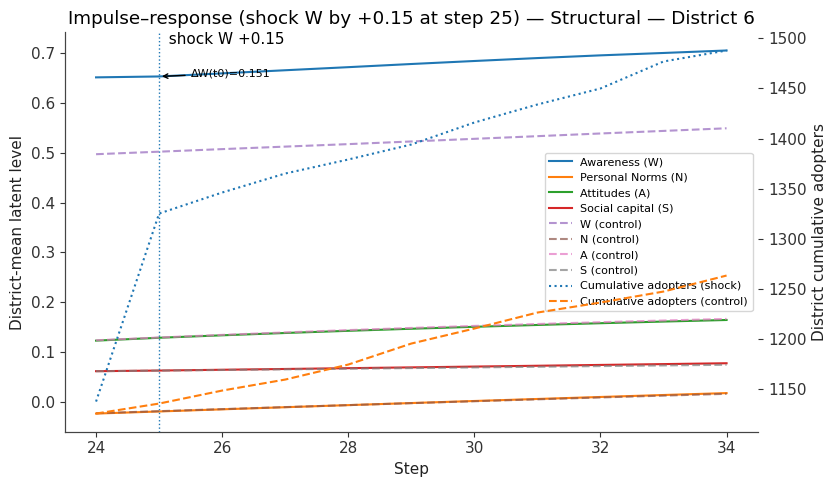

In [104]:
# ------------------------------------------------------------
# Impulse–response plotting from precomputed `metrics` results
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def plot_impulse_response(metrics,
                          behavior="structural",   # "structural" or "raincatching"
                          district="6",            # string or int (will be cast to str)
                          latent_code="W",         # "W", "N", "A", or "S" (shocked latent)
                          use_control=True,        # overlay control (shock-free) series
                          show_latent_control=True,# also overlay control latents (not just adoption)
                          show_annotations=True):  # annotate jump, lag, and adoption lift
    """
    Render a single impulse–response panel for a (behavior, district, latent_code) triple
    using the already-computed results in metrics["impulse_runs"].
    """
    # ---- fetch precomputed run ----
    if "impulse_runs" not in metrics:
        raise RuntimeError("metrics['impulse_runs'] not found; compute it before plotting.")

    key = (behavior, str(district), latent_code)
    if key not in metrics["impulse_runs"]:
        raise KeyError(f"No impulse run stored for {key}. "
                       f"First keys are: {list(metrics['impulse_runs'].keys())[:5]}")

    bundle = metrics["impulse_runs"][key]
    run    = bundle["run"]
    ctrl   = bundle.get("control") if (use_control and bundle.get("control") is not None) else None

    # ---- convert to numpy for convenience ----
    steps = np.asarray(run["steps"], dtype=int)
    W = np.asarray(run["latents"]["W"], dtype=float)
    N = np.asarray(run["latents"]["N"], dtype=float)
    A = np.asarray(run["latents"]["A"], dtype=float)
    S = np.asarray(run["latents"]["S"], dtype=float)
    Cum = np.asarray(run["adoption"]["cumulative"], dtype=int)

    if ctrl is not None:
        steps_c = np.asarray(ctrl["steps"], dtype=int)
        Wc = np.asarray(ctrl["latents"]["W"], dtype=float)
        Nc = np.asarray(ctrl["latents"]["N"], dtype=float)
        Ac = np.asarray(ctrl["latents"]["A"], dtype=float)
        Sc = np.asarray(ctrl["latents"]["S"], dtype=float)
        Cum_c = np.asarray(ctrl["adoption"]["cumulative"], dtype=int)

    t0  = int(run["t0"])
    eps = float(run["eps"])

    # ---- plot ----
    fig, ax = plt.subplots(figsize=(8.5, 5.0))

    # shocked latents (solid)
    hW, = ax.plot(steps, W, label="Awareness (W)")
    hN, = ax.plot(steps, N, label="Personal Norms (N)")
    hA, = ax.plot(steps, A, label="Attitudes (A)")
    hS, = ax.plot(steps, S, label="Social capital (S)")

    # optional control overlays (dashed, lighter)
    hWc = hNc = hAc = hSc = None
    if ctrl is not None and show_latent_control:
        hWc, = ax.plot(steps_c, Wc, linestyle="--", alpha=0.7, label="W (control)")
        hNc, = ax.plot(steps_c, Nc, linestyle="--", alpha=0.7, label="N (control)")
        hAc, = ax.plot(steps_c, Ac, linestyle="--", alpha=0.7, label="A (control)")
        hSc, = ax.plot(steps_c, Sc, linestyle="--", alpha=0.7, label="S (control)")

    ax.set_xlabel("Step")
    ax.set_ylabel("District-mean latent level")

    # adoption on twin axis
    ax2 = ax.twinx()
    hCum, = ax2.plot(steps, Cum, linestyle=":", label="Cumulative adopters (shock)")
    hCumC = None
    if ctrl is not None:
        hCumC, = ax2.plot(steps_c, Cum_c, linestyle="--", label="Cumulative adopters (control)")
    ax2.set_ylabel("District cumulative adopters")

    # event marker at t0
    ax.axvline(t0, linestyle=":", linewidth=1)
    ax.text(t0, ax.get_ylim()[1], f"  shock {latent_code} +{eps:.2f}", va="top")

    # merge legends (left + right axes)
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

    # title
    ax.set_title(f"Impulse–response (shock {latent_code} by +{eps:.2f} at step {t0}) — "
                 f"{behavior.capitalize()} — District {district}")

    plt.tight_layout()

    # ---- optional on-figure annotations & printed summaries ----
    if show_annotations:
        # instantaneous mean jump in shocked latent at t0 (shock vs control)
        if ctrl is not None:
            # index of t0 in each series (they’re aligned by construction)
            i0  = int(np.where(steps == t0)[0][0])
            i0c = int(np.where(steps_c == t0)[0][0])

            latent_map = {"W": (W, Wc), "N": (N, Nc), "A": (A, Ac), "S": (S, Sc)}
            X, Xc = latent_map[latent_code]
            dX = float(X[i0] - Xc[i0])

            # adoption lift at horizon
            dC = int(Cum[-1] - Cum_c[-1])

            # lag to first positive S difference (if available)
            lagS = None
            if show_latent_control:
                dS = S - Sc
                pos = np.where((steps >= t0) & (dS > 0))[0]
                if pos.size > 0:
                    lagS = int(steps[pos[0]] - t0)

            # print concise summary
            print(f"[Summary] {behavior}, District {district}, shock {latent_code} at t0={t0}, eps={eps:.2f}")
            print(f"  Instantaneous district-mean jump in {latent_code}: Δ{latent_code}(t0) = {dX:.4f}")
            if lagS is not None:
                print(f"  First positive S difference at t0+{lagS} (one-step lag expected).")
            print(f"  Adoption lift over horizon: ΔC = {dC} additional cumulative adopters.")

            # annotate near t0
            ax.annotate(f"Δ{latent_code}(t0)={dX:.3f}",
                        xy=(t0, X[i0]), xytext=(t0+0.5, X[i0]),
                        arrowprops=dict(arrowstyle="->"), fontsize=8)

    plt.show()


# ------------------
# Example usage
# ------------------
# District 6, structural, shock W:
plot_impulse_response(metrics, behavior="structural", district="6", latent_code="W",
                      use_control=True, show_latent_control=True, show_annotations=True)

# You can similarly inspect shocks to N or A:
# plot_impulse_response(metrics, behavior="structural", district="6", latent_code="N")
# plot_impulse_response(metrics, behavior="structural", district="6", latent_code="A")

# Or rain-catching:
# plot_impulse_response(metrics, behavior="raincatching", district="6", latent_code="W")


In [265]:
import re

print(agents_all.columns.tolist())
print("Candidates:", [c for c in agents_all.columns if re.search(r"district", c, re.I)])


['Step', 'AgentID', 'Layer', 'Tract', 'District', 'Income', 'Race', 'AdvDegree', 'A_struct', 'N_struct', 'W_struct', 'S_struct', 'A_rain', 'N_rain', 'W_rain', 'S_rain', 'Adopt_S', 'Adopt_R', 'Layer_from_loop']
Candidates: ['District']


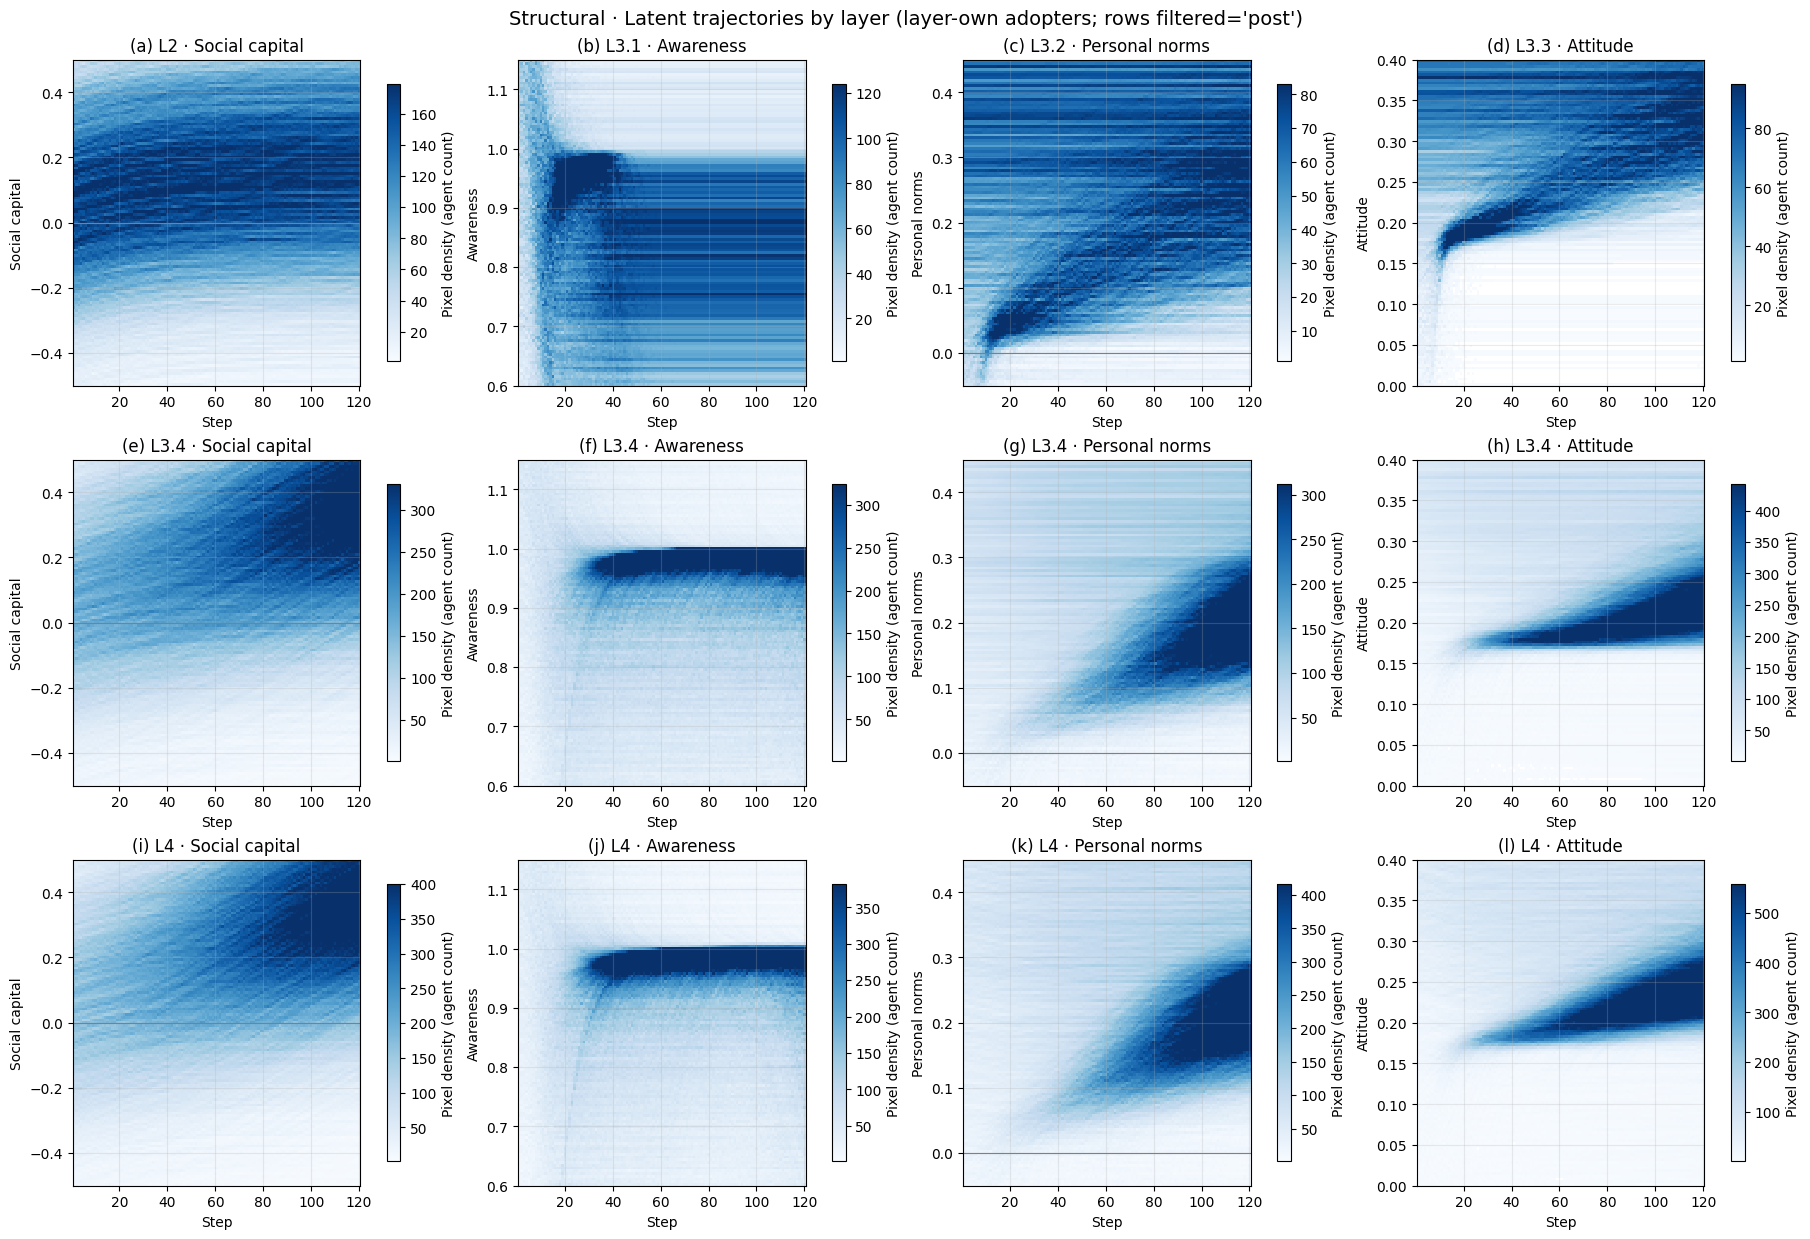

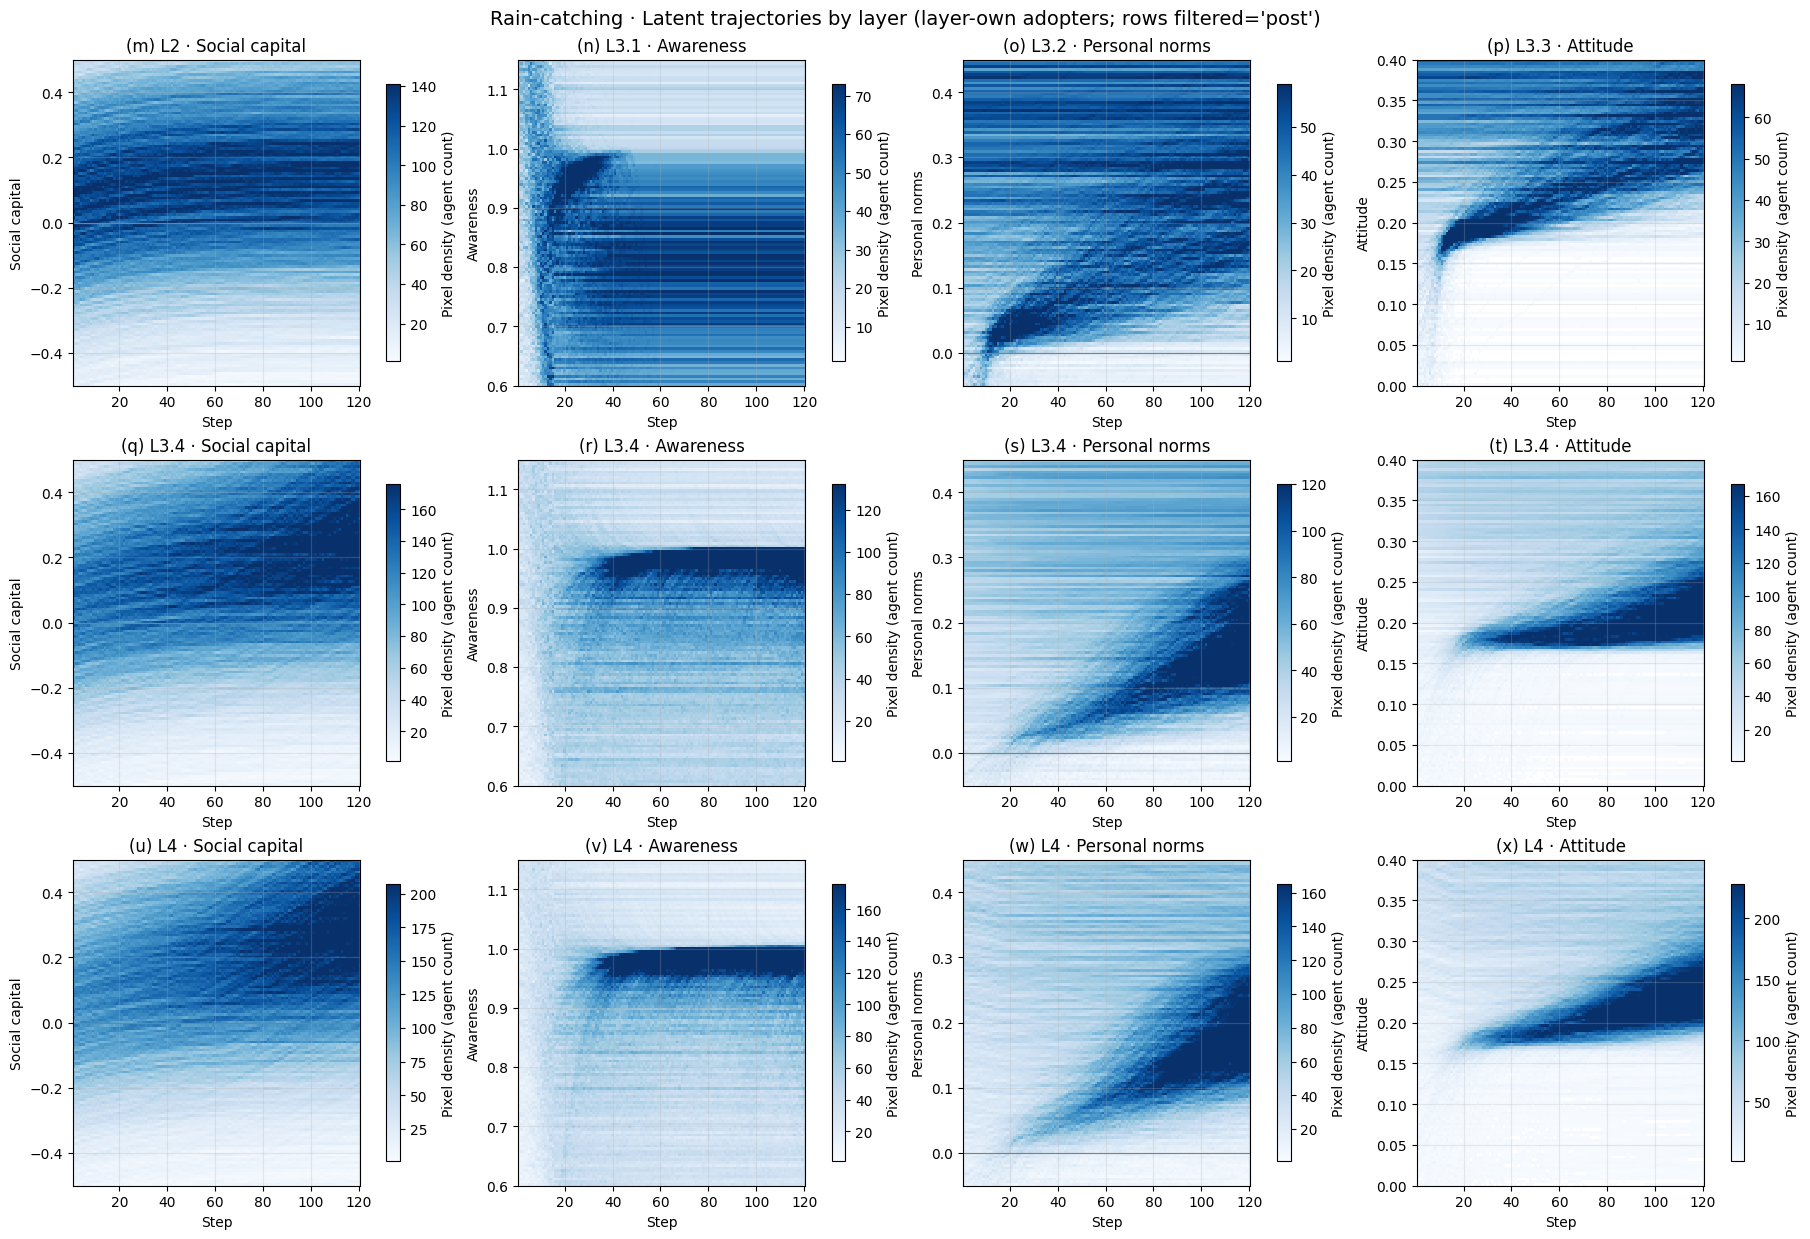

In [78]:
# =========================================
# Cell · Layer-own adopters, shown from their adoption step onward
# 12-panel pixel density, per-panel colorbars, fixed y-limits by latent
# =========================================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Config ------------------------------------------------------------------
# Which behavior to plot first; the cell calls the function twice (both behaviors)
BEHAVIOR_START = "structural"  # "structural" | "raincatching"

# Cohort timing filter for rows (per layer)
#   "post" → include each adopter only at/after their first adoption step in THAT layer (recommended)
#   "new"  → include only the first adoption step row per adopter (very sparse)
#   "all"  → include all rows for adopters (not sparse early)
COHORT_TIMING = "post"

# Panel layout (rows = L2 / L3.4 / L4; columns = S, W, N, A)
GRID_SPEC = [
    [("L2",   "S"), ("L3.1", "W"), ("L3.2", "N"), ("L3.3", "A")],
    [("L3.4", "S"), ("L3.4", "W"), ("L3.4", "N"), ("L3.4", "A")],
    [("L4",   "S"), ("L4",   "W"), ("L4",   "N"), ("L4",   "A")],
]
VAR_LABELS = {"S": "Social capital", "W": "Awareness", "N": "Personal norms", "A": "Attitude"}

# Fixed y-limits per latent/column (tune if needed)
YLIMS_BY_LATENT = {
    "S": (-0.5,  0.5),
    "W": (0.6,   1.15),
    "N": (-0.05, 0.45),
    "A": (0.00,  0.40),
}

# Column mapping for value columns in agents_all
VAL_COL = {
    "structural":   {"S": "S_struct", "W": "W_struct", "N": "N_struct", "A": "A_struct"},
    "raincatching": {"S": "S_rain",   "W": "W_rain",   "N": "N_rain",   "A": "A_rain"},
}

# Binning resolution for heatmaps
YBINS = 120
# -----------------------------------------------------------------------------

def _pick_layer_col(df):
    if "Layer_from_loop" in df.columns: return "Layer_from_loop"
    if "Layer" in df.columns: return "Layer"
    raise ValueError("No 'Layer_from_loop' or 'Layer' column in agents_all.")

def _pick_id_col(df):
    for c in ["AgentID","agent","UniqueID","unique_id","uniqueId","UID","uid","id",
              "ParcelID","HouseholdID","HHID","Agent"]:
        if c in df.columns: return c
    raise ValueError("Could not find an agent ID column in agents_all.")

def _final_step_mask(df, layer_name):
    """Boolean mask for the final step of a given layer + the final step index."""
    layer_col = _pick_layer_col(df)
    if "Step" not in df.columns:
        raise ValueError("agents_all is missing 'Step'.")
    mL = (df[layer_col].to_numpy() == layer_name)
    if not np.any(mL): 
        raise ValueError(f"No rows for layer '{layer_name}'.")
    last_step = int(np.nanmax(df.loc[mL, "Step"].to_numpy()))
    return (mL & (df["Step"].to_numpy() == last_step)), last_step

def _is_boolish_on_mask(series, mask):
    vals = pd.Series(series)[mask].dropna()
    if vals.empty: return False
    if vals.dtype == bool: return True
    low = vals.astype(str).str.lower().str.strip()
    if set(low.unique()) <= {"0","1","true","false","t","f","yes","no","y","n"}: return True
    vnum = pd.to_numeric(vals, errors="coerce").dropna()
    return (not vnum.empty) and set(np.unique(vnum)) <= {0,1}

def _detect_adopt_col(df, behavior, layer_for_hint="L4"):
    """Find adoption flag column (boolean/0-1) for behavior."""
    exact = {
        "structural":   ["Adopt_S","adopt_s","Adopted_structural","adopted_structural"],
        "raincatching": ["Adopt_R","adopt_r","Adopted_rain","adopted_rain","Adopted_raincatching","adopted_raincatching"],
    }[behavior]
    for c in exact:
        if c in df.columns:
            return c
    final_mask, _ = _final_step_mask(df, layer_for_hint)
    patt = re.compile(r"(adopt|adoption)", re.I)
    candidates = [c for c in df.columns if patt.search(str(c))]
    for c in sorted(candidates, key=str):
        try:
            if _is_boolish_on_mask(df[c], final_mask):
                return c
        except Exception:
            pass
    raise ValueError(f"Could not auto-detect adoption column for behavior='{behavior}'.")

def _normalize_adopt(s):
    """Return 0/1 int Series from bool/strings/numeric."""
    if s.dtype == bool: return s.astype(int)
    low = s.astype(str).str.lower()
    if set(np.unique(low.dropna())) <= {"0","1","true","false","t","f","yes","no","y","n"}:
        return low.isin(["1","true","t","yes","y"]).astype(int)
    v = pd.to_numeric(s, errors="coerce")
    return (v.fillna(0).astype(int).clip(0,1))

def _first_adopt_step_by_id(df_layer, id_col, adopt_col):
    """Dict: agent_id -> first step where adopt==1 within this layer."""
    v = _normalize_adopt(df_layer[adopt_col])
    got = df_layer.loc[v==1, [id_col, "Step"]]
    if got.empty: 
        return {}
    return got.groupby(id_col)["Step"].min().to_dict()

def _panel_labels(n, start_letter="a"):
    base = ord(start_letter.lower())
    return [f"({chr(base + i)})" for i in range(n)]

def _draw_panel(ax, df_layer, val_col, y_label, title, ylimits, per_panel_cbar=True):
    if df_layer.empty or val_col not in df_layer.columns:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel("Step"); ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.25); 
        return None

    x = df_layer["Step"].to_numpy()
    y = df_layer[val_col].astype(float).to_numpy()
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]
    if x.size == 0:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_title(title); ax.set_xlabel("Step"); ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.25); 
        return None

    xmin, xmax = int(np.min(x)), int(np.max(x))
    xbins = np.arange(xmin - 0.5, xmax + 1.5, 1.0)
    ybins = np.linspace(ylimits[0], ylimits[1], YBINS)

    H, _, _ = np.histogram2d(x, y, bins=[xbins, ybins])
    H = np.ma.masked_equal(H, 0)
    vmax = (np.percentile(H.compressed(), 95) if H.count() > 0 else 1)

    pcm = ax.pcolormesh(xbins, ybins, H.T, cmap="Blues", shading="auto", vmin=1, vmax=vmax)
    ax.set_xlim(xbins[0], xbins[-1]); ax.set_ylim(ybins[0], ybins[-1])
    if ybins[0] < 0 < ybins[-1]: ax.axhline(0, color="grey", lw=0.8)
    ax.set_xlabel("Step"); ax.set_ylabel(y_label); ax.set_title(title)
    ax.grid(True, alpha=0.25)

    if per_panel_cbar:
        cbar = plt.colorbar(pcm, ax=ax, shrink=0.85)
        cbar.set_label("Pixel density (agent count)")

    return pcm

def plot_latent_density_layer_adopters(
    agents_all,
    behavior="structural",
    cohort_timing="post",     # "post" | "new" | "all"
    fig_size=(18, 12),
    start_letter="a"
):
    """Each panel uses adopters defined by the *final step of that layer*;
    rows are filtered by cohort_timing within that layer."""
    if agents_all is None or agents_all.empty:
        raise ValueError("agents_all is empty.")

    layer_col = _pick_layer_col(agents_all)
    id_col    = _pick_id_col(agents_all)
    adopt_col = _detect_adopt_col(agents_all, behavior, layer_for_hint="L4")

    labels = _panel_labels(12, start_letter=start_letter)
    fig, axes = plt.subplots(3, 4, figsize=fig_size, squeeze=False, constrained_layout=True)
    panel_idx = 0

    for r in range(3):
        for c in range(4):
            layer, latent_key = GRID_SPEC[r][c]
            val_col = VAL_COL[behavior][latent_key]
            ylimits = YLIMS_BY_LATENT[latent_key]

            # Slice this layer only (keep just needed cols for memory)
            mask_layer = (agents_all[layer_col].to_numpy() == layer)
            dfL = agents_all.loc[mask_layer, ["Step", val_col, id_col, adopt_col]].copy()
            if dfL.empty:
                _draw_panel(axes[r, c], dfL, val_col, VAR_LABELS[latent_key],
                            f"{labels[panel_idx]} {layer} · {VAR_LABELS[latent_key]}",
                            ylimits)
                panel_idx += 1
                continue

            # Who adopts by the final step of THIS layer?
            last_mask, last_step = _final_step_mask(agents_all, layer)
            adopters_final = set(
                agents_all.loc[last_mask, [id_col, adopt_col]]
                          .pipe(lambda d: d[_normalize_adopt(d[adopt_col]) == 1])[id_col]
                          .tolist()
            )
            if len(adopters_final) == 0:
                _draw_panel(axes[r, c], dfL.head(0), val_col, VAR_LABELS[latent_key],
                            f"{labels[panel_idx]} {layer} · {VAR_LABELS[latent_key]}",
                            ylimits)
                panel_idx += 1
                continue

            # Keep only those adopters' rows in this layer
            dfL = dfL[dfL[id_col].isin(adopters_final)].copy()

            # First adoption step per adopter (in THIS layer)
            first_adopt = _first_adopt_step_by_id(dfL, id_col, adopt_col)

            # Timing filter
            if cohort_timing == "post":
                keep = []
                fa = first_adopt  # local
                st = dfL["Step"].to_numpy()
                ids = dfL[id_col].to_numpy()
                for i in range(len(dfL)):
                    fid = fa.get(ids[i], None)
                    keep.append(fid is not None and st[i] >= fid)
                df_plot = dfL.loc[keep, ["Step", val_col, id_col]]
            elif cohort_timing == "new":
                df_plot = dfL[dfL.apply(lambda r: first_adopt.get(r[id_col], None) == r["Step"], axis=1)][["Step", val_col, id_col]]
            else:  # "all"
                df_plot = dfL[["Step", val_col, id_col]]

            title = f"{labels[panel_idx]} {layer} · {VAR_LABELS[latent_key]}"
            _ = _draw_panel(axes[r, c], df_plot, val_col, VAR_LABELS[latent_key], title, ylimits, per_panel_cbar=True)
            panel_idx += 1

    supt = "Structural" if behavior == "structural" else "Rain-catching"
    fig.suptitle(f"{supt} · Latent trajectories by layer "
                 f"(layer-own adopters; rows filtered='{cohort_timing}')",
                 y=1.02, fontsize=14)
    plt.show()


# ── Run for both behaviors ───────────────────────────────────────────────────
plot_latent_density_layer_adopters(
    agents_all,
    behavior=BEHAVIOR_START,
    cohort_timing=COHORT_TIMING,
    fig_size=(18, 12),
    start_letter="a"   # labels (a)–(l)
)

plot_latent_density_layer_adopters(
    agents_all,
    behavior=("raincatching" if BEHAVIOR_START=="structural" else "structural"),
    cohort_timing=COHORT_TIMING,
    fig_size=(18, 12),
    start_letter="m"   # labels (m)–(x)
)
